# Customs Fraud Detection

**AI-based Cargo Selectivity for Customs**

Final Project

## WCO-SKKU BACUDA Data Analytics Scholarship - 2nd edition - 2023

Team Members

> Argentina - Santiago Tedoldi

> Maldives - Iqbal Ismail

> Mauritius - Ghanpriya Balliah



# Executive Summary

This project aims to leverage Machine Learning (ML) and Artificial Intelligence (AI) for Cargo Selectivity in Customs operations by developing and evaluating a tool which will apply a data-driven approach for fraud detection. This tool shall be integrated with the current Risk Management System (RMS), which combines the business expertise in developing proper selectivity rules (hypothesis) and the human intuition for contextual understanding and emotional intelligence.

A data pipeline was developed to train and evaluate different open-source ML and AI algorithms, from linear and simple models to ensemble and deep learning ones. BACUDA DATE model was also tested with some limitations with regards to the features available (due to data privacy restrictions) but during the testing stage, it was perceived that simpler ensemble algorithms were more superior than the former.

The results were shown to be promising, indicating that a reduction of 80 % of the physical inspections is possible whilst 96 % of frauds are still detected. Furthermore, even if the physical inspections were to be reduced by only 70 %, 99 % of frauds are still being targeted as high risk operation.

As an outcome of this project, it is expected that the integration of this ML model with the current RMS (risk selectivity rules) can improve the performance and the quality of local Customs services. This will also promote compliance of trade operators, trade facilitation and economical worth whilst increasing the prestige of the administrations. 

Finally, with the proper support of the management team, especially the RMS managers, IT team and legal advisors, the deployment of the model is just a matter of months, and it will be carried out in three stages:

> **1. Shadow stage**: model running in parallel without effect on the selectivity results, for performance measure and further analysis.

> **2. Canary stage**: 10 % of the import declaration exposed to the model, with impact and measuring performance whilst its integration with RMS is defined.

> **3. AI-RMS final integration**: The model is integrated with the RMS and the targeted reduction of physical inspections is achieved, whilst model monitoring, continuous improvement and re-training is carried out.

Total investment cost estimated = 1.98 millions US$

## Global Perspective

The current global environment is characterized by a robust expansion of international trade, an increased complexity of supply chains, demands for streamlined measures in trade facilitation, and the transformative impact of AI on supply chain management. Navigating through these dynamics requires a strategic approach that embraces innovation, resilience, and sustainability in the realm of international trade and logistics.

## Domestic Perspective

Customs administrations in some developing countries are faced with resource constraints related to human resources, equipment and operation sites, amongst others, with the ongoing challenge to deal with the complex trade-off relationship between enforcement and trade facilitation. Fortunately, ML and AI technology can be developed to help in this difficult task.

## SWOT analysis

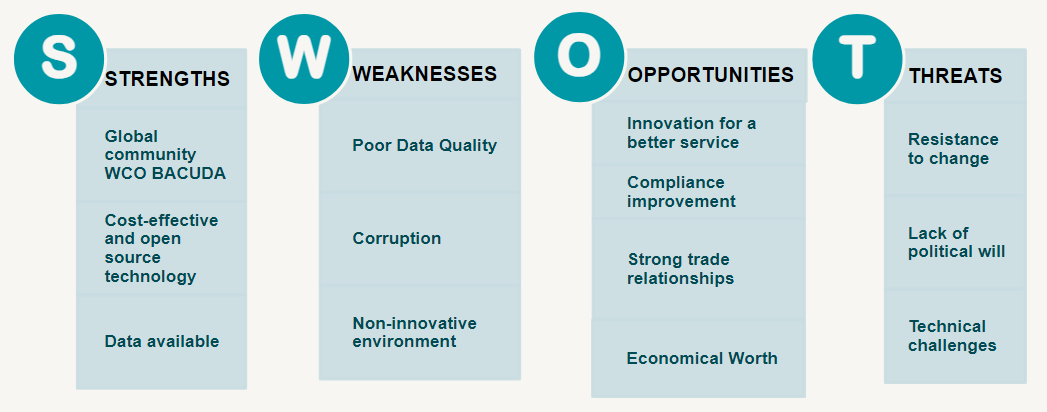

## Data and Methodology

### Data Sources

> Synthetic data: Generated using the CTGAN algorithm for demonstration and educational purposes.

> Real data: Extracted from the Argentine Customs Administration, excluding sensitive information such as companies, brokers, and shippers IDs.

### Algorithms

> Logistic Regression, LightGBM, and XGBoost were implemented, with XGBoost selected due to its superior performance, especially in fraud detection and revenue increase.

> DATE model, replacing Importer ID with Country of Origin ID, did not outperform XGBoost.

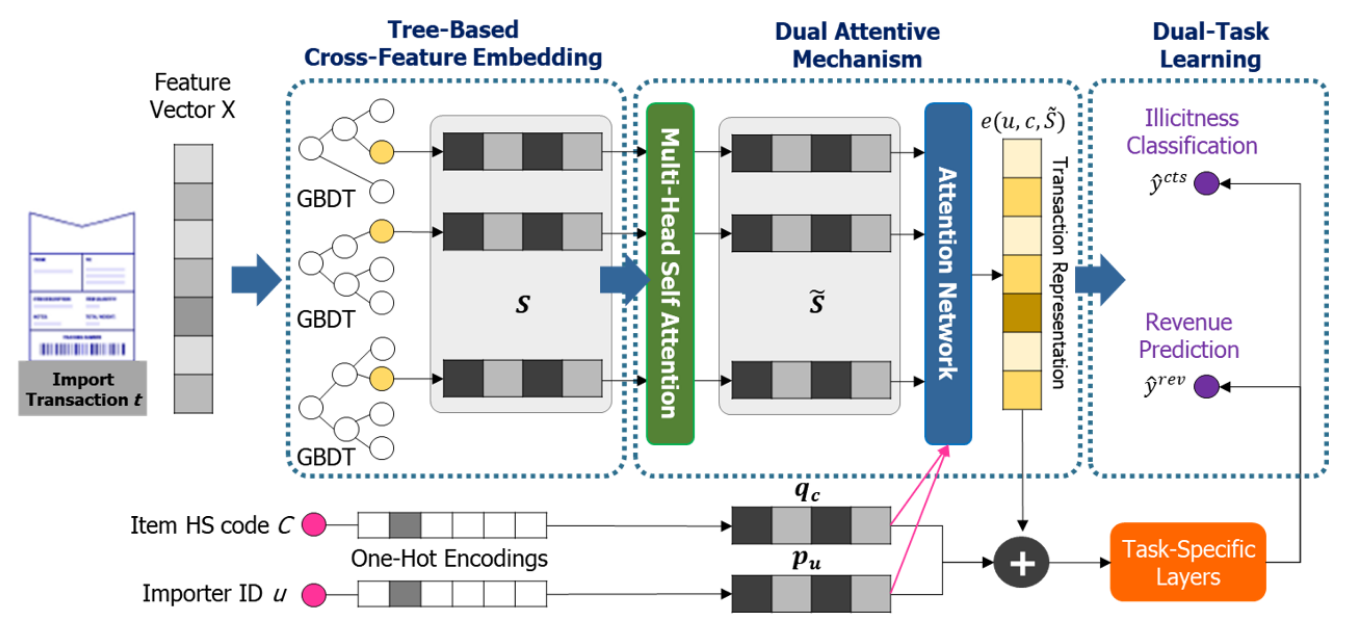

### Processing Pipeline

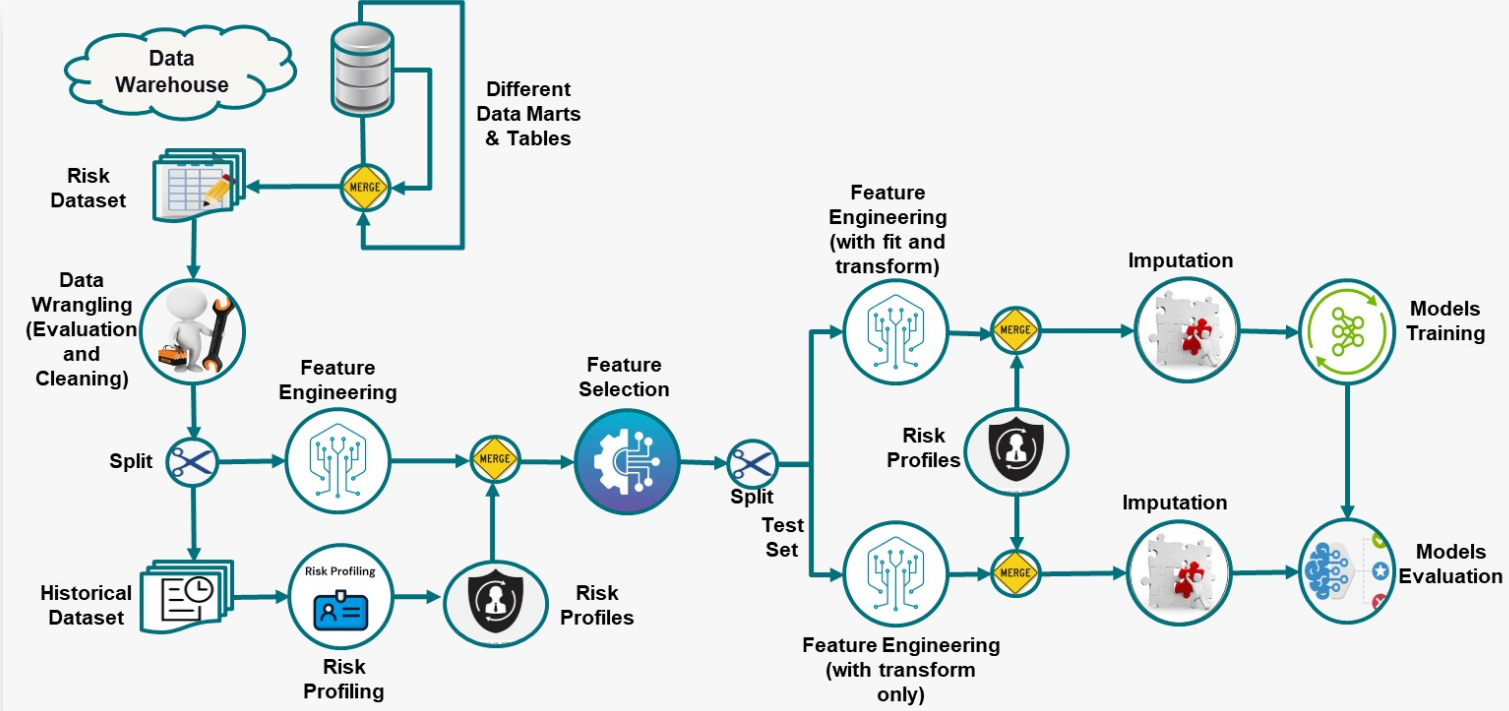


### Results and Outcomes

> 20 % of inspection rate would come with 96 % of fraud detected.

> 30 % of inspection rate can would come with 99 % of fraud detected.

> Intensive validation over XGboost shows stable prediction with regards to fraud detected rate.

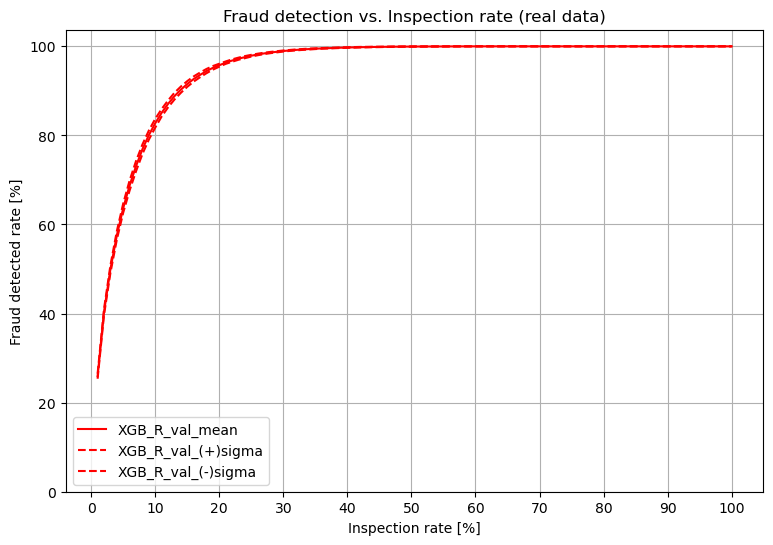

> Revenue increase is dependent on the data and its split.

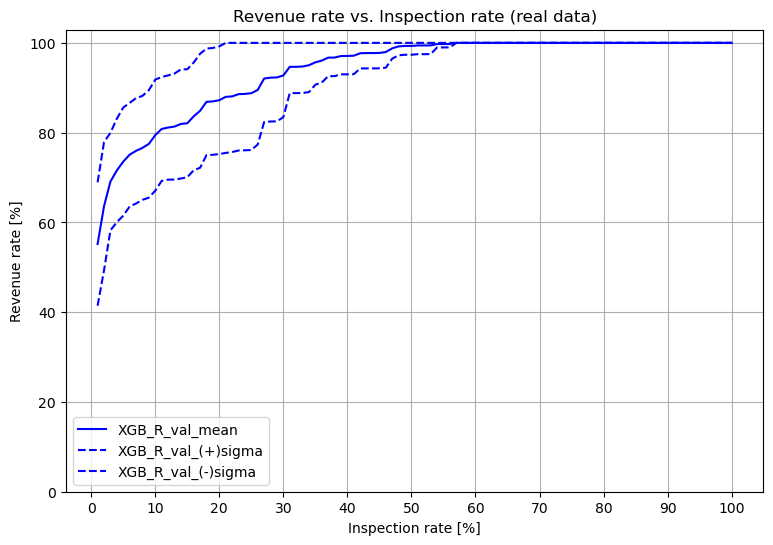

> Splitting the problem by means of transport showed significant improvement (+ 25% in F1 score)

### Development and Deployment

> It is expected that the development of this project will take around 22 months.

> Its deployment could take around 3-6 months with the proper support from the management team, especially the RMS managers, IT team and legal advisors.




## Python enviroment with Anaconda

> conda create -n bacuda_proy python=3.11 # for GPU operation

> conda activate bacuda_proy

**basics**

> conda install -c anaconda numpy

> conda install -c anaconda pandas

**Machine learning**

> conda install -c anaconda scikit-learn

> conda install -c conda-forge xgboost

> conda install -c conda-forge lightgbm

> conda install -c conda-forge imbalanced-learn

> *Not working* conda install -c conda-forge py-xgboost-gpu

**deep learning with gpu**

> conda install -c anaconda cudnn

> conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch-nightly -c nvidia

**Visualization**

> conda install -c conda-forge matplotlib

> conda install -c anaconda seaborn

**Others**

> conda install -c conda-forge tabulate

> conda install -c intel tqdm



# Libraries

In [1]:
## basics

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import itertools
import warnings
warnings.simplefilter('ignore')

# directories
import os

## plots

import matplotlib.pyplot as plt
import seaborn as sns
paleta_ppt = ['#a6bfa5','#c9d8c8', '#696969','#ff9800']

## preprocessing

# normalization and nulls imputation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm
from sklearn.impute import SimpleImputer

## modelling Libraries

from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score,recall_score
from sklearn.metrics import roc_curve, auc
# train/test
from sklearn.model_selection import train_test_split

# tuning
from sklearn.model_selection import RandomizedSearchCV

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# sampling
from imblearn.over_sampling import RandomOverSampler

## saving results

import joblib
from datetime import date 


# Data sources

For demonstration of the developed ML & AI project, synthetic data (non-real) was used. However, when a parallel processing was performed with the real data, incoherent results were obtained and this can be seen in this notebook's content. The two sources of the data are described below:

> Synthetic data from WCO BACUDA courses

Physically inspected customs items and their declaration data were generated using CTGAN algorithm, which is suitable for demonstration/educational purposes.

> Real data from Argentine Customs Administration

Physically inspected customs items and their declaration data (including inspection results) but excluding (to reduce the sensitivity of the data) companies, brokers and shippers IDs.

In [2]:
PATH_INPUT_DATA = os.path.join('./Data','import_data.csv') #Adapt this path if it is necessary
OUTPUT_RESULTS = 'Results'
OUTPUT_PROFILES = 'Historic profiles'

if not os.path.exists(OUTPUT_RESULTS):
    os.makedirs(OUTPUT_RESULTS)

if not os.path.exists(OUTPUT_PROFILES):
    os.makedirs(OUTPUT_PROFILES)

# Loading Data

In [3]:
# specifying data types from the source
dtypes_dict = {
    'TARIFF.CODE':str,
    'CIF_USD_EQUIVALENT': float,
    'QUANTITY': float,
    'GROSS.WEIGHT': float,
    'TOTAL.TAXES.USD': float,
    'RAISED_TAX_AMOUNT_USD':float,
    'illicit':bool
}

df_original = pd.read_csv(PATH_INPUT_DATA, sep=",", dtype=dtypes_dict)

# to show numbers easier to read
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# dictionary defining data

dict_data = {'year':'Year of the operation',
            'month':'Month of the operation',
            'day':'Day of the operation',
            'OFFICE':'Custom office ID in which the importation is declared',
            'IMPORTER.TIN':'Importer ID',
            'TARIFF.CODE':'HS6 codification + local codification',
            'ORIGIN.CODE':'Country ID from where the goods come',
            'CIF_USD_EQUIVALENT':'CIF value declared in USD',
            'QUANTITY':'Unit quantity declared',
            'GROSS.WEIGHT':'Gross weight declared',
            'TOTAL.TAXES.USD':'Taxes/duties paid by the importer',
            'illicit':'Indicator whether the operation was fraud or not' #Taget
            }


In [5]:
df_original

year  month  day     OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0       2013      1    1   OFFICE60    IMP545640  8703232225    CNTRY680   
1       2013      1    1   OFFICE24    IMP252323  8703321220    CNTRY376   
2       2013      1    1   OFFICE59    IMP194834  8704212025    CNTRY680   
3       2013      1    1   OFFICE60    IMP668188  3901100000    CNTRY277   
4       2013      1    1   OFFICE59    IMP395619  8517180000    CNTRY759   
...      ...    ...  ...        ...          ...         ...         ...   
199995  2014     12   31  OFFICE168    IMPO19832  3926909710    CNTRY994   
199996  2014     12   31  OFFICE296    IMPO10210  8704319941    CNTRY959   
199997  2014     12   31  OFFICE298    IMPO11255  5806200000    CNTRY994   
199998  2014     12   31  OFFICE168    IMPO16962  5807109010    CNTRY376   
199999  2014     12   31  OFFICE109    IMPO10548  3204110000    CNTRY976   

        CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0                172710.00      1.00      28487.00          3492.00   
1                  7450.00      1.00     185994.00           503.00   
2                  2684.00      1.00     452843.00          5706.00   
3                  7412.00   2018.00      26546.00          3182.00   
4                  2786.00   7044.00       1958.00           587.00   
...                    ...       ...           ...              ...   
199995            19056.00      1.00        189.00             5.00   
199996              532.00    243.00         15.00           234.00   
199997               11.00     58.00         24.00             5.00   
199998             2826.00      3.00        822.00             5.00   
199999            86099.00 333634.00       3606.00         10166.00   

        RAISED_TAX_AMOUNT_USD  illicit  
0                        0.00    False  
1                        0.00    False  
2                        0.00    False  
3                        0.00    False  
4                        0.00    False  
...                       ...      ...  
199995                   0.00    False  
199996                 105.00     True  
199997                   0.00    False  
199998                   0.00    False  
199999                 267.00     True  

[200000 rows x 13 columns]

In [6]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year                   200000 non-null  int64  
 1   month                  200000 non-null  int64  
 2   day                    200000 non-null  int64  
 3   OFFICE                 200000 non-null  object 
 4   IMPORTER.TIN           200000 non-null  object 
 5   TARIFF.CODE            200000 non-null  object 
 6   ORIGIN.CODE            200000 non-null  object 
 7   CIF_USD_EQUIVALENT     200000 non-null  float64
 8   QUANTITY               200000 non-null  float64
 9   GROSS.WEIGHT           200000 non-null  float64
 10  TOTAL.TAXES.USD        200000 non-null  float64
 11  RAISED_TAX_AMOUNT_USD  200000 non-null  float64
 12  illicit                200000 non-null  bool   
dtypes: bool(1), float64(5), int64(3), object(4)
memory usage: 18.5+ MB


In [7]:
df_original.shape

(200000, 13)

______________

# Data Wrangling

The synthetic data was found to be fairly clean data for which data wrangling techniques were not required.

On the other hand, the real data, in order to ensure that the data was clean, relevant, and suitable for further analysis (quality of the data), the following tasks were carried out:

**Missing Values** for row and columns:

> Imputation, removal of rows/columns with missing values, or using specific methods based on the context.

> Missing values with meaning were found and imputed accordingly.

**Duplicates** and hidden duplication:

> Search for duplicates that might not be immediately apparent. 

> Consider dropping or merging categories that represent similar information.

**Outliers** or unreasonable values:

> Trade values and amount show distributions that seem to be filled with outliers.

> Negative or zero values are unreasonable for many values (such us net weight). 

**Simple Variable Selection**

> Excluding evident unnecessary columns, such as constant columns of not relevant ones (e.g: columns only used for export operations, whilst fraud in imports were the current problem to predict).

In [8]:
###

___________________________________________________________________________

# Exploratory analysis

In [9]:
df_eda = df_original.copy()

In [10]:
# Separating variables types
allColumns = list(df_eda.columns.values)
target = ['illicit']
categorical = df_eda.drop('illicit', axis = 1).select_dtypes('object').columns.tolist()
numeric = df_eda.drop(['year','month','day','illicit'], axis = 1).select_dtypes('number').columns.tolist()

In [11]:
allColumns

['year',
 'month',
 'day',
 'OFFICE',
 'IMPORTER.TIN',
 'TARIFF.CODE',
 'ORIGIN.CODE',
 'CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'RAISED_TAX_AMOUNT_USD',
 'illicit']

**Observations:**

> This dataset counts on very few numeric variables, just 4, without considering the date.

> It is crucial to use encoding techniques on categoric variables.

> 1.5% of missing values, possibility to drop them.

## Missing values

In [12]:
# Missing values
percent_missing = df_eda.isnull().sum()*100/len(df_eda)
percent_missing

year                    0.00
month                   0.00
day                     0.00
OFFICE                  0.00
IMPORTER.TIN            0.00
TARIFF.CODE             0.00
ORIGIN.CODE             0.00
CIF_USD_EQUIVALENT      0.00
QUANTITY                0.00
GROSS.WEIGHT            0.00
TOTAL.TAXES.USD         0.00
RAISED_TAX_AMOUNT_USD   0.00
illicit                 0.00
dtype: float64

In [13]:
# Total % of nulls in the dataset
percent_missing.sum()

0.0

# Target analysis

The synthetic data came with a defined binary target, whilst the real situation was that the inspection results consisted of 6 different variables (type of offences, observations, blocked operation, confiscations, minimum penalty to be charged, etc.). 

An intensive analysis was carried out to define the target for the real data set, obtaining a binary indicator (fraud or non-fraud) and an estimated tax increase.

In [14]:
def plot_target(data, save = False):
    '''
    Shows a bar plot with the distribution of the target variable ['illicit']

    Arguments:
    ----------
    data ---------- dataframe, must contain the illicit variable
    save ---------- [Opcional] booleana, flag which indicates whether to save the plot in results folder (default=False)

    '''
    sns.set(font_scale=1.4)
    sns.set_style("white")

    plt.figure(figsize=(10,5))

    g = sns.countplot(x='illicit', data=data, palette = [paleta_ppt[0], paleta_ppt[-1]])
    g.set_ylabel('Illicit count')
    g.set_xlabel('')
    plt.title('Target value counting: illicit\n', fontsize=22)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)

    # anotations
    porcentages = 100*data.illicit.value_counts(normalize=True)
    for p, porc in zip(g.patches, porcentages):
        g.annotate(
                   '{:.2f}%\n({:1.0f})'.format(porc, p.get_height()),     # text
                    (p.get_x()+p.get_width() /2. , 0.45*p.get_height()),  # position
                    ha = 'center', va = 'center', fontsize=18             # properties
                  )


    # saving picture
    if save:
        plt.savefig(os.path.join('Results','plot_target_'+str(date.today())+'.png'), bbox_inches='tight', transparent=False)
    plt.show()

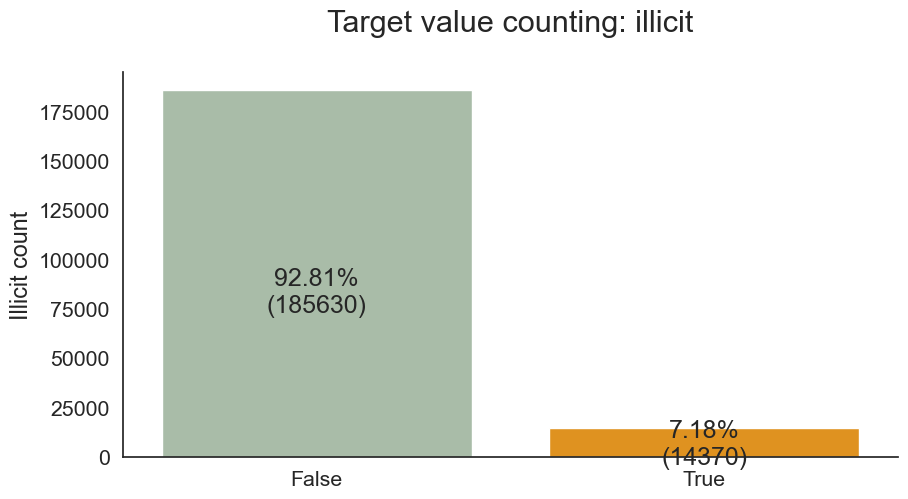

In [15]:
plot_target(df_eda,True)

**Observations:**

> The dataset is strongly unbalanced. Real data is worse, with only 3 % of issues detected.

> The application of resampling methods or the manipulation of the probability threshold will be necessary to compensate for this.

Some algorithms were also implemented with hyperparameters in order to improve the balance in the target class.

# Categorical variables analysis

In [16]:
def counting(data, col, dropna = False, acumulated = False):
    '''
    Returns a dataframe with the counting, rate and percentage
    Done over the data input, regarding the column indicated 
    
    arguments:
    -----------
    - data: ----- dataframe, to analyze
    - col: ------------ str, column name of the categorical variable to analyze
    - dropna: --------- [optional] Booleana, whether to include nulls in the counting (default False)
    - acumulated: ------ [optional] Booleana, whether to include nulls a column of acumulated values (default False)
    
    return:
    ------
     dataframe
    '''
    df_abs = data[col].value_counts(dropna=dropna).to_frame('absolut').reset_index()
    df_porc = data[col].value_counts(dropna=dropna, normalize=True).mul(100).to_frame('percentage').reset_index()

    df_porc['percentage'] = 100*df_porc['percentage']
    
    if acumulated:
        acum = 0
        for i, row in df_porc.iterrows():
            acum += df_porc.loc[i, 'percentage']
            df_porc.loc[i, 'acumulated'] = acum

    return pd.merge(df_abs, df_porc).rename(columns={'index':col})

In [17]:
for col in categorical:
    print(counting(df_eda, col, acumulated = True).head(10).to_markdown())
    print('--'*20)

|    | OFFICE    |   absolut |   percentage |   acumulated |
|---:|:----------|----------:|-------------:|-------------:|
|  0 | OFFICE51  |     37425 |      1871.25 |      1871.25 |
|  1 | OFFICE59  |     18602 |       930.1  |      2801.35 |
|  2 | OFFICE168 |     14567 |       728.35 |      3529.7  |
|  3 | OFFICE187 |     12148 |       607.4  |      4137.1  |
|  4 | OFFICE127 |     11054 |       552.7  |      4689.8  |
|  5 | OFFICE40  |     10198 |       509.9  |      5199.7  |
|  6 | OFFICE296 |      8411 |       420.55 |      5620.25 |
|  7 | OFFICE60  |      7855 |       392.75 |      6013    |
|  8 | OFFICE76  |      6241 |       312.05 |      6325.05 |
|  9 | OFFICE204 |      5500 |       275    |      6600.05 |
----------------------------------------
|    | IMPORTER.TIN   |   absolut |   percentage |   acumulated |
|---:|:---------------|----------:|-------------:|-------------:|
|  0 | IMPO19420      |      1272 |        63.6  |        63.6  |
|  1 | IMPO11284      |      

**Observations:**

> All categorical variables are nominals, so techniques like one-hot encoding or dense embeddings are required.

> Because of the quantity of uniques codes (more than 21.000 globally), one-hot-encoding is not an option for synthetic data.

    OFFICE: 73
    IMPORTER.TIN: 15347
    TARIFF.CODE: 6334
    ORIGIN.CODE: 131
    
    Total: 21885

> Target encoding is also an option, but shall be taken carefully because of the data leakage (information from the target going to the predictors) and overfitting.

> In real data, there are relevant features with less than 15 uniques codes (means of transport, state of use of goods) and can be treated with one-hot encoding.

# Numeric variables analysis

Distributions and boxplot of each original variable

In [18]:
df_eda.describe()

year     month       day  CIF_USD_EQUIVALENT   QUANTITY  \
count 200000.00 200000.00 200000.00           200000.00  200000.00   
mean    2013.43      6.40     15.74            57958.80    5396.64   
std        0.50      3.52      8.74           281113.36   56638.52   
min     2013.00      1.00      1.00                2.00       1.00   
25%     2013.00      4.00      8.00             2313.00       3.00   
50%     2013.00      6.00     16.00             5595.00      84.00   
75%     2014.00     10.00     23.00            29539.25     685.00   
max     2014.00     12.00     31.00         17127262.00 9346582.00   

       GROSS.WEIGHT  TOTAL.TAXES.USD  RAISED_TAX_AMOUNT_USD  
count     200000.00        200000.00              200000.00  
mean       92648.79          3840.15                  53.80  
std       494559.17         15671.22                 250.40  
min            1.00             0.00                   0.00  
25%          135.00             5.00                   0.00  
50%         1711.00           518.00                   0.00  
75%        28965.25          3073.00                   0.00  
max     63739520.00       1176714.00                5700.00

In [19]:
def plot_numeric(data, col_num, n, num_type=None, plot_type='dist', save=False):
    '''
    Shows a plot with a distribution analysis done over the numeric variables
    It uses a sample of n random values, to reduce process effort
    
    arguments:
    -----------
    - data: ----- dataframe, to analyze
    - col: ------------ list, column names of the numeric variables to analyze
    - n: ------------ int, saples number to work with
    - save ---------- [Opcional] booleana, flag which indicates whether to save the plot in results folder (default=False)
    
    return:
    plots
    ------
    '''
    data_sample = data[col_num].sample(n)
    
    #Plotting using: 
    #-displot with fit=norm for float variables
    #-histplot for int variables
    
    plt.figure(figsize=(25,25*len(col_num)))

    for index, (colname, serie) in enumerate(data_sample.items()):
        plt.subplot(31,1, index+1)
        # variable type as float
        if pd.api.types.is_float_dtype(serie) is True:
            # regular numeric plot
            if num_type == None:
                # distplot
                if plot_type == 'dist':
                    sns.distplot(serie,fit=norm)
                    plt.axvline(np.mean(serie), color='slategrey')
                # boxplot
                elif plot_type == 'box':
                    sns.boxplot(x=serie)
                plt.title(colname, fontsize=14)
            # log numeric plot
            elif num_type == 'log':
                # distplot
                if plot_type == 'dist':
                    if min(serie)>0:
                        sns.distplot(np.log(serie),fit=norm)
                    else:
                        sns.distplot(np.log(serie+1),fit=norm)
                # boxplot
                elif plot_type == 'box':
                    if min(serie)>0:
                        sns.boxplot(x=np.log(serie))
                    else:
                        sns.boxplot(x=np.log(serie+1))
                plt.title('Log('+colname+')', fontsize=14)
        # variable type as integer
        elif pd.api.types.is_integer_dtype(serie) is True:
            sns.histplot(serie, bins=20)
        # gral layout
        plt.xlabel('') 
        plt.tight_layout()

    # Saving plots
    if save:
        plt.savefig(os.path.join('Results','plot_numeric_'+str(date.today())+'.png'), bbox_inches='tight', transparent=True)
    plt.show()


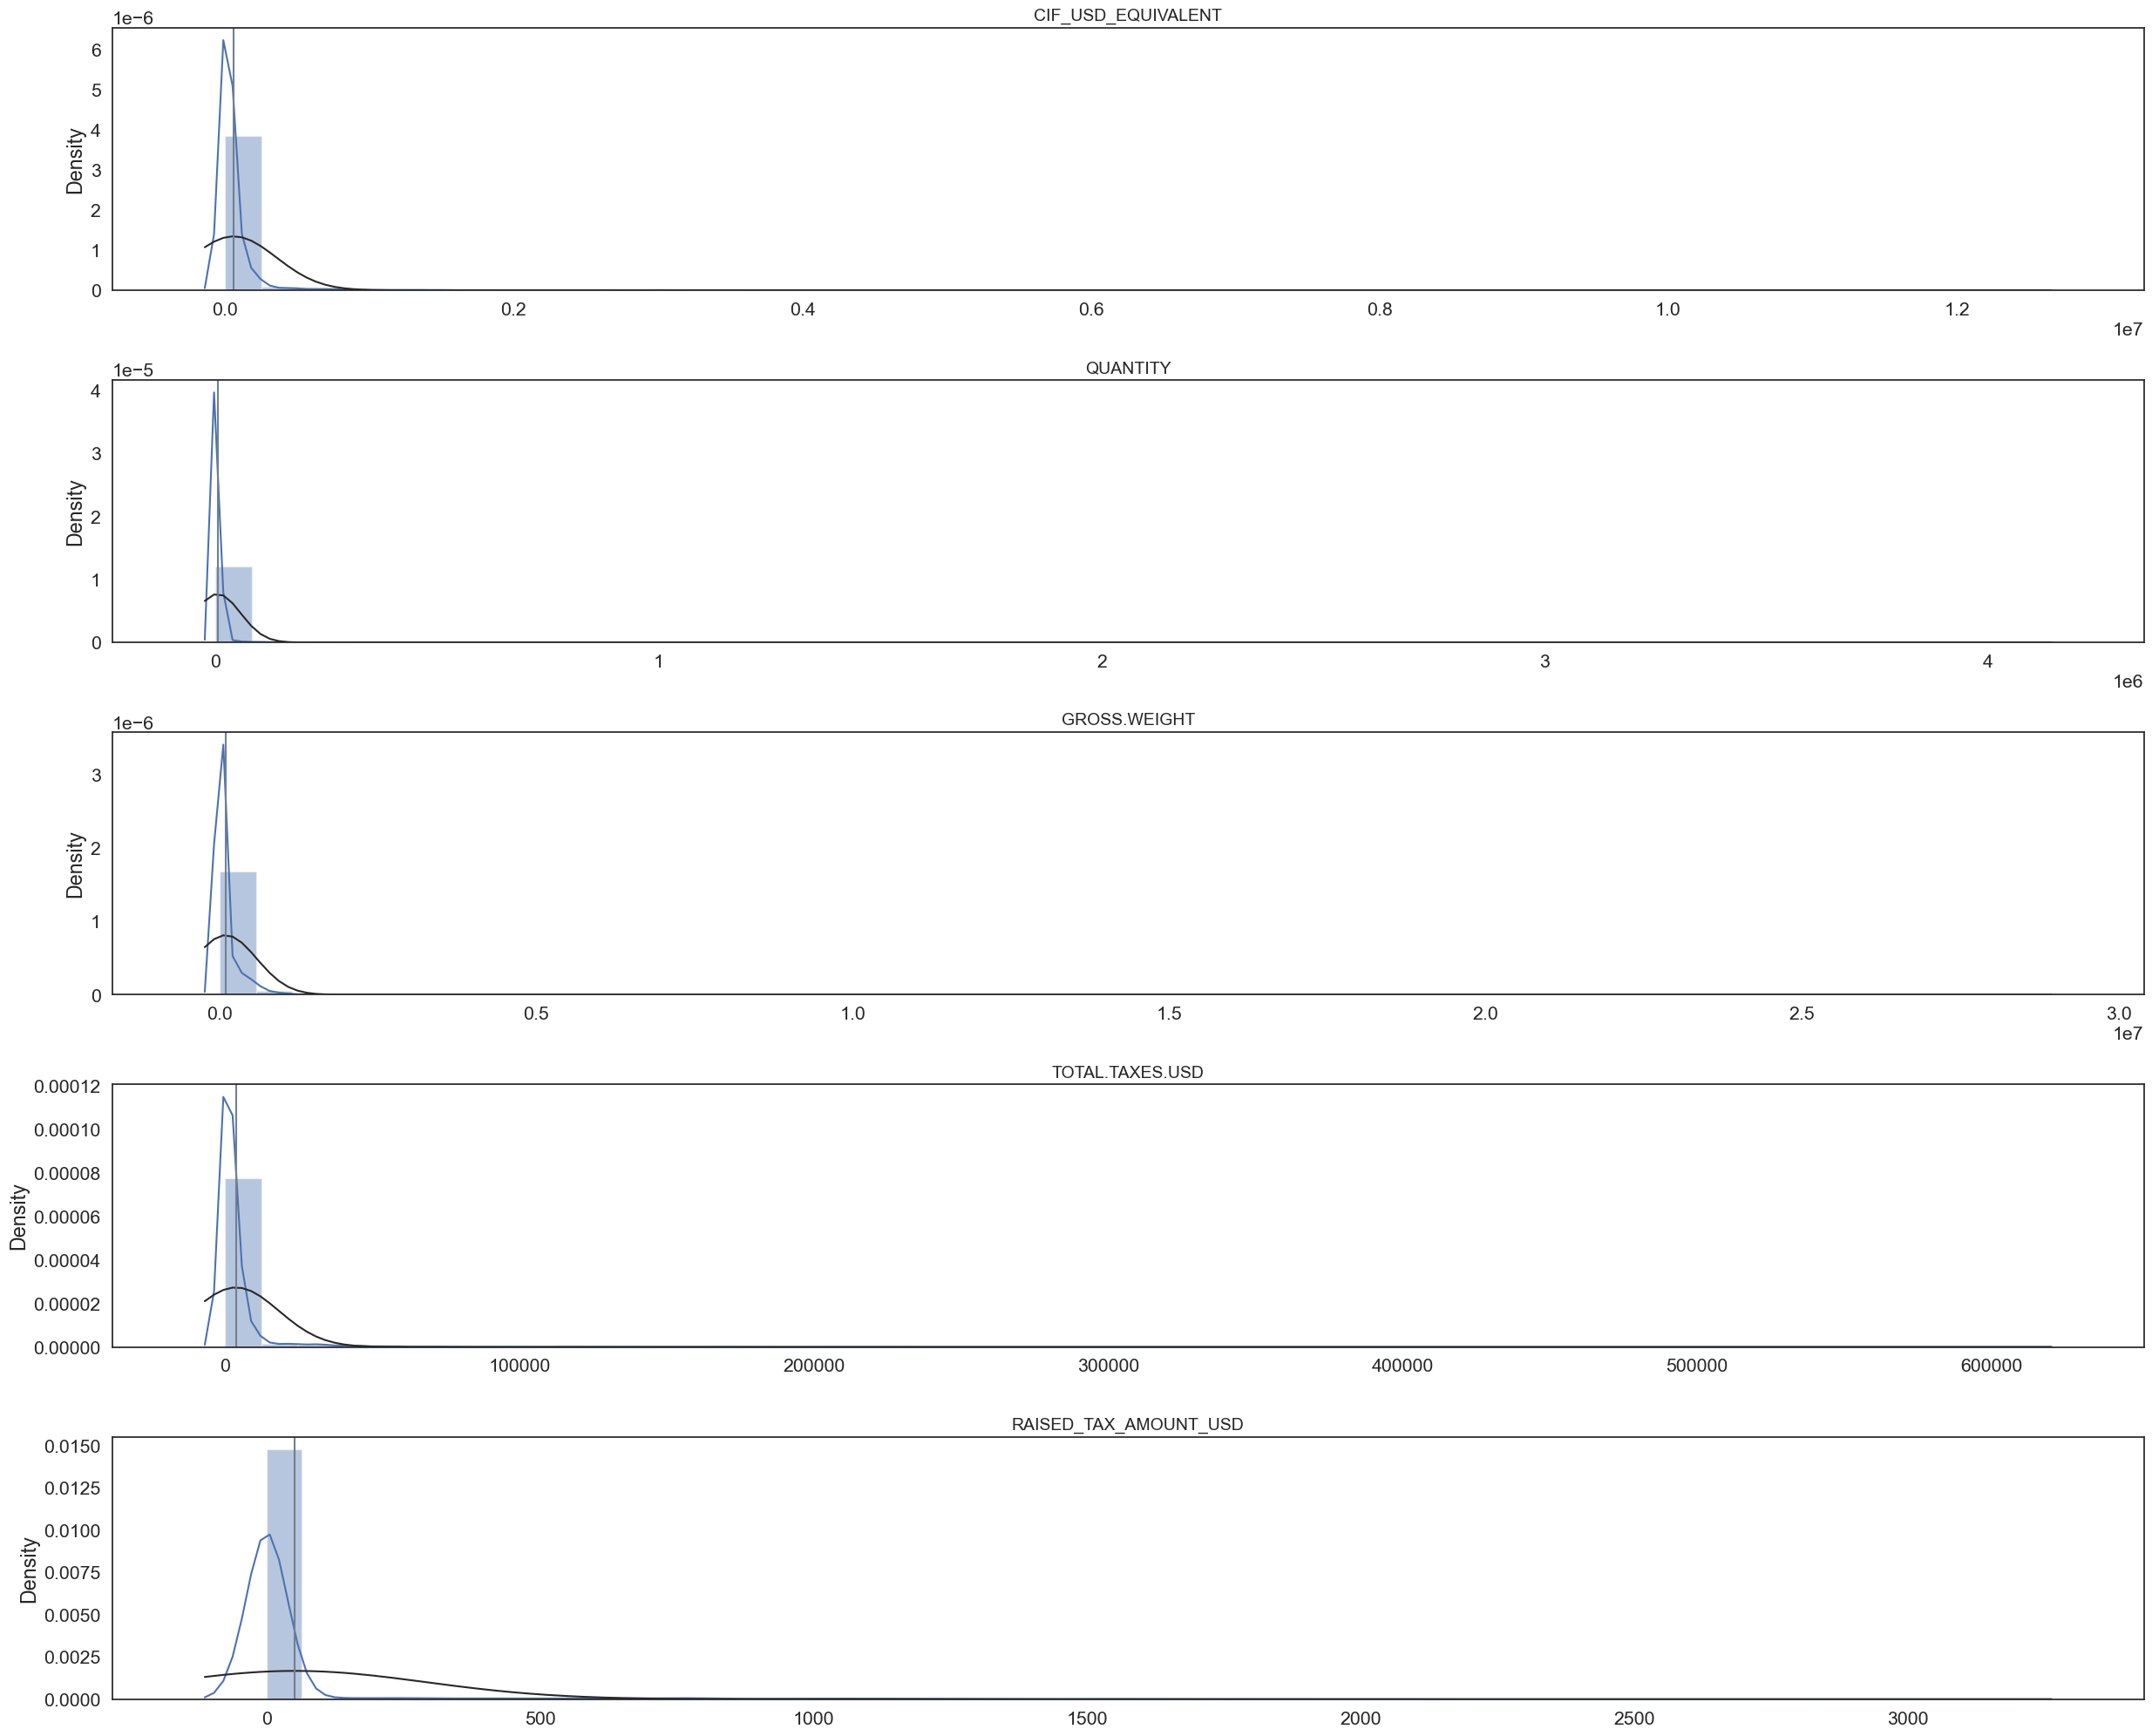

In [20]:
plot_numeric(df_eda, numeric, 10000)

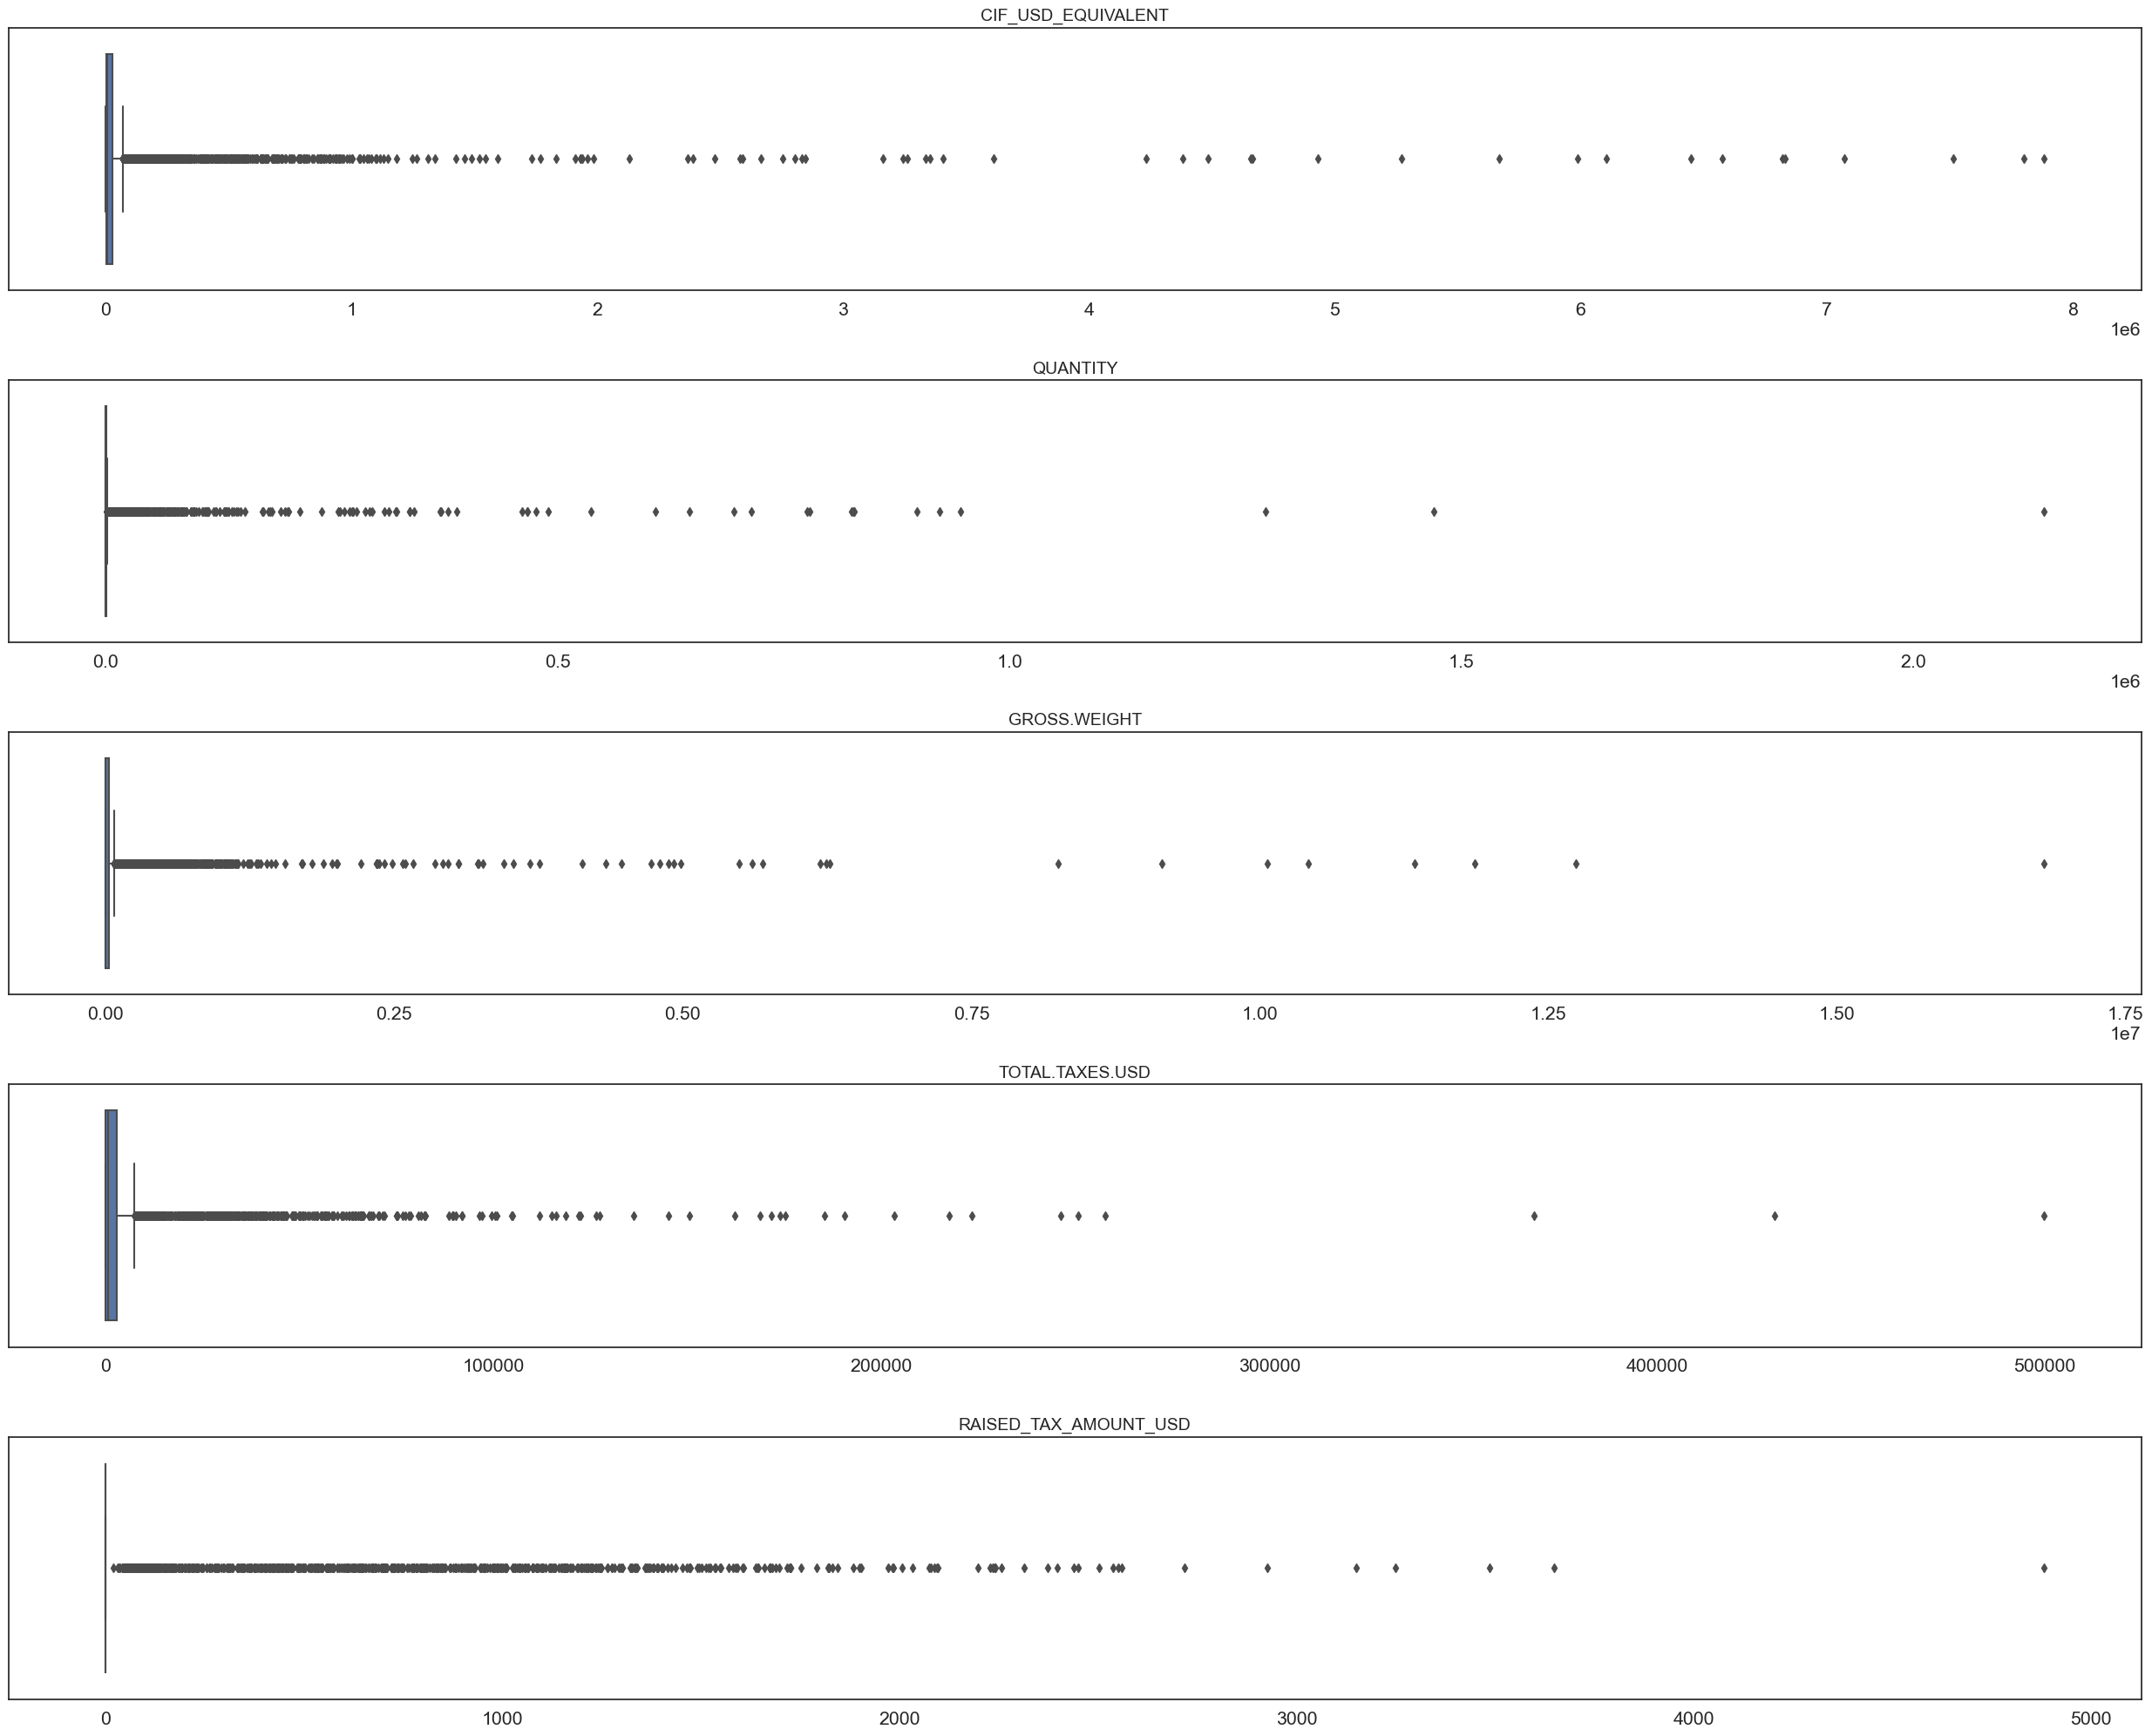

In [21]:
plot_numeric(df_eda, numeric, plot_type='box', n=10000)

**Observations**:

> Numeric variables (as float type), show that the distributions need to be analyzed using transformations.

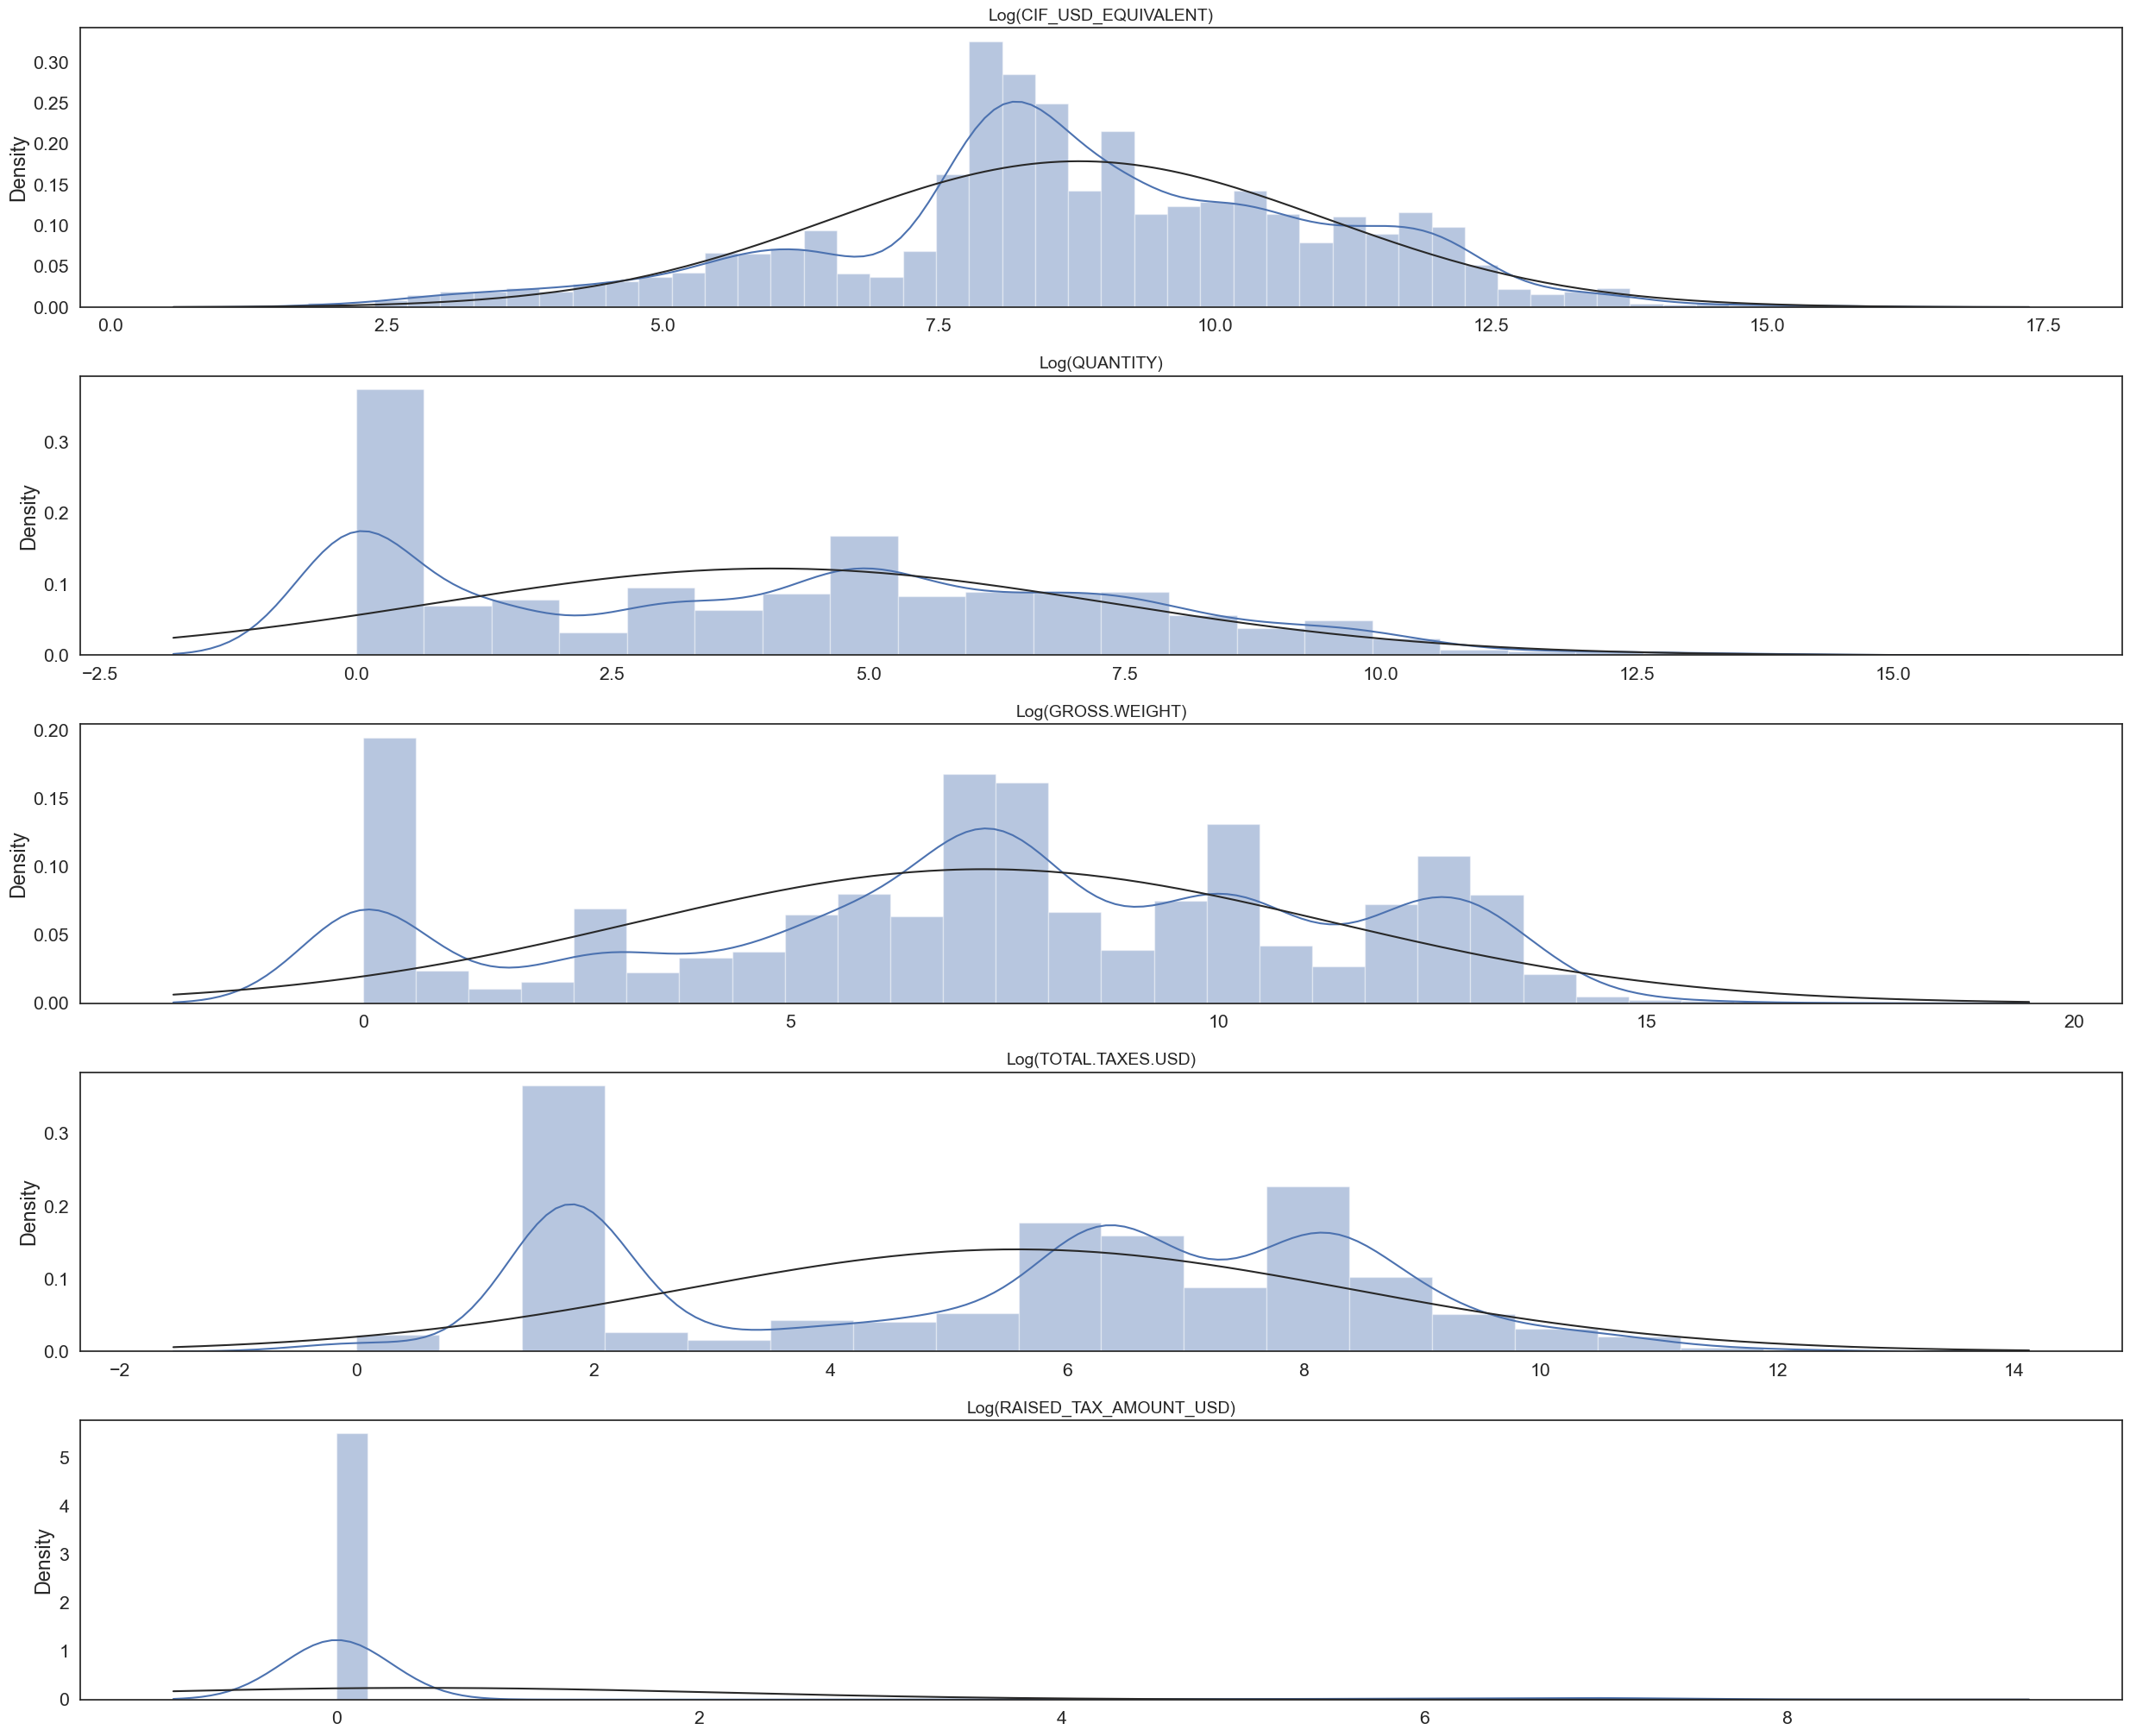

In [22]:
plot_numeric(df_eda, numeric, num_type='log', plot_type='dist', n=5000)

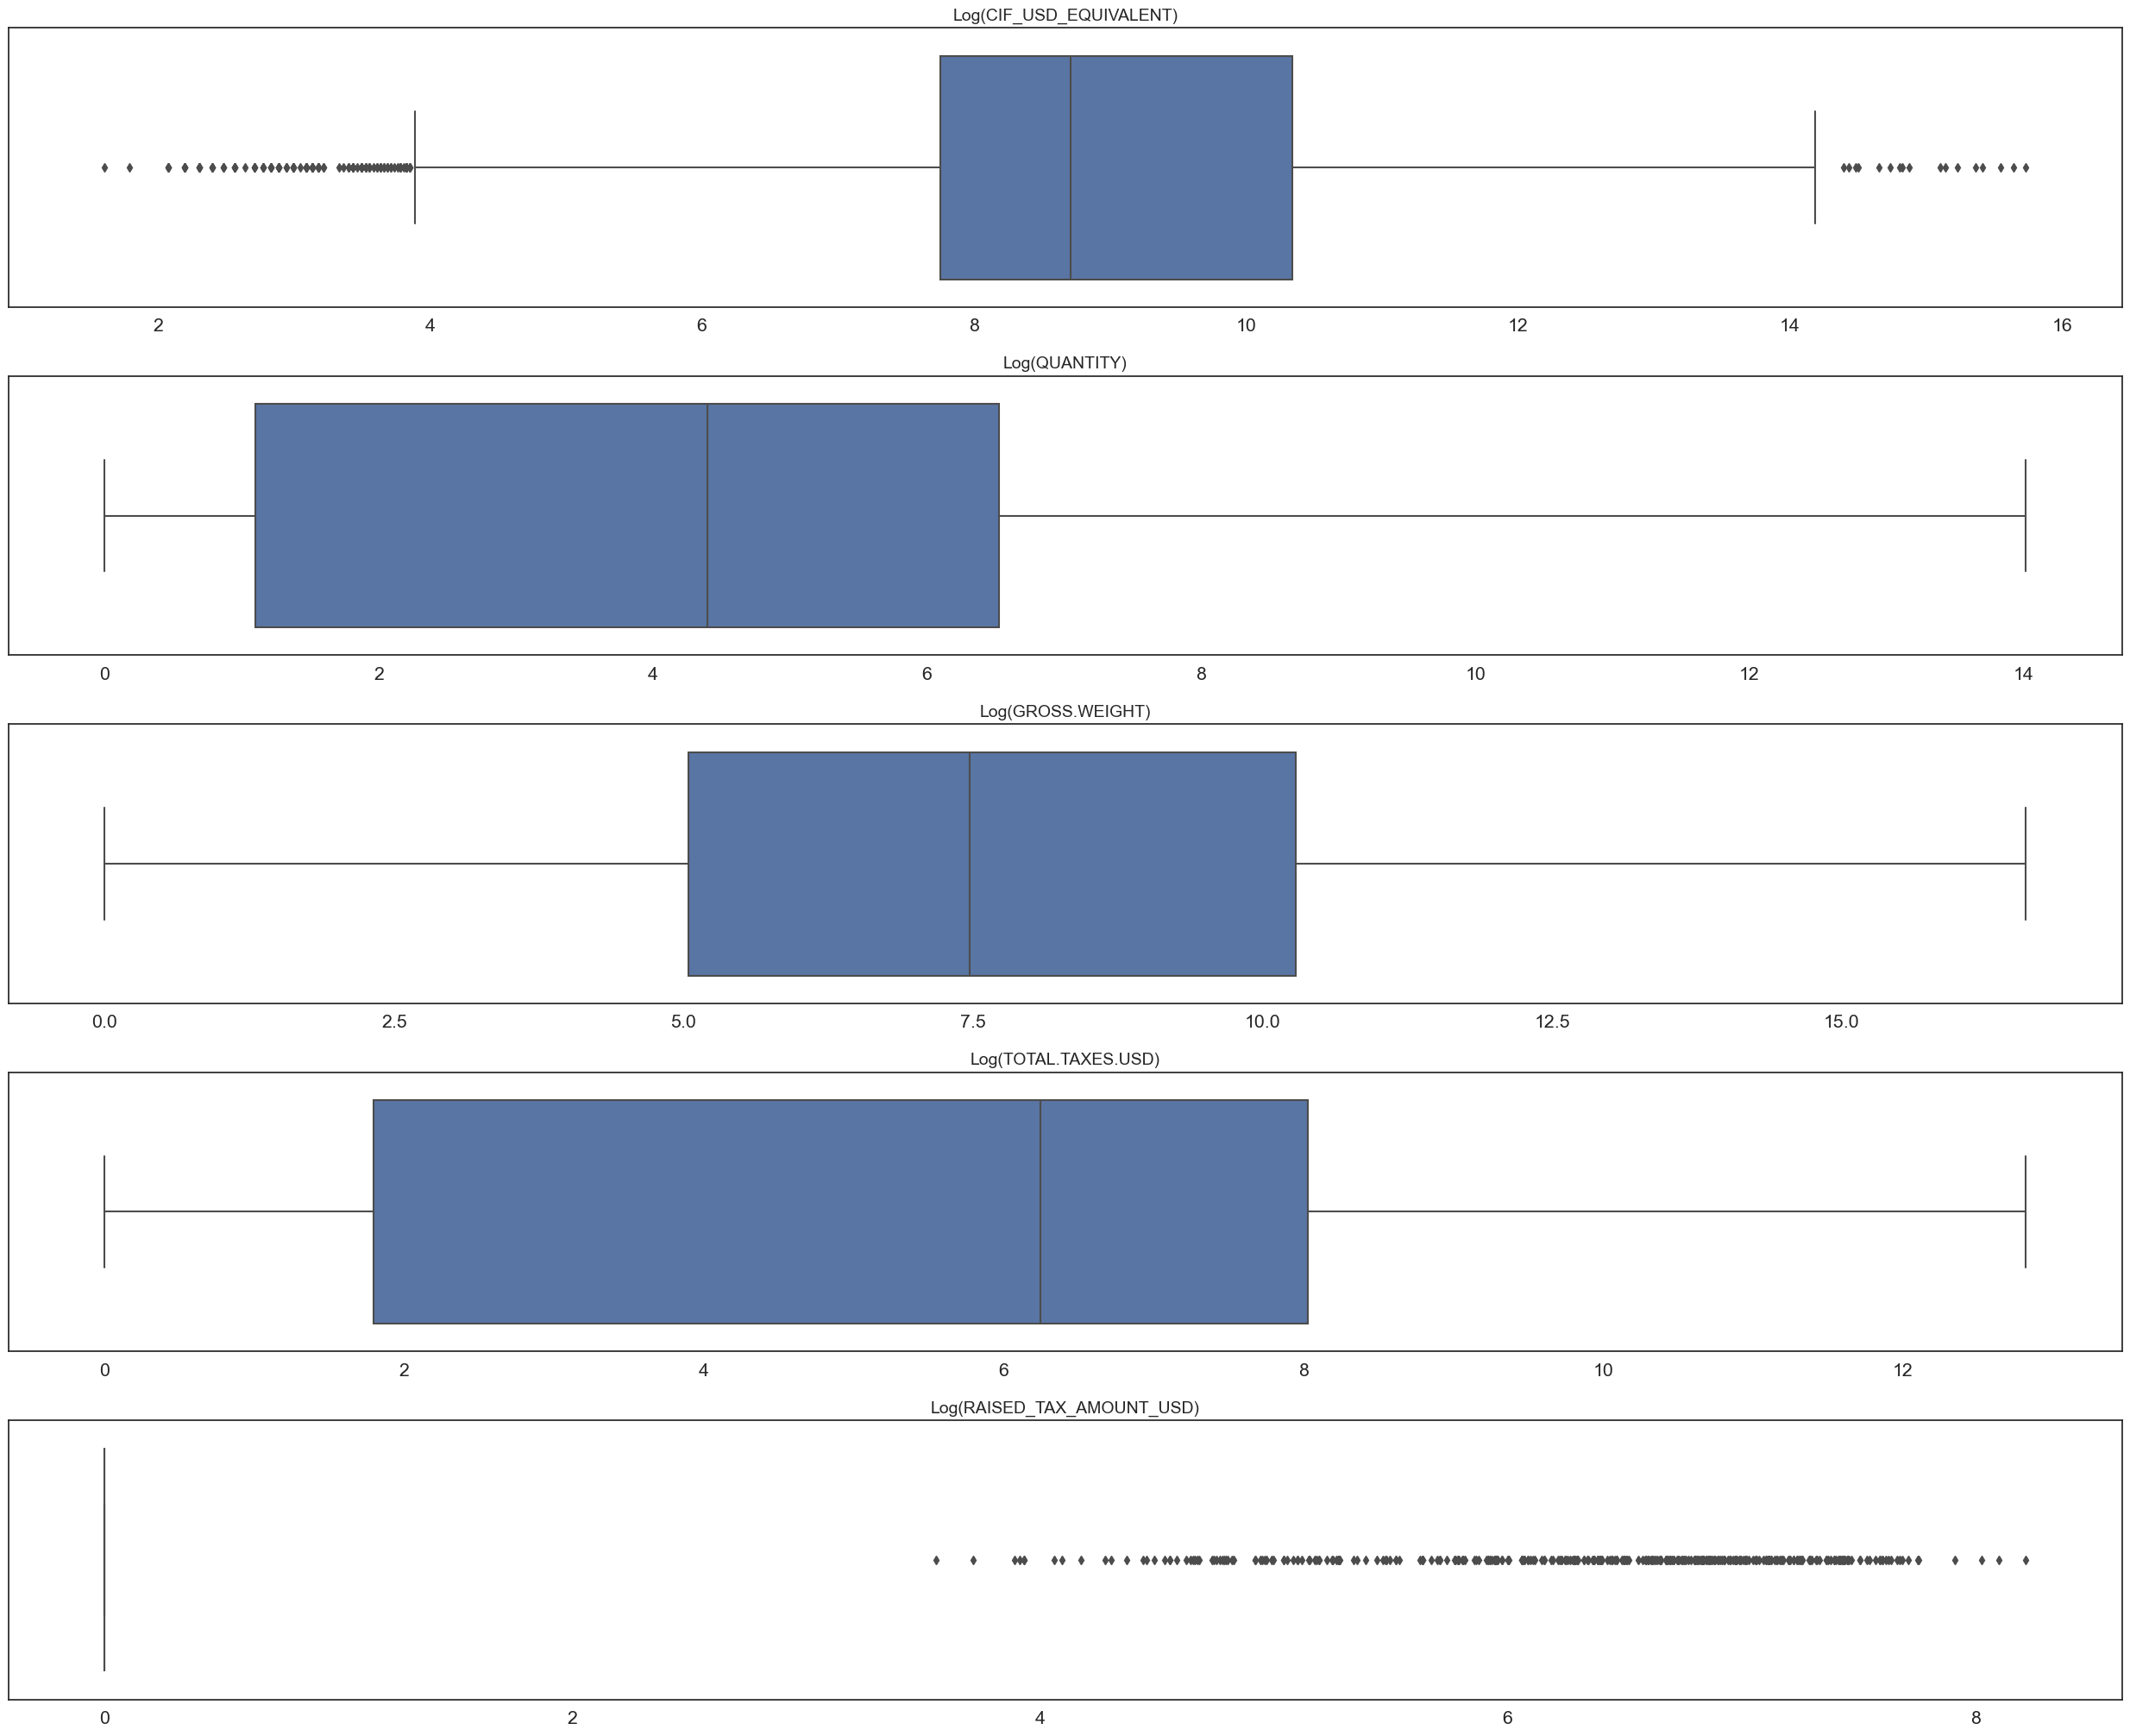

In [23]:
plot_numeric(df_eda, numeric, num_type='log', plot_type='box', n=5000)

## Detecting outliers

IQR method

In [24]:
def detect_outliers_iqr(data, IQR_fact):
    """
    Detect outliers in a numeric dataset using the Interquartile Range (IQR) method.

    Parameters:
    - data (list or array-like): Numeric data for outlier detection.
    - IQR_fact (float): Multiplicative factor for determining the IQR bounds.

    Returns:
    - outliers (list): List of outlier values.
    """
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(IQR_fact*IQR)
    upr_bound = q3+(IQR_fact*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code

def evaluating_outliers(data, numeric, IQR_fact=1.5):
    """
    Evaluate the count and rate of outliers for each numeric variable in a dataset.

    Parameters:
    - data (DataFrame): Input dataset.
    - numeric (list): List of numeric column names to evaluate outliers.
    - IQR_fact (float, optional): Multiplicative factor for determining the IQR bounds. Default is 1.5.

    Returns:
    - df_outliers (DataFrame): DataFrame with columns 'count' and 'rate' for each numeric variable.
    """    
    data_tmp = data.copy()

    count_list = []
    rate_list = []

    for col in numeric:
        outliers_tmp = detect_outliers_iqr(data_tmp[col], IQR_fact)
        count_list.append(len(outliers_tmp))
        rate_list.append(100 * (len(outliers_tmp))/len(data_tmp[col].notnull()))
    
    df_outliers = pd.DataFrame(
        {'count': count_list,
         'rate': rate_list},
         index = numeric)

    return df_outliers


In [25]:
numeric

['CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'RAISED_TAX_AMOUNT_USD']

In [26]:
df_outliers = evaluating_outliers(df_original, numeric, IQR_fact=3)

df_outliers.sort_values(by='rate', ascending=False)

count  rate
GROSS.WEIGHT           34727 17.36
QUANTITY               25026 12.51
CIF_USD_EQUIVALENT     22464 11.23
RAISED_TAX_AMOUNT_USD  14370  7.18
TOTAL.TAXES.USD        10485  5.24

**Observations:**

> To deal with these outliers, Log Transformation and Quantile based capping (over 95%) seem to be reasonable options.

> Since Log transformation prevents loss of information, it is selected over the capping.

## Multivariable Analysis

### Categorical

#### Relation with the target

Chi-square test is used to check the significance of the relationship between the categorical variables and the target:

> H0: no association between the category and the target

> H1: significant association between the category and the target

In [27]:
from scipy.stats import chi2_contingency

for cat_var in categorical:
    contingency_table = pd.crosstab(df_eda[cat_var], df_eda[target[0]])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    # print(contingency_table)
    print(f'\nChi-square test for {cat_var} vs. Target:')
    print(f'Chi2 value: {chi2}')
    print(f'p-value: {p}')


Chi-square test for OFFICE vs. Target:
Chi2 value: 14955.376729425741
p-value: 0.0

Chi-square test for IMPORTER.TIN vs. Target:
Chi2 value: 60396.55506529336
p-value: 0.0

Chi-square test for TARIFF.CODE vs. Target:
Chi2 value: 43025.766658856264
p-value: 0.0

Chi-square test for ORIGIN.CODE vs. Target:
Chi2 value: 21081.815334330073
p-value: 0.0


**Interpretation**

> p-value close to 0 for the 4 categories in the original dataset, so H0 is rejected. Therefore, there is a significant relation between the variables and the target. 

### Numerical

#### Pairplots

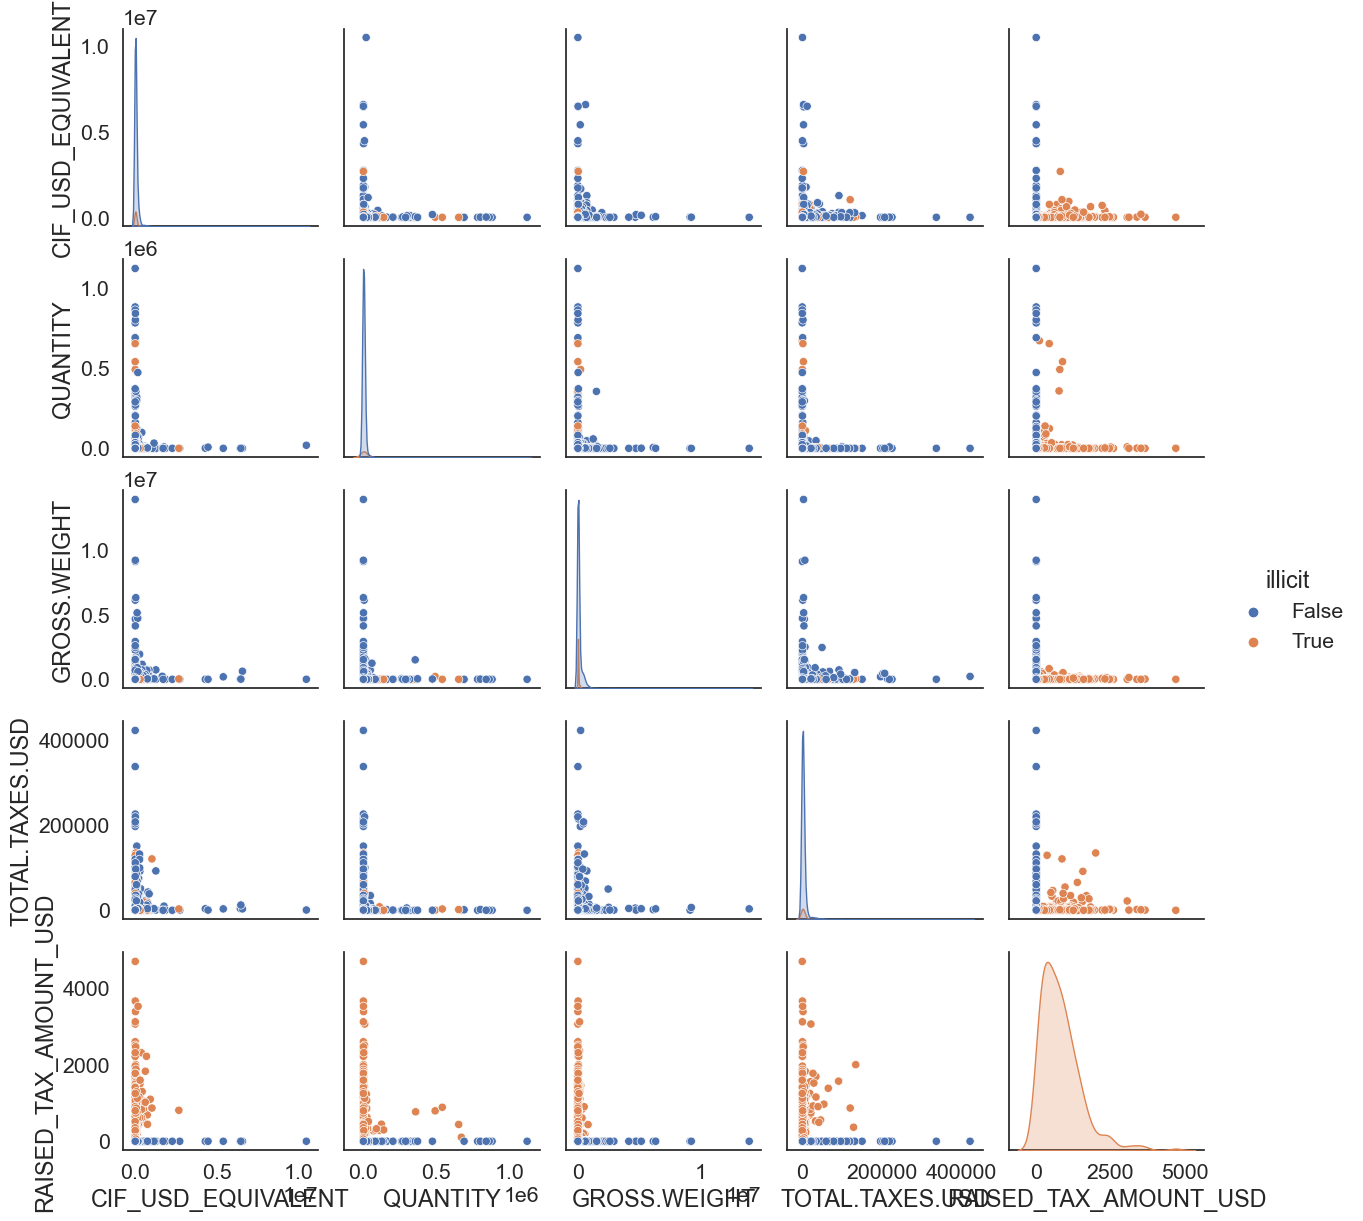

In [28]:
sns.pairplot(df_eda[numeric + target].sample(int(0.02*len(df_eda))), hue='illicit')

Log transformation

In [29]:
log_numeric = []

for var in numeric:
    log_name = 'log_'+var
    df_eda[log_name]=np.log(df_eda[var])
    log_numeric.append(log_name)

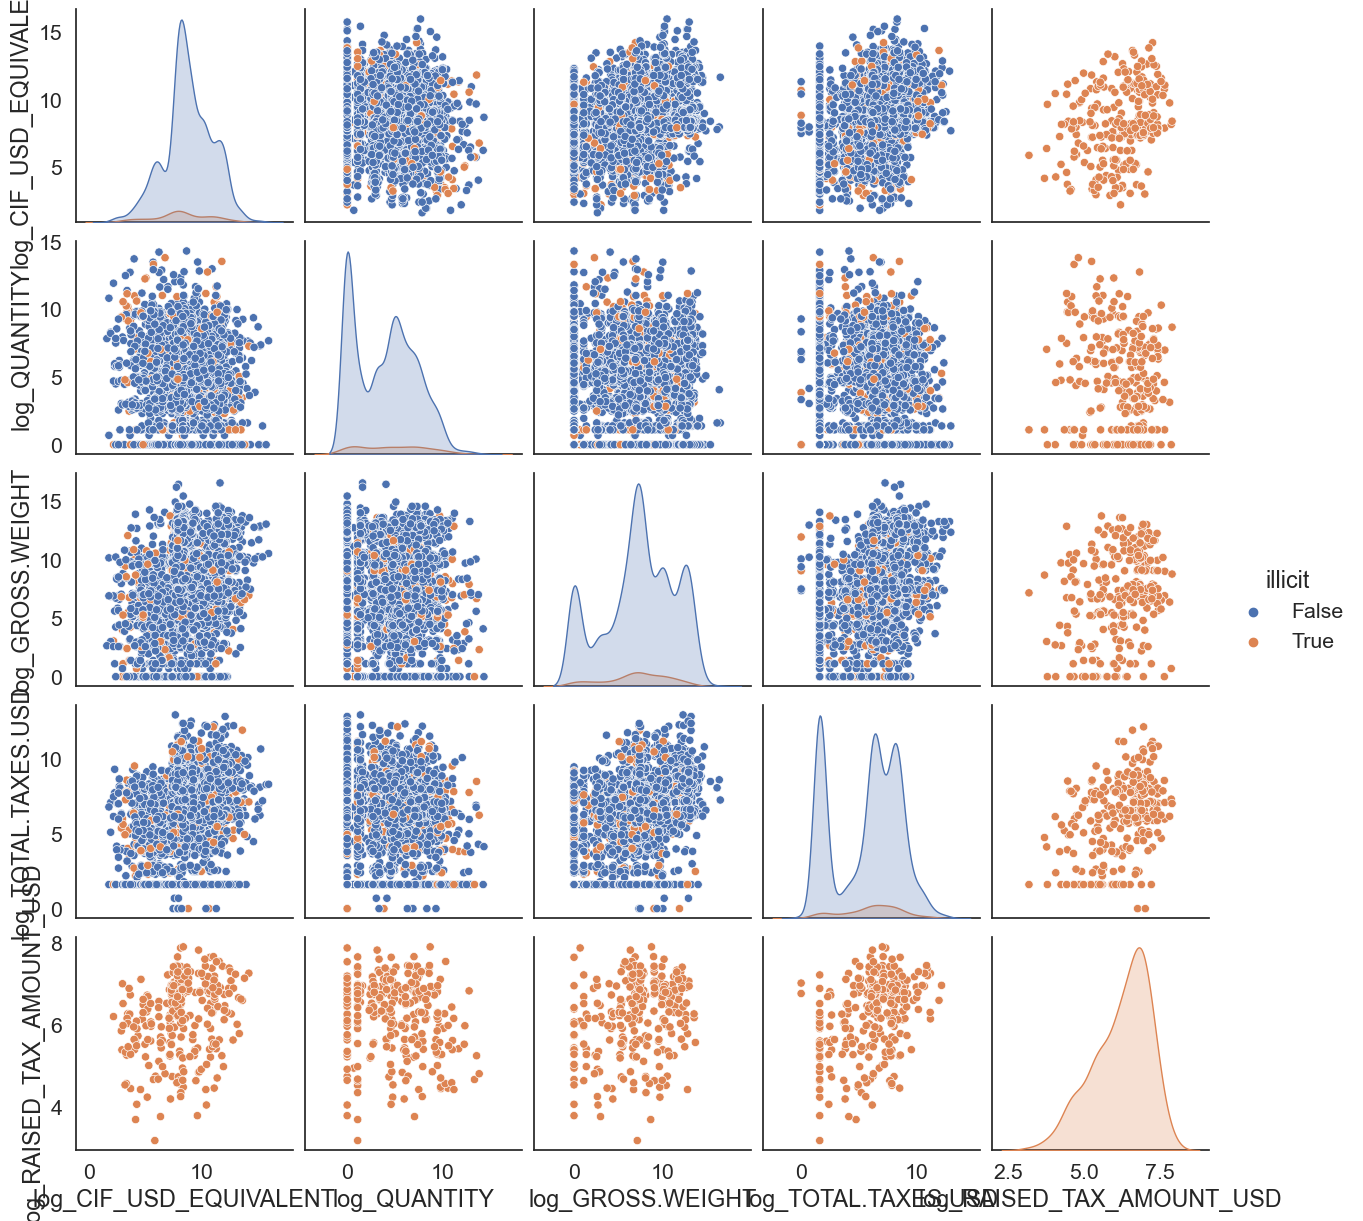

In [30]:
sns.pairplot(df_eda[log_numeric + target].sample(int(0.02*len(df_eda))), hue='illicit')

#### Correlations

<Axes: >

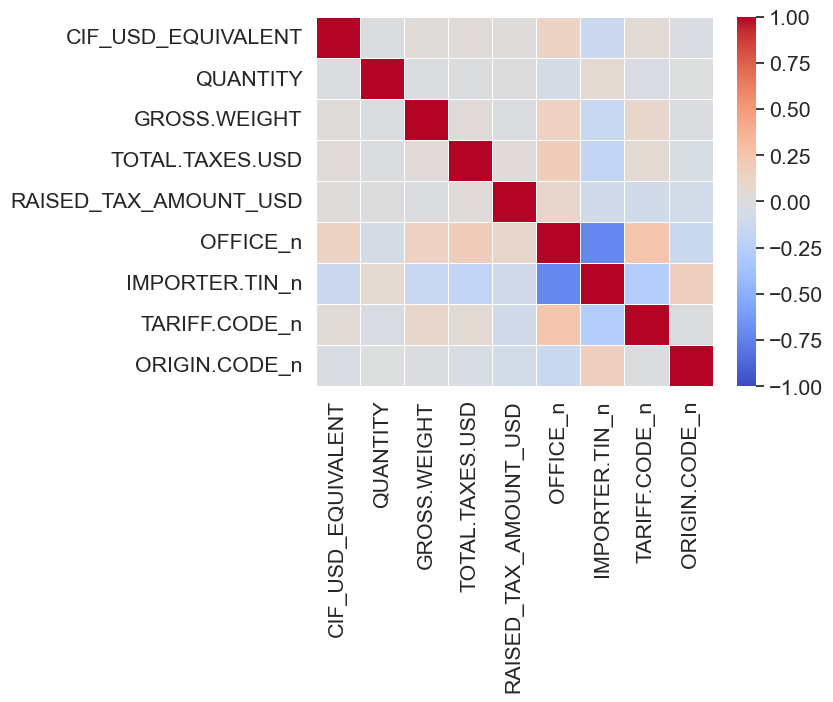

In [31]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder_col = []

# Find the correlation between the transformed numeric data
for column_name in df_eda.columns:
    new_col_name = column_name + '_n'
    if df_eda[column_name].dtype == 'object':  # Check if the column contains categorical data
        df_eda[new_col_name] = encoder.fit_transform(df_eda[column_name])
        encoder_col.append(new_col_name)

encoder_col

corr = df_eda[numeric + encoder_col].corr()

sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths =0.5, annot_kws={'size':10},vmin=-1)

**Interpretation**

> No correlation is apprecieted from the original variables.

> Real data contains several correlated variables that can be grouped analyses and traited. 

> Correlation is used again for feature selection.



_______________________________________________________________________

# Feature Engineering

Experimentation with new variables

In [32]:
df_exp = df_original.copy() # for experimentation with features

## Basic feature engineering

> Unit and Weight price

> Tax rate by price

> Tax rate by quantity

Origin different from precedent country is also processed in real data.


In [33]:
df_exp.loc[:, 'Unitprice'] = df_exp.loc[:,'CIF_USD_EQUIVALENT'] / df_exp.loc[:,'QUANTITY']
df_exp.loc[:, 'WUnitprice'] = df_exp.loc[:,'CIF_USD_EQUIVALENT'] / df_exp.loc[:,'GROSS.WEIGHT']
df_exp.loc[:, 'TaxRatio'] = df_exp.loc[:,'TOTAL.TAXES.USD'] / df_exp.loc[:,'CIF_USD_EQUIVALENT']
df_exp.loc[:, 'TaxUnitquantity'] = df_exp.loc[:,'TOTAL.TAXES.USD'] / df_exp.loc[:,'QUANTITY']

In [34]:
df_exp.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit  Unitprice  WUnitprice  TaxRatio  \
0                   0.00    False  172710.00        6.06      0.02   
1                   0.00    False    7450.00        0.04      0.07   
2                   0.00    False    2684.00        0.01      2.13   
3                   0.00    False       3.67        0.28      0.43   
4                   0.00    False       0.40        1.42      0.21   

   TaxUnitquantity  
0          3492.00  
1           503.00  
2          5706.00  
3             1.58  
4             0.08

## Activity level and stats information from codes

> Activity level of OFFICES and OPERATORS and COUNTRIES 

> Unitary variables analysis per TARIFF CODE and its clustering

For real data, it was possible to process the period/time of activity for brokers and importers.

### Activity level

In [35]:
activity_counts_dict = {}

for var in ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']:
            activity_counts_dict[var] = df_exp[var].value_counts().reset_index()
            activity_counts_dict[var].columns = [var, f'{var}_act']

for var in ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']:
    df_exp = pd.merge(df_exp, activity_counts_dict[var], on=var, how='left')
    df_exp[f'{var}_act_Q'] = pd.qcut(df_exp[f'{var}_act'], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')

In [36]:
activity_counts_dict

{'OFFICE':        OFFICE  OFFICE_act
 0    OFFICE51       37425
 1    OFFICE59       18602
 2   OFFICE168       14567
 3   OFFICE187       12148
 4   OFFICE127       11054
 ..        ...         ...
 68  OFFICE233         251
 69  OFFICE101         244
 70  OFFICE252         243
 71  OFFICE117         242
 72  OFFICE234         230
 
 [73 rows x 2 columns],
 'IMPORTER.TIN':       IMPORTER.TIN  IMPORTER.TIN_act
 0        IMPO19420              1272
 1        IMPO11284              1217
 2        IMP826164              1087
 3        IMPO19469              1005
 4        IMP173637               908
 ...            ...               ...
 15343    IMP119502                 1
 15344    IMP814805                 1
 15345    IMP504119                 1
 15346    IMP422908                 1
 15347    IMPO14910                 1
 
 [15348 rows x 2 columns],
 'ORIGIN.CODE':     ORIGIN.CODE  ORIGIN.CODE_act
 0      CNTRY680            34461
 1      CNTRY994            28635
 2      CNTRY376      

In [37]:
df_exp.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit  Unitprice  WUnitprice  TaxRatio  \
0                   0.00    False  172710.00        6.06      0.02   
1                   0.00    False    7450.00        0.04      0.07   
2                   0.00    False    2684.00        0.01      2.13   
3                   0.00    False       3.67        0.28      0.43   
4                   0.00    False       0.40        1.42      0.21   

   TaxUnitquantity  OFFICE_act  OFFICE_act_Q  IMPORTER.TIN_act  \
0          3492.00        7855             1               283   
1           503.00        2454             0                 4   
2          5706.00       18602             2               297   
3             1.58        7855             1                69   
4             0.08       18602             2                36   

   IMPORTER.TIN_act_Q  ORIGIN.CODE_act  ORIGIN.CODE_act_Q  
0                   2            34461                  3  
1                   0            22274                  2  
2                   2            34461                  3  
3                   1             3648                  0  
4                   1            19503                  1

### Stats information from codes

HSO6 stast description regarding

> unit price

> weight price

> tax rate

In [39]:
# variable preparation

## save stats information?
save = True

## HS06 column creation
df_exp['HS06'] = df_exp['TARIFF.CODE'].str[:6]

basic_new_vars = ['Unitprice', 'WUnitprice', 'TaxRatio']

## inter-Quartile-Range factor
IQR_fact = 1.5

# function to get stats description by code

def stats_analyze(df, code_col, col_to_process, IQR_fact = IQR_fact):
    """
    Analyzes and generates descriptive statistics for a specific column in a DataFrame
    grouped by unique values in another column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data.
    - code_col (str): The column name used for grouping and analysis.
    - col_to_process (str): The column for which statistics will be generated.
    - IQR_fact (float): The factor used to calculate the Interquartile Range (IQR) for outlier detection.
                       Default is 1.5.

    Returns:
    - pd.DataFrame: A DataFrame containing descriptive statistics for the specified column grouped by unique values
                    in the 'code_col' column.

    Example:
    df_HS06_Unitprice = stats_analyze(df_exp, code_col='HS06', col_to_process='Unitprice')

    """
    codes_used = list(df[code_col].unique())
    # stats description per each HS06 regarding var
    dic_code_stats = {}

    for code in codes_used:
        df_code = df[col_to_process].loc[df[code_col] == code]
        col_stats = df_code.describe()
        col_stats['p10'] = df_code.quantile(0.1)
        col_stats['p90'] = df_code.quantile(0.9)
        dic_code_stats[code] = col_stats

    # HS06 var description
    df_code_stats = pd.DataFrame(dic_code_stats).T
    # IQR
    df_code_stats.loc[:, 'IQR'] = df_code_stats.loc[:,'75%'] - df_code_stats.loc[:,'25%']
    # upper limit
    df_code_stats.loc[:, f'3Q+{str(IQR_fact)}*IQR'] = df_code_stats.loc[:,'75%'] + IQR_fact*df_code_stats.loc[:, 'IQR']
    # # lower limit # this column is not useful because of the chi2 distribution of this variables
    # df_code_stats.loc[:, f'1Q-{str(IQR_fact)}*IQR'] = df_code_stats.loc[:,'25%'] - IQR_fact*df_code_stats.loc[:, 'IQR']

    # imputing missing std for cases with not enough
    df_code_stats.fillna(0, inplace=True)

    return df_code_stats

# stat description dfs per code in new variables

df_HS06_Unitprice = stats_analyze(df_exp, code_col = 'HS06', col_to_process = 'Unitprice')
df_HS06_WUnitprice = stats_analyze(df_exp, code_col = 'HS06', col_to_process = 'WUnitprice')
df_HS06_TaxRatio = stats_analyze(df_exp, code_col = 'HS06', col_to_process = 'TaxRatio')

## renaming the columns to merge the df with stats information
for var in basic_new_vars:
    new_col_name = {
        # 'count': var+'_count',
        'mean': var+'_mean',
        'std': var+'_std',
        'min': var+'_min',
        '25%': var+'_p25',
        '50%': var+'_p50',
        '75%': var+'_p75',
        'max': var+'_max',
        'p10': var+'_p10',
        'p90': var+'_p90',
        f'3Q+{str(IQR_fact)}*IQR': var+'_'+f'3Q+{str(IQR_fact)}*IQR',
        f'1Q-{str(IQR_fact)}*IQR': var+'_'+f'1Q-{str(IQR_fact)}*IQR',
    }
    if var == 'Unitprice':
        df_HS06_Unitprice.rename(columns=new_col_name, inplace=True)
    elif var == 'WUnitprice':
        df_HS06_WUnitprice.rename(columns=new_col_name, inplace=True)
    else:
        df_HS06_TaxRatio.rename(columns=new_col_name, inplace=True)

# merging all stats information in one dataframe

df_HS06_stats = pd.merge(df_HS06_Unitprice, df_HS06_WUnitprice.drop(columns='count'), left_index=True, right_index=True)
df_HS06_stats = pd.merge(df_HS06_stats, df_HS06_TaxRatio.drop(columns='count'), left_index=True, right_index=True)

del df_HS06_Unitprice, df_HS06_WUnitprice, df_HS06_TaxRatio

## sorting and saving the HS06 stats information
df_HS06_stats.sort_index(inplace=True)

file_HS06_stats = os.path.join(OUTPUT_RESULTS,'HS06_stats.csv')

if save:
    df_HS06_stats.to_csv(file_HS06_stats)

# reading results

df_HS06_stats = pd.read_csv(file_HS06_stats, index_col=0)
df_HS06_stats.index = df_HS06_stats.index.astype(str)

In [ ]:
df_HS06_stats.head(5)

count  Unitprice_mean  Unitprice_std  Unitprice_min  Unitprice_p25  \
100110  11.00        40113.37       89287.01           1.05          50.35   
100119  31.00          175.01         690.83           0.00           0.37   
100190  49.00        13583.86       35791.84           0.48           7.78   
100199   4.00         5848.37       10412.24           0.05           1.03   
100390   6.00         2571.42        5905.41           0.07           3.53   

        Unitprice_p50  Unitprice_p75  Unitprice_max  Unitprice_p10  \
100110        1104.00       21204.58      292710.00           1.18   
100119           5.02          25.98        3830.00           0.08   
100190          89.22        3808.00      169626.00           1.66   
100199         995.05        6842.38       21403.33           0.44   
100390          14.72         596.33       14609.00           1.72   

        Unitprice_p90    IQR_x  Unitprice_3Q+1.5*IQR  WUnitprice_mean  \
100110      102203.00 21154.23              52935.91           181.49   
100119         185.35    25.62                 64.40           159.69   
100190       46309.00  3800.22               9508.34            76.27   
100199       15578.95  6841.35              17104.41          7541.13   
100390        7697.81   592.80               1485.53          2436.22   

        WUnitprice_std  WUnitprice_min  WUnitprice_p25  WUnitprice_p50  \
100110          464.32            0.35            1.55            4.54   
100119          691.44            0.00            0.02            0.51   
100190          317.43            0.02            0.34            1.67   
100199        14860.63            0.65           11.41          166.44   
100390         5912.09            0.00            0.06            9.69   

        WUnitprice_p75  WUnitprice_max  WUnitprice_p10  WUnitprice_p90  \
100110           30.27         1540.58            1.04          377.86   
100119           12.16         3830.00            0.00          124.59   
100190           18.68         2181.67            0.14          103.40   
100199         7696.15        29831.00            4.95        20977.06   
100390           75.23        14504.00            0.00         7298.96   

         IQR_y  WUnitprice_3Q+1.5*IQR  TaxRatio_mean  TaxRatio_std  \
100110   28.72                  73.35           1.16          2.62   
100119   12.14                  30.37          43.62        166.12   
100190   18.35                  46.20           0.72          2.97   
100199 7684.74               19223.27           2.38          4.09   
100390   75.16                 187.97           0.27          0.66   

        TaxRatio_min  TaxRatio_p25  TaxRatio_p50  TaxRatio_p75  TaxRatio_max  \
100110          0.00          0.01          0.34          0.57          8.87   
100119          0.00          0.01          0.17          2.33        862.75   
100190          0.00          0.01          0.07          0.32         20.80   
100199          0.00          0.03          0.52          2.87          8.47   
100390          0.00          0.00          0.00          0.00          1.62   

        TaxRatio_p10  TaxRatio_p90  IQR  TaxRatio_3Q+1.5*IQR  
100110          0.00          1.88 0.57                 1.43  
100119          0.00         27.71 2.32                 5.80  
100190          0.00          1.19 0.31                 0.78  
100199          0.01          6.23 2.84                 7.13  
100390          0.00          0.81 0.00                 0.01

## Clusters from stats information

Creating clusters for HS06 codes regarding its stats information

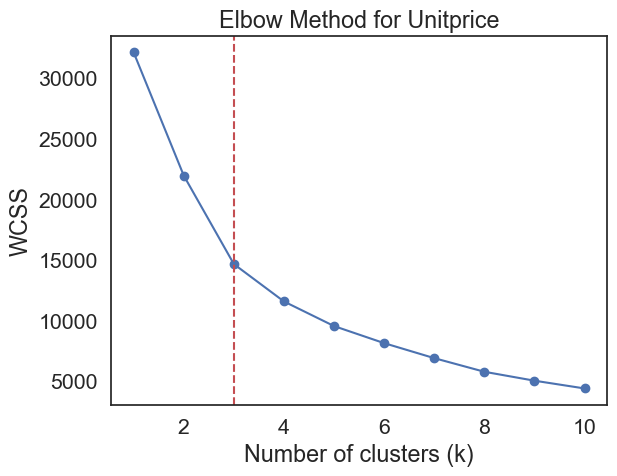

k preselected: 3


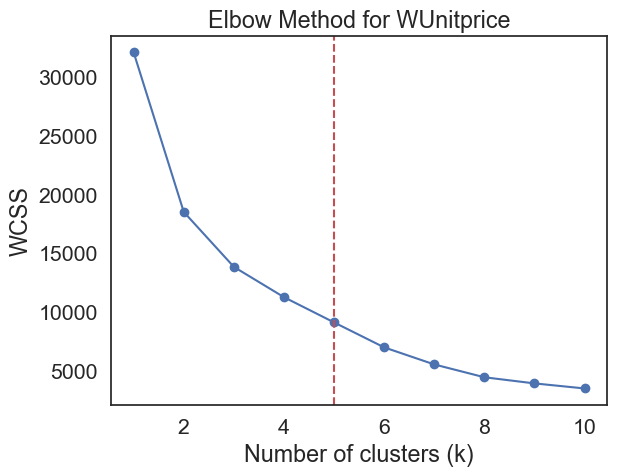

k preselected: 5


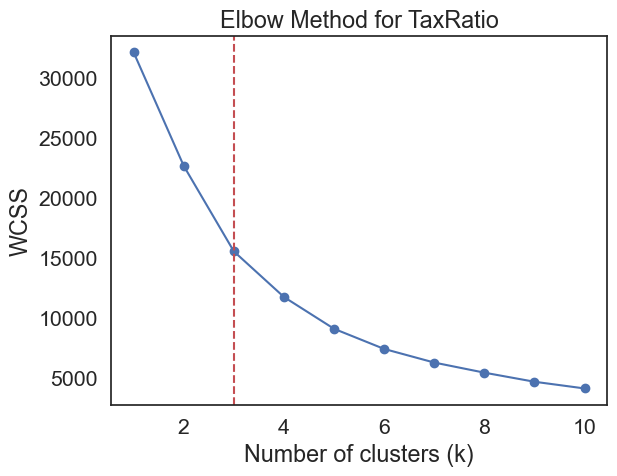

k preselected: 3


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# extract the features for clustering
unitprice_cols = [col for col in df_HS06_stats.columns if col.startswith('Unitprice')]
wunitprice_cols = [col for col in df_HS06_stats.columns if col.startswith('WUnitprice')]
taxratio_cols = [col for col in df_HS06_stats.columns if col.startswith('TaxRatio')]

def elbow_method(df, cols, variable):
    features = df[cols]
    features_scaled = StandardScaler().fit_transform(features)

    k_presel = 1
    wcss = []  # Within-cluster sum of squares
    wcss_rel = []

    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(features_scaled)
        wcss.append(kmeans.inertia_)
        
        # pre-selection of k
        wcss_rel.append(kmeans.inertia_/wcss[0])
        if i>2:
            diff = ((wcss_rel[i-3]-wcss_rel[i-2])/(wcss_rel[i-2]-wcss_rel[i-1]))
            if (k_presel==1) & (diff < 1.5):
                k_presel = i


    # Plot the Elbow method graph
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f'Elbow Method for {variable}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.axvline(x=k_presel, color='r', linestyle='--', label=f'k_presel: {k_presel}')
    plt.show()
    print(f'k preselected: {k_presel}')

elbow_method(df_HS06_stats, unitprice_cols, 'Unitprice')
elbow_method(df_HS06_stats, wunitprice_cols, 'WUnitprice')
elbow_method(df_HS06_stats, taxratio_cols, 'TaxRatio')

In [ ]:
# perform KMeans clustering with the chosen number of clusters

# number of cluster to create
# ignoring preselected k
k = 5

def clustering(df, cols, prefix, k=k):
    
    features = df[cols]
    features_scaled = StandardScaler().fit_transform(features)

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)

    df[f'{prefix}_cluster'] = kmeans.fit_predict(features_scaled)


clustering(df_HS06_stats, unitprice_cols, 'Unitprice')
clustering(df_HS06_stats, wunitprice_cols, 'WUnitprice')
clustering(df_HS06_stats, taxratio_cols, 'TaxRatio')

In [ ]:
df_HS06_stats.head(5)

count  Unitprice_mean  Unitprice_std  Unitprice_min  Unitprice_p25  \
100110  11.00        40113.37       89287.01           1.05          50.35   
100119  31.00          175.01         690.83           0.00           0.37   
100190  49.00        13583.86       35791.84           0.48           7.78   
100199   4.00         5848.37       10412.24           0.05           1.03   
100390   6.00         2571.42        5905.41           0.07           3.53   

        Unitprice_p50  Unitprice_p75  Unitprice_max  Unitprice_p10  \
100110        1104.00       21204.58      292710.00           1.18   
100119           5.02          25.98        3830.00           0.08   
100190          89.22        3808.00      169626.00           1.66   
100199         995.05        6842.38       21403.33           0.44   
100390          14.72         596.33       14609.00           1.72   

        Unitprice_p90    IQR_x  Unitprice_3Q+1.5*IQR  WUnitprice_mean  \
100110      102203.00 21154.23              52935.91           181.49   
100119         185.35    25.62                 64.40           159.69   
100190       46309.00  3800.22               9508.34            76.27   
100199       15578.95  6841.35              17104.41          7541.13   
100390        7697.81   592.80               1485.53          2436.22   

        WUnitprice_std  WUnitprice_min  WUnitprice_p25  WUnitprice_p50  \
100110          464.32            0.35            1.55            4.54   
100119          691.44            0.00            0.02            0.51   
100190          317.43            0.02            0.34            1.67   
100199        14860.63            0.65           11.41          166.44   
100390         5912.09            0.00            0.06            9.69   

        WUnitprice_p75  WUnitprice_max  WUnitprice_p10  WUnitprice_p90  \
100110           30.27         1540.58            1.04          377.86   
100119           12.16         3830.00            0.00          124.59   
100190           18.68         2181.67            0.14          103.40   
100199         7696.15        29831.00            4.95        20977.06   
100390           75.23        14504.00            0.00         7298.96   

         IQR_y  WUnitprice_3Q+1.5*IQR  TaxRatio_mean  TaxRatio_std  \
100110   28.72                  73.35           1.16          2.62   
100119   12.14                  30.37          43.62        166.12   
100190   18.35                  46.20           0.72          2.97   
100199 7684.74               19223.27           2.38          4.09   
100390   75.16                 187.97           0.27          0.66   

        TaxRatio_min  TaxRatio_p25  TaxRatio_p50  TaxRatio_p75  TaxRatio_max  \
100110          0.00          0.01          0.34          0.57          8.87   
100119          0.00          0.01          0.17          2.33        862.75   
100190          0.00          0.01          0.07          0.32         20.80   
100199          0.00          0.03          0.52          2.87          8.47   
100390          0.00          0.00          0.00          0.00          1.62   

        TaxRatio_p10  TaxRatio_p90  IQR  TaxRatio_3Q+1.5*IQR  \
100110          0.00          1.88 0.57                 1.43   
100119          0.00         27.71 2.32                 5.80   
100190          0.00          1.19 0.31                 0.78   
100199          0.01          6.23 2.84                 7.13   
100390          0.00          0.81 0.00                 0.01   

        Unitprice_cluster  WUnitprice_cluster  TaxRatio_cluster  
100110                  4                   0                 0  
100119                  0                   0                 4  
100190                  0                   0                 0  
100199                  0                   0                 0  
100390                  0                   0                 0

Variables to calculate from the merge between HS06 stats and data to process

For each of ['Unitprice', 'WUnitprice', 'TaxRatio']

> Diff against the mean

> Diff against the median

> Under p10

> Over p90

> Over 3Q+1.5*IQR

> Quartil range [0,1,2,3]

> Clusters

Merging with the original

In [ ]:
# merging the data with the stats information

df_exp = df_exp.merge(df_HS06_stats, how='left', left_on='HS06', right_index=True)

# extracting information from HS06 stats
# regarding each item

for var in basic_new_vars:
    # count of occurrences per HS06
    df_exp[f'HS06_activity'] = df_exp['count']
    # difference between the variable and its mean
    df_exp[f'HS06_{var}_diff_mean'] = df_exp[var] - df_exp[f'{var}_mean']
    # difference between the variable and its median
    df_exp[f'HS06_{var}_diff_median'] = df_exp[var] - df_exp[f'{var}_p50']
    # indicating whether the variable is under the 10th percentile
    df_exp[f'HS06_{var}_under_p10'] = df_exp[var] < df_exp[f'{var}_p10']
    # indicating whether the variable is over the 90th percentile
    df_exp[f'HS06_{var}_over_p90'] = df_exp[var] > df_exp[f'{var}_p90']
    # indicating whether the variable is over a calculated threshold based on IQR
    df_exp[f'HS06_{var}_over_f*IQR'] = df_exp[var] > df_exp[f'{var}_3Q+{str(IQR_fact)}*IQR']
    # categorical column ('HS06_{var}_Q') indicating quartile ranges
    df_exp[f'HS06_{var}_Q'] = pd.qcut(df_exp[var], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')

Dropping information from HS06 stats regarding each item

In [ ]:
# to drop
# avoiding the clusters (last 3 columns)
HS06_stats_cols = list(df_HS06_stats.columns)[:-3]

df_exp.drop(columns = HS06_stats_cols, inplace=True)

In [ ]:
df_exp.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit  Unitprice  WUnitprice  TaxRatio  \
0                   0.00    False  172710.00        6.06      0.02   
1                   0.00    False    7450.00        0.04      0.07   
2                   0.00    False    2684.00        0.01      2.13   
3                   0.00    False       3.67        0.28      0.43   
4                   0.00    False       0.40        1.42      0.21   

   TaxUnitquantity  OFFICE_act  OFFICE_act_Q  IMPORTER.TIN_act  \
0          3492.00        7855             1               283   
1           503.00        2454             0                 4   
2          5706.00       18602             2               297   
3             1.58        7855             1                69   
4             0.08       18602             2                36   

   IMPORTER.TIN_act_Q  ORIGIN.CODE_act  ORIGIN.CODE_act_Q    HS06  \
0                   2            34461                  3  870323   
1                   0            22274                  2  870332   
2                   2            34461                  3  870421   
3                   1             3648                  0  390110   
4                   1            19503                  1  851718   

   Unitprice_cluster  WUnitprice_cluster  TaxRatio_cluster  HS06_activity  \
0                  1                   0                 4       14338.00   
1                  1                   4                 0        8352.00   
2                  1                   4                 0        2609.00   
3                  1                   0                 0         160.00   
4                  1                   0                 0        4862.00   

   HS06_Unitprice_diff_mean  HS06_Unitprice_diff_median  \
0                 130975.84                   170516.50   
1                 -27005.34                     7020.82   
2                 -31540.92                     2484.50   
3                 -64385.47                     -497.30   
4                 -42422.43                    -2301.60   

   HS06_Unitprice_under_p10  HS06_Unitprice_over_p90  \
0                     False                     True   
1                     False                    False   
2                     False                    False   
3                     False                    False   
4                      True                    False   

   HS06_Unitprice_over_f*IQR  HS06_Unitprice_Q  HS06_WUnitprice_diff_mean  \
0                       True                 3                     -88.67   
1                      False                 3                   -1771.33   
2                      False                 2                   -2225.54   
3                      False                 0                    -291.47   
4                      False                 0                     -29.89   

   HS06_WUnitprice_diff_median  HS06_WUnitprice_under_p10  \
0                         5.61                      False   
1                        -1.52                      False   
2                        -2.19                       True   
3                        -0.51                      False   
4                         1.0

## Dates

> Formatting the date in a new feature

> Getting the day of the week from the date

In [ ]:
df_exp['formatted_date'] = pd.to_datetime(df_exp[['year', 'month', 'day']], errors='coerce')
df_exp['formatted_date'] = df_exp['formatted_date'].fillna(method='ffill')

df_exp['day_of_week'] = df_exp['formatted_date'].dt.dayofweek

In [ ]:
df_exp.head(5)

# nulls coming from day_of_week because synthetic data errors

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit  Unitprice  WUnitprice  TaxRatio  \
0                   0.00    False  172710.00        6.06      0.02   
1                   0.00    False    7450.00        0.04      0.07   
2                   0.00    False    2684.00        0.01      2.13   
3                   0.00    False       3.67        0.28      0.43   
4                   0.00    False       0.40        1.42      0.21   

   TaxUnitquantity  OFFICE_act  OFFICE_act_Q  IMPORTER.TIN_act  \
0          3492.00        7855             1               283   
1           503.00        2454             0                 4   
2          5706.00       18602             2               297   
3             1.58        7855             1                69   
4             0.08       18602             2                36   

   IMPORTER.TIN_act_Q  ORIGIN.CODE_act  ORIGIN.CODE_act_Q    HS06  \
0                   2            34461                  3  870323   
1                   0            22274                  2  870332   
2                   2            34461                  3  870421   
3                   1             3648                  0  390110   
4                   1            19503                  1  851718   

   Unitprice_cluster  WUnitprice_cluster  TaxRatio_cluster  HS06_activity  \
0                  1                   0                 4       14338.00   
1                  1                   4                 0        8352.00   
2                  1                   4                 0        2609.00   
3                  1                   0                 0         160.00   
4                  1                   0                 0        4862.00   

   HS06_Unitprice_diff_mean  HS06_Unitprice_diff_median  \
0                 130975.84                   170516.50   
1                 -27005.34                     7020.82   
2                 -31540.92                     2484.50   
3                 -64385.47                     -497.30   
4                 -42422.43                    -2301.60   

   HS06_Unitprice_under_p10  HS06_Unitprice_over_p90  \
0                     False                     True   
1                     False                    False   
2                     False                    False   
3                     False                    False   
4                      True                    False   

   HS06_Unitprice_over_f*IQR  HS06_Unitprice_Q  HS06_WUnitprice_diff_mean  \
0                       True                 3                     -88.67   
1                      False                 3                   -1771.33   
2                      False                 2                   -2225.54   
3                      False                 0                    -291.47   
4                      False                 0                     -29.89   

   HS06_WUnitprice_diff_median  HS06_WUnitprice_under_p10  \
0                         5.61                      False   
1                        -1.52                      False   
2                        -2.19                       True   
3                        -0.51                      False   
4                         1.0

_______________________________________

# Risk profiles

In order to use categorical variables information, it is necessary to apply an additional partition in the dataset:

1.	Historic data: which is used to apply **target encoding**, generating risk profiling tables with: illicit sum, illicit rate and simple quartiles cut of them. This allows us to have numeric information from nominal categoric variables [OFFICE, IMPORTER, ORIGIN, TARIFF CODE and their combinations]. 

2.	New data: which is joined with the risk profiles tables from historic data, then is processed by imputing nulls generated by the join process, and is finally splitted between train, test and validation datasets.

In [ ]:
df_risk = df_original.copy()

### Historic dataset

Old data, as much as possible

In [ ]:
# seeking for the historic information
last_year=df_risk.year.max()
last_year

# historic data is taken from the data from before the last year and the first semester of the last year
df_historic = df_risk[(df_risk.year < last_year) | (df_risk.month <= 6)]
df_historic.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit  
0                   0.00    False  
1                   0.00    False  
2                   0.00    False  
3                   0.00    False  
4                   0.00    False

### New data

Last semester of information

In [ ]:
# new data, taking only the last semester

df_new = df_risk[(df_risk.year == last_year) & (df_risk.month > 6)]
df_new.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
159571  2014      7    1  OFFICE96    IMP782893  8517180000    CNTRY919   
159572  2014      7    1  OFFICE51    IMP440223  8703321922    CNTRY680   
159573  2014      7    1  OFFICE51    IMP648653  8704212025    CNTRY680   
159574  2014      7    1  OFFICE34    IMP324025  8481800000    CNTRY771   
159575  2014      7    1  OFFICE81    IMP356872  8462390000    CNTRY184   

        CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
159571             6495.00   1118.00       1604.00          1313.00   
159572             7137.00      1.00      27811.00          1278.00   
159573             7832.00      1.00       1744.00          1494.00   
159574             1718.00      3.00       6995.00         25066.00   
159575            43144.00   1686.00      67459.00         18397.00   

        RAISED_TAX_AMOUNT_USD  illicit  
159571                   0.00    False  
159572                   0.00    False  
159573                   0.00    False  
159574                   0.00    False  
159575                   0.00    False

### Risk profiling

In [ ]:
def risk_profiling(dataframe, to_comb, target, save=False, output_path = ''):
    
    df_ = dataframe.copy() #To prevent chages in the data set
        
    """
    Apply target encoding and build tables with risk profiles.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame with historic data to analyze.
    to_comb : list
        Categorical variables to combine.
    target : str
        Target variable for encoding and risk profiling.
    save : bool, optional
        Indication whether to save risk profile tables, default is False.
    output_path : str, optional
        Output path for saving risk profile tables, default is ''.

    Returns:
    --------
    df_ : pandas.DataFrame
        DataFrame with target encoding and assigned risk profiles.
    risk_tables : list
        List of names of the risk profile tables.

    Notes:
    ------
    - The function modifies the input DataFrame (`dataframe`) by adding target encoding columns and risk profiles.
    - If `save` is True, it saves risk profile tables in the specified `output_path`.

    Examples:
    ---------
    >>> df, risk_tables = risk_profiling(data, ['Category', 'Type'], 'Illicit', save=True, output_path='output_profiles/')
    """
    
    risk_tables = []
    #------------------------------
    #------------------------------

    # Deleting nulls in the columns to process
    df_.dropna(subset = to_comb, inplace = True)
    df_.dropna(subset = [target], inplace = True)

    # Ensuring that categorical variables to_comb are str
    df_.loc[:,to_comb] = df_.loc[:,to_comb].astype(str)
    
    # Creating tuples of categotical to_comb
    combinations = list(itertools.combinations(to_comb, 2))

    # Loop to concatenate combinations date with '&&' 
    for (cat1, cat2) in combinations:
        colName = cat1 + '&&' + cat2
        df_.loc[:,colName] = df_.loc[:,cat1]+'&&'+df_.loc[:,cat2]
    
    profile_candidates = ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'] \
                        + [col for col in df_.columns if '&&' in col]
    #print("profile_candidates",profile_candidates)
    #------------------------------
    
    ## Target encoding regarding sum of illicit and its rate: 'Encoded_sum' & 'Encoded_Mean'

    for feature in profile_candidates: #going over features to assing risk
        #DF with the data enconded
        df_encoded = df_[target].groupby(df_[feature]).agg(['sum','mean'])
        # print(df_encoded)
        df_encoded.rename(columns = {'sum': f'{feature}_{target}_sum', 
                                     'mean': f'{feature}_{target}_rate'}, inplace=True)
        #MERGE left to bring encoded data to the df_ trated 
        df_ = df_.merge(df_encoded, how='left', on=feature)
    
        #Saving Target encoding list for feature
        csv_name = f'{feature}_hist_sum&rate.csv'
       
        if save:
            path_name = os.path.join(output_path,csv_name)
            df_encoded.to_csv(path_name)
           
        risk_tables += [csv_name] #name of the new risk table

    #------------------------------
    ## Risk profiles according to the quartil of the sum (Qsum) and the rate (Qrate) of the illicit

    for feature in profile_candidates: #going over features to assing risk
        df_[f'{feature}_{target}_Qsum'] = pd.qcut(df_[f'{feature}_{target}_sum'],
                                                   q=[0, .25, .50, .75, 1], 
                                                   labels = False, duplicates = 'drop')   

        df_[f'{feature}_{target}_Qrate'] = pd.qcut(df_[f'{feature}_{target}_rate'], 
                                                   q=[0, .25, .50, .75, 1], 
                                                   labels = False, duplicates = 'drop') 

        ## Saving risk profiling in csv format
        df_profile = df_.drop_duplicates(subset=[feature]) #Subset of feature unique values
        df_profile.reset_index(drop=True, inplace=True)
        # Concatenation between feature_column and profile_columns
        df_profile = pd.concat([df_profile[feature], df_profile.filter(like=f'{feature}_{target}_Q')], axis=1) 
        
        # Naming and saving historic risk profile
        csv_name = feature+'_hist_Qsum&Qrate.csv'
        
        if save:
            path_name = os.path.join(output_path, csv_name)
            df_profile.to_csv(path_name)
            
        risk_tables += [csv_name] #name of the new risk table


    return df_, risk_tables

In [ ]:
pd.options.display.max_columns = None  #To visualize all columns

df_historic, risk_tables=risk_profiling(df_historic, categorical, target='illicit', save=True, output_path=OUTPUT_PROFILES)

risk_tables

['OFFICE_hist_sum&rate.csv',
 'IMPORTER.TIN_hist_sum&rate.csv',
 'TARIFF.CODE_hist_sum&rate.csv',
 'ORIGIN.CODE_hist_sum&rate.csv',
 'OFFICE&&IMPORTER.TIN_hist_sum&rate.csv',
 'OFFICE&&TARIFF.CODE_hist_sum&rate.csv',
 'OFFICE&&ORIGIN.CODE_hist_sum&rate.csv',
 'IMPORTER.TIN&&TARIFF.CODE_hist_sum&rate.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_hist_sum&rate.csv',
 'TARIFF.CODE&&ORIGIN.CODE_hist_sum&rate.csv',
 'OFFICE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN_hist_Qsum&Qrate.csv',
 'TARIFF.CODE_hist_Qsum&Qrate.csv',
 'ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'OFFICE&&IMPORTER.TIN_hist_Qsum&Qrate.csv',
 'OFFICE&&TARIFF.CODE_hist_Qsum&Qrate.csv',
 'OFFICE&&ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN&&TARIFF.CODE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'TARIFF.CODE&&ORIGIN.CODE_hist_Qsum&Qrate.csv']

In [ ]:
df_historic.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2013      1    1  OFFICE60    IMP545640  8703232225    CNTRY680   
1  2013      1    1  OFFICE24    IMP252323  8703321220    CNTRY376   
2  2013      1    1  OFFICE59    IMP194834  8704212025    CNTRY680   
3  2013      1    1  OFFICE60    IMP668188  3901100000    CNTRY277   
4  2013      1    1  OFFICE59    IMP395619  8517180000    CNTRY759   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0           172710.00      1.00      28487.00          3492.00   
1             7450.00      1.00     185994.00           503.00   
2             2684.00      1.00     452843.00          5706.00   
3             7412.00   2018.00      26546.00          3182.00   
4             2786.00   7044.00       1958.00           587.00   

   RAISED_TAX_AMOUNT_USD  illicit OFFICE&&IMPORTER.TIN   OFFICE&&TARIFF.CODE  \
0                   0.00    False  OFFICE60&&IMP545640  OFFICE60&&8703232225   
1                   0.00    False  OFFICE24&&IMP252323  OFFICE24&&8703321220   
2                   0.00    False  OFFICE59&&IMP194834  OFFICE59&&8704212025   
3                   0.00    False  OFFICE60&&IMP668188  OFFICE60&&3901100000   
4                   0.00    False  OFFICE59&&IMP395619  OFFICE59&&8517180000   

  OFFICE&&ORIGIN.CODE IMPORTER.TIN&&TARIFF.CODE IMPORTER.TIN&&ORIGIN.CODE  \
0  OFFICE60&&CNTRY680     IMP545640&&8703232225       IMP545640&&CNTRY680   
1  OFFICE24&&CNTRY376     IMP252323&&8703321220       IMP252323&&CNTRY376   
2  OFFICE59&&CNTRY680     IMP194834&&8704212025       IMP194834&&CNTRY680   
3  OFFICE60&&CNTRY277     IMP668188&&3901100000       IMP668188&&CNTRY277   
4  OFFICE59&&CNTRY759     IMP395619&&8517180000       IMP395619&&CNTRY759   

  TARIFF.CODE&&ORIGIN.CODE  OFFICE_illicit_sum  OFFICE_illicit_rate  \
0     8703232225&&CNTRY680                 465                 0.07   
1     8703321220&&CNTRY376                 290                 0.14   
2     8704212025&&CNTRY680                 674                 0.04   
3     3901100000&&CNTRY277                 465                 0.07   
4     8517180000&&CNTRY759                 674                 0.04   

   IMPORTER.TIN_illicit_sum  IMPORTER.TIN_illicit_rate  \
0                         7                       0.03   
1                         2                       0.50   
2                         4                       0.02   
3                         6                       0.10   
4                         0                       0.00   

   TARIFF.CODE_illicit_sum  TARIFF.CODE_illicit_rate  ORIGIN.CODE_illicit_sum  \
0                       41                      0.04                      702   
1                       28                      0.03                      432   
2                       51                      0.04                      702   
3                       11                      0.09                      228   
4                       79                      0.02                      448   

   ORIGIN.CODE_illicit_rate  OFFICE&&IMPORTER.TIN_illicit_sum  \
0                      0.02                                 1   
1                      0.02                                 0   
2                      0.02                                 1   
3                      0.08                                 0   
4                      0.03                                 0   

   OFFICE&&IMPORTER.TIN_illicit_rate  OFFICE&&TARIFF.CODE_illicit_sum  \
0                               0.05                                4   
1                               0.00                                2   
2                               0.02                                8   
3                               0.00                                3   
4                               0.00                               14   

   OFFICE&&TARIFF.CODE_illicit_rate  OFFICE&&ORIGIN.CODE_illicit_sum  \
0                              0.04                               40   
1   

### New dataset merging with risk profiles

In [ ]:
categorical

['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE']

In [ ]:
df_test=df_new.copy()

df_test.loc[:,categorical] = df_test.loc[:,categorical].astype(str)

# features to combine
combinations = list(itertools.combinations(categorical, 2))

# loop to combine features with a double & simbol
for (cat1, cat2) in combinations:
    colName = cat1 + '&&' + cat2
    df_test.loc[:,colName] = df_test.loc[:,cat1]+'&&'+df_test.loc[:,cat2]

for table in risk_tables:

    # peading each table in the risk_tables list
    PATH_INPUT_TABLE = os.path.join(OUTPUT_PROFILES,table)
    df_table = pd.read_csv(PATH_INPUT_TABLE)

    # patch to eliminate the index column (unnamed) in some of the tables 
    df_table.drop(df_table.columns[df_table.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
    
    # key to JOIN dataframes
    key = df_table.columns[0]

    # making sure that risk table data are str
    df_table.loc[:,key] = df_table.loc[:,key].astype(str)
   
    # JOIN
    df_test = df_test.join(df_table.set_index(key), on = key, how ='left')

In [ ]:
df_test.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
159571  2014      7    1  OFFICE96    IMP782893  8517180000    CNTRY919   
159572  2014      7    1  OFFICE51    IMP440223  8703321922    CNTRY680   
159573  2014      7    1  OFFICE51    IMP648653  8704212025    CNTRY680   
159574  2014      7    1  OFFICE34    IMP324025  8481800000    CNTRY771   
159575  2014      7    1  OFFICE81    IMP356872  8462390000    CNTRY184   

        CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
159571             6495.00   1118.00       1604.00          1313.00   
159572             7137.00      1.00      27811.00          1278.00   
159573             7832.00      1.00       1744.00          1494.00   
159574             1718.00      3.00       6995.00         25066.00   
159575            43144.00   1686.00      67459.00         18397.00   

        RAISED_TAX_AMOUNT_USD  illicit OFFICE&&IMPORTER.TIN  \
159571                   0.00    False  OFFICE96&&IMP782893   
159572                   0.00    False  OFFICE51&&IMP440223   
159573                   0.00    False  OFFICE51&&IMP648653   
159574                   0.00    False  OFFICE34&&IMP324025   
159575                   0.00    False  OFFICE81&&IMP356872   

         OFFICE&&TARIFF.CODE OFFICE&&ORIGIN.CODE IMPORTER.TIN&&TARIFF.CODE  \
159571  OFFICE96&&8517180000  OFFICE96&&CNTRY919     IMP782893&&8517180000   
159572  OFFICE51&&8703321922  OFFICE51&&CNTRY680     IMP440223&&8703321922   
159573  OFFICE51&&8704212025  OFFICE51&&CNTRY680     IMP648653&&8704212025   
159574  OFFICE34&&8481800000  OFFICE34&&CNTRY771     IMP324025&&8481800000   
159575  OFFICE81&&8462390000  OFFICE81&&CNTRY184     IMP356872&&8462390000   

       IMPORTER.TIN&&ORIGIN.CODE TARIFF.CODE&&ORIGIN.CODE  OFFICE_illicit_sum  \
159571       IMP782893&&CNTRY919     8517180000&&CNTRY919                 219   
159572       IMP440223&&CNTRY680     8703321922&&CNTRY680                 944   
159573       IMP648653&&CNTRY680     8704212025&&CNTRY680                 944   
159574       IMP324025&&CNTRY771     8481800000&&CNTRY771                 108   
159575       IMP356872&&CNTRY184     8462390000&&CNTRY184                 133   

        OFFICE_illicit_rate  IMPORTER.TIN_illicit_sum  \
159571                 0.20                      1.00   
159572                 0.03                      4.00   
159573                 0.03                      6.00   
159574                 0.31                      0.00   
159575                 0.21                      0.00   

        IMPORTER.TIN_illicit_rate  TARIFF.CODE_illicit_sum  \
159571                       0.25                    79.00   
159572                       0.01                    69.00   
159573                       0.03                    51.00   
159574                       0.00                     4.00   
159575                       0.00                     1.00   

        TARIFF.CODE_illicit_rate  ORIGIN.CODE_illicit_sum  \
159571                      0.02                       16   
159572                      0.02                      702   
159573                      0.04                      702   
159574                      0.07                       71   
159575                      0.33                       72   

        ORIGIN.CODE_illicit_rate  OFFICE&&IMPORTER.TIN_illicit_sum  \
159571                      0.16                               NaN   
159572                      0.02                              3.00   
159573                      0.02                              2.00   
159574                      0.26                               NaN   
159575                      0.22                               NaN   

        OFFICE&&IMPORTER.TIN_illicit_rate  OFFICE&&TARIFF.CODE_illicit_sum  \
159571                                NaN                             2.00   
159572                               0.02                            25.00   
159573                               0.03                

New missing values after merge

In [ ]:
#Missing values in %
percent_missing=df_test.isnull().sum()*100/len(df_test)
percent_missing

year                                       0.00
month                                      0.00
day                                        0.00
OFFICE                                     0.00
IMPORTER.TIN                               0.00
TARIFF.CODE                                0.00
ORIGIN.CODE                                0.00
CIF_USD_EQUIVALENT                         0.00
QUANTITY                                   0.00
GROSS.WEIGHT                               0.00
TOTAL.TAXES.USD                            0.00
RAISED_TAX_AMOUNT_USD                      0.00
illicit                                    0.00
OFFICE&&IMPORTER.TIN                       0.00
OFFICE&&TARIFF.CODE                        0.00
OFFICE&&ORIGIN.CODE                        0.00
IMPORTER.TIN&&TARIFF.CODE                  0.00
IMPORTER.TIN&&ORIGIN.CODE                  0.00
TARIFF.CODE&&ORIGIN.CODE                   0.00
OFFICE_illicit_sum                         0.00
OFFICE_illicit_rate                     

**Observations:**

> From previous test, high rates of new missing values were observed on the combined features.

> Almost all risk features have an asymmetric distribution, so imputation with the median is more plausible.

> However, in some cases the median resulted in '0', and hence the mean would be used to impute the missing values.

______________

# One-hot encoding

For real data, this encoding technique was applied for:

> Categorical with less than 15 unique codes

> Abbreviated operation regime

> Day of week

In [ ]:
###

____________________________________________________________________

# Preprocessing

In [ ]:
df_new.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
159571  2014      7    1  OFFICE96    IMP782893  8517180000    CNTRY919   
159572  2014      7    1  OFFICE51    IMP440223  8703321922    CNTRY680   
159573  2014      7    1  OFFICE51    IMP648653  8704212025    CNTRY680   
159574  2014      7    1  OFFICE34    IMP324025  8481800000    CNTRY771   
159575  2014      7    1  OFFICE81    IMP356872  8462390000    CNTRY184   

        CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
159571             6495.00   1118.00       1604.00          1313.00   
159572             7137.00      1.00      27811.00          1278.00   
159573             7832.00      1.00       1744.00          1494.00   
159574             1718.00      3.00       6995.00         25066.00   
159575            43144.00   1686.00      67459.00         18397.00   

        RAISED_TAX_AMOUNT_USD  illicit  
159571                   0.00    False  
159572                   0.00    False  
159573                   0.00    False  
159574                   0.00    False  
159575                   0.00    False

### Feature engine class

Apply all feature creation, taking into considerations:

> fit methods: to be applied only to the training data

> transform methods: to be applied both to the training and testing data

In [ ]:
# Dependencies 
import os
import pandas as pd
import itertools
from tqdm import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class Feature_engine(BaseEstimator, TransformerMixin):

    '''
    Feature_engine class for transforming new data.

    Parameters:
    - tariff_code: str, default='HS06'
        Tariff code to analyze.
    - IQR_fact: float, default=1.5
        Interquartile Range (IQR) factor for statistical analysis.
    - lower_IQR: bool, default=False
        Flag to include lower IQR limit in statistical analysis.
    - save_stats: bool, default=False
        Flag to save statistics to a CSV file.
    - tariff_k: int, default=5
        Number of clusters for KMeans clustering.
    - to_comb: list, default=[]
        List of categorical features to combine.
    - risk_tables: list, default=[]
        List of historical risk tables to work with.
    - random_seed: int, default=1
        Random seed for reproducibility.

    Methods:
    - basic_num_features(X):
        Creates new basic numerical features.
    - date_features(X):
        Creates date-related features.
    - activity_analize(X):
        Analyzes activity information.
    - activity_features(X):
        Creates new features from activity information.
    - stats_analyze(X, col_to_process):
        Analyzes statistical information.
    - stats_col_name(var):
        Generates column names for statistical features.
    - clustering(X, cols, var):
        Performs clustering using KMeans.
    - fit(X, y=None):
        Fits the feature engineering model to the data.
    - transform(X, y=None):
        Transforms the data using the fitted model.

    Attributes:
    - tariff_code_stats: DataFrame
        Statistical information for tariff codes.
    - code_activity: dict
        Activity information for specified variables.
    - fitted: bool
        Flag indicating if the model has been fitted.

    Examples:
    ```python
    # Instantiate the Feature_engine class
    feature_engine = Feature_engine()

    # Fit the model to the data
    feature_engine.fit(train_data)

    # Transform new data using the fitted model
    transformed_data = feature_engine.transform(new_data)
    ```

    Note:
    The class is designed for feature engineering and transformation of new data based on statistical analysis and clustering.
    '''

    def __init__(self, tariff_code='HS06', 
                IQR_fact=1.5, lower_IQR=False, 
                save_stats=False, tariff_k=5,
                to_comb=[], risk_tables=[],
                risk_tables_path='',
                random_seed=1):

        # tariff code to analyse 
        self.tariff_code = tariff_code
        ## stats parameters to use
        self.IQR_fact = IQR_fact
        self.lower_IQR = lower_IQR
        self.stats_vars = ['Unitprice', 'WUnitprice', 'TaxRatio']
        # tariff code stats
        self.tariff_code_stats = pd.DataFrame()
        self.save_stats = save_stats
        # tariff code clusters
        self.tariff_k = tariff_k
        # activity information
        self.code_activity = {}
        self.activity_vars = ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']
        # categorical to combine 
        self.to_comb = to_comb
        # risk tables to work with
        self.risk_tables = risk_tables
        # risk tables path
        self.risk_tables_path = risk_tables_path
        # random seed
        self.random_seed = random_seed
        # status
        self.fitted = False

    def basic_num_features(self, X):
        # print('Creating new basic numerical features')

        X[self.tariff_code] = X['TARIFF.CODE'].str[:6]
        X.loc[:, 'Unitprice'] = X.loc[:,'CIF_USD_EQUIVALENT'] / X.loc[:,'QUANTITY']
        X.loc[:, 'WUnitprice'] = X.loc[:,'CIF_USD_EQUIVALENT'] / X.loc[:,'GROSS.WEIGHT']
        X.loc[:, 'TaxRatio'] = X.loc[:,'TOTAL.TAXES.USD'] / X.loc[:,'CIF_USD_EQUIVALENT']
        X.loc[:, 'TaxUnitquantity'] = X.loc[:,'TOTAL.TAXES.USD'] / X.loc[:,'QUANTITY']

        return X

    def date_features(self, X):
        
        X['formatted_date'] = pd.to_datetime(X[['year', 'month', 'day']], errors='coerce')
        X['formatted_date'] = X['formatted_date'].fillna(method='ffill')
        
        X['day_of_week'] = X['formatted_date'].dt.dayofweek

        return X

    def activity_analize(self, X):
        # fit method
        code_activity = {}

        for var in self.activity_vars:
            code_activity[var] = X[var].value_counts().reset_index()
            code_activity[var].columns = [var, f'{var}_act']        
        
        return code_activity
    
    def activity_features(self, X):
        # transform method
        for var in self.activity_vars:
            X = pd.merge(X, self.code_activity[var], on=var, how='left')
            X[f'{var}_act_Q'] = pd.qcut(X[f'{var}_act'], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')
        return X

    def stats_analyze(self, X, col_to_process):
        # fit method
        print(f'Extracting stats info from {col_to_process}')

        tariff_codes_used = list(X[self.tariff_code].unique())
        # stats description per each tariff code regarding var
        dic_code_stats = {}

        for code in tqdm(tariff_codes_used, total=len(tariff_codes_used), mininterval=0.1):
            df_code = X[col_to_process].loc[X[self.tariff_code] == code]
            col_stats = df_code.describe()
            col_stats['p10'] = df_code.quantile(0.1)
            col_stats['p90'] = df_code.quantile(0.9)
            dic_code_stats[code] = col_stats

        # Tariff code var description
        df_code_stats = pd.DataFrame(dic_code_stats).T
        # IQR
        df_code_stats.loc[:, 'IQR'] = df_code_stats.loc[:,'75%'] - df_code_stats.loc[:,'25%']
        # upper limit
        df_code_stats.loc[:, f'3Q+{str(self.IQR_fact)}*IQR'] = df_code_stats.loc[:,'75%'] + self.IQR_fact*df_code_stats.loc[:, 'IQR']
        # lower limit # this column is not useful because of the chi2 distribution of this variables
        if self.lower_IQR:
            df_code_stats.loc[:, f'1Q-{str(self.IQR_fact)}*IQR'] = df_code_stats.loc[:,'25%'] - self.IQR_fact*df_code_stats.loc[:, 'IQR']

        # imputing missing std for cases with not enough
        df_code_stats.fillna(0, inplace=True)

        return df_code_stats

    def stats_col_name(self, var):
        # fit method
        new_col_name = {
                # 'count': var+'_count',
                'mean': var+'_mean',
                'std': var+'_std',
                'min': var+'_min',
                '25%': var+'_p25',
                '50%': var+'_p50',
                '75%': var+'_p75',
                'max': var+'_max',
                'p10': var+'_p10',
                'p90': var+'_p90',
                f'3Q+{str(self.IQR_fact)}*IQR': var+'_'+f'3Q+{str(self.IQR_fact)}*IQR',
                f'1Q-{str(self.IQR_fact)}*IQR': var+'_'+f'1Q-{str(self.IQR_fact)}*IQR',
            }
        
        return new_col_name

    def clustering(self, X, cols, var):
        # fit method
        print(f'Getting clusters for {var}')
        features = X[cols]
        features_scaled = StandardScaler().fit_transform(features)

        kmeans = KMeans(n_clusters=self.tariff_k, init='k-means++',
                        random_state=self.random_seed)

        X[f'{var}_cluster'] = kmeans.fit_predict(features_scaled)

        return X


    def activity_features(self, X):
        # transform method
        # if len(self.code_activity)==0:
        #     print('\nCAUTION! No code_activity info prepared\n')
        # else:
        for var in self.activity_vars:
            X = pd.merge(X, self.code_activity[var], on=var, how='left')
            X[f'{var}_act_Q'] = pd.qcut(X[f'{var}_act'], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')
        
        return X

    def stats_features(self, X):
        # transform method
        # if self.tariff_code_stats.empty:
        #     print('\nCAUTION! No tariff_code_stats info prepared\n')
        # else:
        X = X.merge(self.tariff_code_stats, how='left', 
                    left_on=self.tariff_code, right_index=True)
        
        print('Creating new features from stats info')
        name = self.tariff_code
        
        for var in self.stats_vars:
            print(f'Working on {var} stats')
            # count of occurrences per tariff code
            X[f'{name}_activity'] = X['count']
            # difference between the variable and its mean
            X[f'{name}_{var}_diff_mean'] = X[var] - X[f'{var}_mean']
            # difference between the variable and its median
            X[f'{name}_{var}_diff_median'] = X[var] - X[f'{var}_p50']
            # indicating whether the variable is under the 10th percentile
            X[f'{name}_{var}_under_p10'] = X[var] < X[f'{var}_p10']
            # indicating whether the variable is over the 90th percentile
            X[f'{name}_{var}_over_p90'] = X[var] > X[f'{var}_p90']
            # indicating whether the variable is over a calculated threshold based on IQR
            X[f'{name}_{var}_over_{str(self.IQR_fact)}*IQR'] = X[var] > X[f'{var}_3Q+{str(self.IQR_fact)}*IQR']
            # categorical column ('{name}_{var}_Q') indicating quartile ranges
            X[f'{name}_{var}_Q'] = pd.qcut(X[var], q=[0, .25, .50, .75, 1], labels = False, duplicates = 'drop')

        # dropping unuseful columns
        stats_cols = list(self.tariff_code_stats.columns)[:-3]
        X.drop(columns = stats_cols, inplace=True)
        
        return X
    
    def cat_comb_features(self, X):
        # transform method
        # making sure that to_comb features are str
        X.loc[:,self.to_comb] = X.loc[:,self.to_comb].astype(str)
        
        # creating combinations
        combinations = list(itertools.combinations(self.to_comb, 2))
        
        # Loop to combine features with a double & simbol 
        for (cat1, cat2) in combinations:
            colName = cat1 + '&&' + cat2
            X.loc[:,colName] = X.loc[:,cat1]+'&&'+X.loc[:,cat2]

        return X
    
    def hist_risk_features(self, X):
        # transform method
        for table in self.risk_tables:
            # Reading each table in the risk_tables list
            PATH_INPUT_TABLE = os.path.join(self.risk_tables_path, table)
            df_table = pd.read_csv(PATH_INPUT_TABLE)
            # Patch to eliminate the index column (unnamed) in some of the tables
            df_table.drop(df_table.columns[df_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
            # Key to JOIN dataframes
            key=df_table.columns[0]
            # Making sure that risk table data are str
            df_table.loc[:,key] = df_table.loc[:,key].astype(str)
            # JOIN
            X = X.join(df_table.set_index(key), on = key)
        
        return X

    def fit(self, X, y=None):
        
        X_ = X.copy()

        print('# Fitting started\n')

        print('## Calculating basic numeric feature to fit\n')
        X_ = self.basic_num_features(X_)

        print(f'## Processing activity information')
        print(f'Variables: {self.activity_vars}\n')

        self.code_activity = self.activity_analize(X_)

        print('## Processing tariff codes stats information')
        print(f'Codes: {self.tariff_code}')
        print(f'Variables: {self.stats_vars}\n')

        self.tariff_code_stats = pd.DataFrame()

        # tariff code stats from vars
        for var in self.stats_vars:

            df_tariff_var = self.stats_analyze(X_, col_to_process = var)

            new_col_name = self.stats_col_name(var)
            df_tariff_var.rename(columns=new_col_name, inplace=True)

            if self.tariff_code_stats.empty:
                self.tariff_code_stats = df_tariff_var
            else:
                self.tariff_code_stats = pd.merge(self.tariff_code_stats, 
                                                df_tariff_var.drop(columns='count'), 
                                                left_index=True, right_index=True)

        self.tariff_code_stats.sort_index(inplace=True)

        # clustering
        print(f'\nCreating clusters from {self.tariff_code} stats info')

        for var in self.stats_vars:
            input_cols = [col for col in self.tariff_code_stats.columns if col.startswith(var)]
            self.tariff_code_stats = self.clustering(self.tariff_code_stats, input_cols, var)

        if (not self.tariff_code_stats.empty) & self.save_stats:
            self.tariff_code_stats.to_csv('Tariff_stats.csv')

        if (not self.tariff_code_stats.empty) & (len(self.code_activity)>0):
            self.fitted = True
            print('\nFitting finished succesfully')
        else:
            print('\nFitting finished unsuccesfully')

        return
        
    def transform(self, X, y=None):
        if self.fitted:
            print('# Transformation started\n')

            X_ = X.copy()

            # creating new basic numeric features
            print('## Creating new basic numerical features\n')
            X_ = self.basic_num_features(X_)

            # creating date related features
            print('## Creating date related features\n')
            X_ = self.date_features(X_)

            # creating new features from activity info
            print('## Creating activity features')
            print(f'Variables: {self.activity_vars}\n')
            X_ = self.activity_features(X_)

            # creating new features from tariff codes stats info
            print('## Creating tariff codes stats features')
            print(f'Codes: {self.tariff_code}')
            print(f'Variables: {self.stats_vars}\n')        
            X_ = self.stats_features(X_)

            # creating categical combined features
            print('\n## Creating new caterical features combining the existing ones')
            print(f'Variables to combine: {self.to_comb}\n')
            X_ = self.cat_comb_features(X_)

            # creating hist risk feature
            print('## Matching new training codes with hisrical risk profiles\n')
            X_ = self.hist_risk_features(X_)

            #X_.reset_index(drop=True,inplace=True)

            print('Transformation finished')

            return X_
        
        else:
            print('Transformation is not possible without a previus fit')
            return

Testing Feature_engine class with all new dataset

In [ ]:
f_engine = Feature_engine(to_comb=categorical, risk_tables=risk_tables, save_stats=False, risk_tables_path=OUTPUT_PROFILES)

f_engine.fit(df_new)

# Fitting started

## Calculating basic numeric feature to fit

## Processing activity information
Variables: ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']

## Processing tariff codes stats information
Codes: HS06
Variables: ['Unitprice', 'WUnitprice', 'TaxRatio']

Extracting stats info from Unitprice


  4%|▍         | 104/2655 [00:00<00:19, 129.83it/s]100%|██████████| 2655/2655 [00:12<00:00, 207.00it/s]


Extracting stats info from WUnitprice


100%|██████████| 2655/2655 [00:12<00:00, 219.57it/s]


Extracting stats info from TaxRatio


100%|██████████| 2655/2655 [00:11<00:00, 228.34it/s]



Creating clusters from HS06 stats info
Getting clusters for Unitprice
Getting clusters for WUnitprice
Getting clusters for TaxRatio

Fitting finished succesfully


In [ ]:
f_engine.tariff_code_stats

count  Unitprice_mean  Unitprice_std  Unitprice_min  Unitprice_p25  \
100110   1.00           70.11           0.00          70.11          70.11   
100119  13.00           39.79         104.12           0.00           0.27   
100190  11.00        22402.84       53252.00           0.48           6.99   
100199   2.00            0.70           0.93           0.05           0.37   
100390   2.00         7697.81        9773.90         786.62        4242.22   
...       ...             ...            ...            ...            ...   
961900   3.00           61.42         106.15           0.08           0.14   
962000   7.00        73418.70      183346.06           7.82          25.66   
971000   3.00           30.26          50.49           0.63           1.11   
980100 287.00         2616.85       16036.00           0.00           6.24   
980400 160.00         3644.28       20798.94           0.01           3.07   

        Unitprice_p50  Unitprice_p75  Unitprice_max  Unitprice_p10  \
100110          70.11          70.11          70.11          70.11   
100119           1.34           9.72         372.60           0.03   
100190          27.20        2045.00      169626.00           1.36   
100199           0.70           1.03           1.36           0.18   
100390        7697.81       11153.41       14609.00        2168.86   
...               ...            ...            ...            ...   
961900           0.20          92.10         184.00           0.10   
962000          49.05       12438.37      488946.00          10.79   
971000           1.58          45.07          88.55           0.82   
980100          47.69         278.21      254032.00           1.67   
980400          28.96         259.46      240042.00           0.52   

        Unitprice_p90    IQR_x  Unitprice_3Q+1.5*IQR  WUnitprice_mean  \
100110          70.11     0.00                 70.11             1.67   
100119          88.80     9.45                 23.89            27.23   
100190       71377.00  2038.01               5102.01            51.09   
100199           1.23     0.66                  2.02             7.82   
100390       13226.76  6911.19              21520.19            47.09   
...               ...      ...                   ...              ...   
961900         147.24    91.96                230.04            79.42   
962000      206016.75 12412.70              31057.42            52.39   
971000          71.16    43.96                111.02             3.28   
980100        3576.80   271.97                686.16          4422.54   
980400        3382.47   256.39                644.04          9112.39   

        WUnitprice_std  WUnitprice_min  WUnitprice_p25  WUnitprice_p50  \
100110            0.00            1.67            1.67            1.67   
100119           68.57            0.00            0.01            0.02   
100190          102.49            0.08            0.41            3.12   
100199           10.15            0.65            4.23            7.82   
100390           66.24            0.25           23.67           47.09   
...                ...             ...             ...             ...   
961900          137.51            0.01            0.03            0.04   
962000           82.50            0.17            1.32            3.31   
971000            5.45            0.10            0.14            0.18   
980100        11036.48            0.01            2.99           42.84   
980400        61396.45            0.00            3.01           44.00   

        WUnitprice_p75  WUnitprice_max  WUnitprice_p10  WUnitprice_p90  \
100110            1.67            1.67            1.67            1.67   
100119            1.22          224.80            0.00          100.22   
100190           53.39          333.41            0.23          111.30   
100199           11.41           15.00            2.08           13.56   
100390           70.51           93.93            9.61           84.56   
...                .

In [ ]:
f_engine.code_activity

{'OFFICE':        OFFICE  OFFICE_act
 0    OFFICE51        5954
 1   OFFICE168        3732
 2   OFFICE187        2959
 3    OFFICE59        2718
 4    OFFICE40        2353
 ..        ...         ...
 68  OFFICE117          58
 69  OFFICE234          56
 70  OFFICE105          56
 71  OFFICE111          53
 72  OFFICE252          46
 
 [73 rows x 2 columns],
 'IMPORTER.TIN':      IMPORTER.TIN  IMPORTER.TIN_act
 0       IMPO19420               282
 1       IMPO11284               278
 2       IMPO19469               237
 3       IMPO18189               183
 4       IMPO15765               180
 ...           ...               ...
 8408    IMPO19772                 1
 8409    IMPO10745                 1
 8410    IMPO18435                 1
 8411    IMPO19463                 1
 8412    IMPO16488                 1
 
 [8413 rows x 2 columns],
 'ORIGIN.CODE':     ORIGIN.CODE  ORIGIN.CODE_act
 0      CNTRY994             7196
 1      CNTRY680             5638
 2      CNTRY376             3952
 

In [ ]:
df_transformed = f_engine.transform(df_new)

# Transformation started

## Creating new basic numerical features

## Creating date related features

## Creating activity features
Variables: ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']

## Creating tariff codes stats features
Codes: HS06
Variables: ['Unitprice', 'WUnitprice', 'TaxRatio']

Creating new features from stats info
Working on Unitprice stats
Working on WUnitprice stats
Working on TaxRatio stats

## Creating new caterical features combining the existing ones
Variables to combine: ['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE']

## Matching new training codes with hisrical risk profiles

Transformation finished


In [ ]:
df_transformed.head(5)

year  month  day    OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0  2014      7    1  OFFICE96    IMP782893  8517180000    CNTRY919   
1  2014      7    1  OFFICE51    IMP440223  8703321922    CNTRY680   
2  2014      7    1  OFFICE51    IMP648653  8704212025    CNTRY680   
3  2014      7    1  OFFICE34    IMP324025  8481800000    CNTRY771   
4  2014      7    1  OFFICE81    IMP356872  8462390000    CNTRY184   

   CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0             6495.00   1118.00       1604.00          1313.00   
1             7137.00      1.00      27811.00          1278.00   
2             7832.00      1.00       1744.00          1494.00   
3             1718.00      3.00       6995.00         25066.00   
4            43144.00   1686.00      67459.00         18397.00   

   RAISED_TAX_AMOUNT_USD  illicit    HS06  Unitprice  WUnitprice  TaxRatio  \
0                   0.00    False  851718       5.81        4.05      0.20   
1                   0.00    False  870332    7137.00        0.26      0.18   
2                   0.00    False  870421    7832.00        4.49      0.19   
3                   0.00    False  848180     572.67        0.25     14.59   
4                   0.00    False  846239      25.59        0.64      0.43   

   TaxUnitquantity formatted_date  day_of_week  OFFICE_act  OFFICE_act_Q  \
0             1.17     2014-07-01            1         320             0   
1          1278.00     2014-07-01            1        5954             3   
2          1494.00     2014-07-01            1        5954             3   
3          8355.33     2014-07-01            1         102             0   
4            10.91     2014-07-01            1         149             0   

   IMPORTER.TIN_act  IMPORTER.TIN_act_Q  ORIGIN.CODE_act  ORIGIN.CODE_act_Q  \
0                 1                   0               22                  0   
1                76                   2             5638                  2   
2                35                   1             5638                  2   
3                 2                   0               83                  0   
4                 3                   0              106                  0   

   Unitprice_cluster  WUnitprice_cluster  TaxRatio_cluster  HS06_activity  \
0                  4                   0                 0         718.00   
1                  4                   0                 0        1556.00   
2                  1                   0                 0         487.00   
3                  1                   0                 0         104.00   
4                  1                   0                 0           4.00   

   HS06_Unitprice_diff_mean  HS06_Unitprice_diff_median  \
0                 -36885.01                    -1638.63   
1                 -25349.18                     6901.09   
2                 -12530.12                     7661.84   
3                  -1826.63                      558.42   
4                   -157.85                      -97.00   

   HS06_Unitprice_under_p10  HS06_Unitprice_over_p90  \
0                     False                    False   
1                     False                    False   
2                     False                    False   
3                     False                    False   
4                      True                    False   

   HS06_Unitprice_over_1.5*IQR  HS06_Unitprice_Q  HS06_WUnitprice_diff_mean  \
0                        False                 1                     -22.90   
1                        False                 3                   -1189.31   
2                         True                 3                   -2243.73   
3                         True                 2                   -3696.50   
4                        False                 1                      -0.57   

   HS06_WUnitprice_diff_median  HS06_WUnitprice_under_p10  \
0                         3.75                      False   
1                        -1.86  

In [ ]:
numeric = df_transformed.drop(['year','month','day','illicit','RAISED_TAX_AMOUNT_USD'], axis = 1).select_dtypes('number').columns.tolist()

In [ ]:
numeric

['CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'Unitprice',
 'WUnitprice',
 'TaxRatio',
 'TaxUnitquantity',
 'day_of_week',
 'OFFICE_act',
 'OFFICE_act_Q',
 'IMPORTER.TIN_act',
 'IMPORTER.TIN_act_Q',
 'ORIGIN.CODE_act',
 'ORIGIN.CODE_act_Q',
 'Unitprice_cluster',
 'WUnitprice_cluster',
 'TaxRatio_cluster',
 'HS06_activity',
 'HS06_Unitprice_diff_mean',
 'HS06_Unitprice_diff_median',
 'HS06_Unitprice_Q',
 'HS06_WUnitprice_diff_mean',
 'HS06_WUnitprice_diff_median',
 'HS06_WUnitprice_Q',
 'HS06_TaxRatio_diff_mean',
 'HS06_TaxRatio_diff_median',
 'HS06_TaxRatio_Q',
 'OFFICE_illicit_sum',
 'OFFICE_illicit_rate',
 'IMPORTER.TIN_illicit_sum',
 'IMPORTER.TIN_illicit_rate',
 'TARIFF.CODE_illicit_sum',
 'TARIFF.CODE_illicit_rate',
 'ORIGIN.CODE_illicit_sum',
 'ORIGIN.CODE_illicit_rate',
 'OFFICE&&IMPORTER.TIN_illicit_sum',
 'OFFICE&&IMPORTER.TIN_illicit_rate',
 'OFFICE&&TARIFF.CODE_illicit_sum',
 'OFFICE&&TARIFF.CODE_illicit_rate',
 'OFFICE&&ORIGIN.CODE_illicit_sum',


In [ ]:
len(numeric)

68

**Observations:**

> from 4 numeric variables, 64 additional variables were derived.

> feature selection is crucial to avoid the use of irrelevant or highly correlated variables. 

____

# Feature Selection

Applying different methods to all variables (including encoded categorical):

> Variance Threshold 

> Mutual Information (MI) for each variable against the target

> Random Forest (RF) feature importance

> Correlations and final selection

## Variance Threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold

var_num_bool_target = df_transformed.select_dtypes(['number', 'bool']).columns.tolist()

print("### VarianceThreshold analysis ###")
threshold = 0.0 # minimum threshold, just for analyze purporses

print(f'Threshold value: {threshold}')
print('Pre-selection:')
print(df_transformed[var_num_bool_target].shape)

# variance threshold instance
fs_variance = VarianceThreshold(threshold = threshold)
# fit and transform, getting
df_selected_variance = fs_variance.fit_transform(df_transformed[var_num_bool_target])
var_selected_columns_variance = df_transformed[var_num_bool_target].columns[fs_variance.get_support()]

print('Post-selection:')
print(df_transformed[var_selected_columns_variance].shape)
difference = list(set(var_num_bool_target) ^ set(var_selected_columns_variance))
print("Columns to ignore regarding variance threshold:", difference)
print("Selected columns:")
print(list(var_selected_columns_variance.values))
print()

### VarianceThreshold analysis ###
Threshold value: 0.0
Pre-selection:
(40429, 82)
Post-selection:
(40429, 79)
Columns to ignore regarding variance threshold: ['IMPORTER.TIN&&TARIFF.CODE_illicit_Qsum', 'year', 'IMPORTER.TIN&&TARIFF.CODE_illicit_Qrate']
Selected columns:
['month', 'day', 'CIF_USD_EQUIVALENT', 'QUANTITY', 'GROSS.WEIGHT', 'TOTAL.TAXES.USD', 'RAISED_TAX_AMOUNT_USD', 'illicit', 'Unitprice', 'WUnitprice', 'TaxRatio', 'TaxUnitquantity', 'day_of_week', 'OFFICE_act', 'OFFICE_act_Q', 'IMPORTER.TIN_act', 'IMPORTER.TIN_act_Q', 'ORIGIN.CODE_act', 'ORIGIN.CODE_act_Q', 'Unitprice_cluster', 'WUnitprice_cluster', 'TaxRatio_cluster', 'HS06_activity', 'HS06_Unitprice_diff_mean', 'HS06_Unitprice_diff_median', 'HS06_Unitprice_under_p10', 'HS06_Unitprice_over_p90', 'HS06_Unitprice_over_1.5*IQR', 'HS06_Unitprice_Q', 'HS06_WUnitprice_diff_mean', 'HS06_WUnitprice_diff_median', 'HS06_WUnitprice_under_p10', 'HS06_WUnitprice_over_p90', 'HS06_WUnitprice_over_1.5*IQR', 'HS06_WUnitprice_Q', 'HS06_Ta

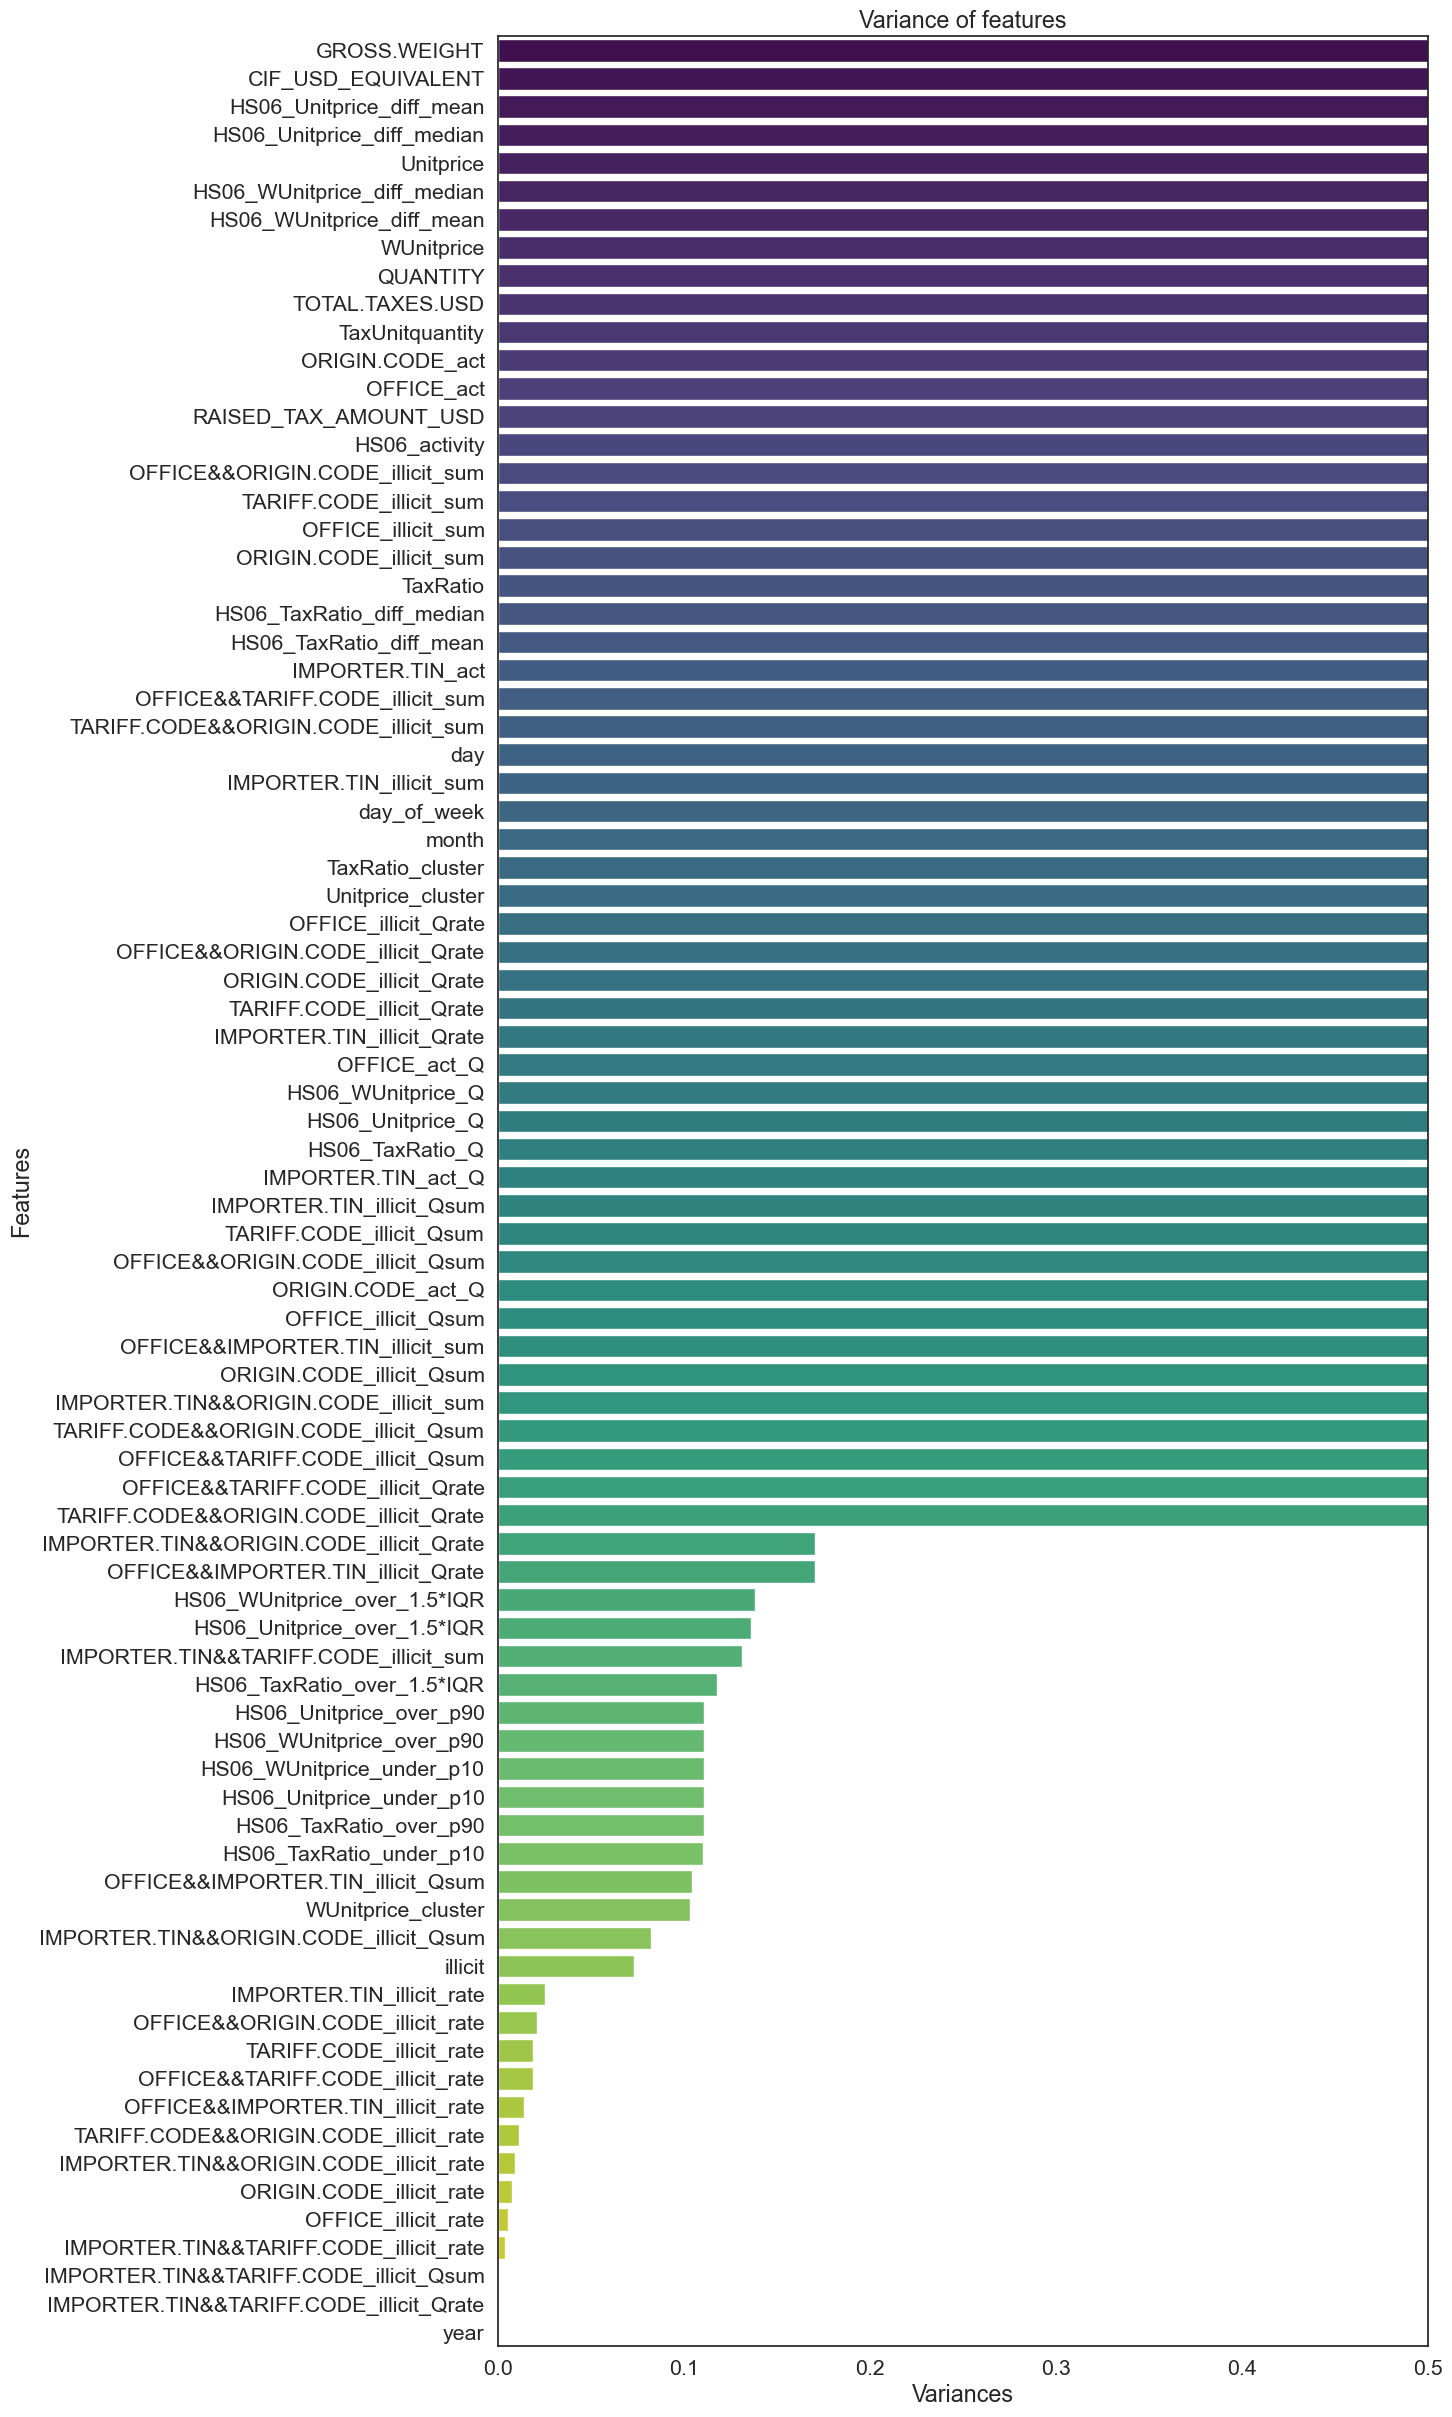

In [ ]:
df_variance = pd.DataFrame({
    'Features': fs_variance.feature_names_in_,
    'Variances': fs_variance.variances_
})

df_variance.sort_values(by='Variances', ascending=False, inplace=True)

# plot feature importances
plt.figure(figsize=(12, 30))
sns.barplot(x='Variances', y='Features', data=df_variance, palette='viridis')
plt.title('Variance of features')
plt.xlim(right=0.5)
plt.show()

**Preparing the variables for MI and RF**

In [ ]:
# variables to select from (numeric and booleans)
## dropping target related variables

var_to_selec = df_transformed.drop(['RAISED_TAX_AMOUNT_USD'], axis = 1).select_dtypes(['number', 'bool']).columns.tolist()

df_sel = df_transformed[var_to_selec]

# simple imputation handle missing values
imputer = SimpleImputer(strategy='mean')
df_sel[var_to_selec] = imputer.fit_transform(df_sel)

# scale features to the range [0, 1]
scaler = MinMaxScaler()
df_sel[var_to_selec] = scaler.fit_transform(df_sel)


In [ ]:
var_to_selec

['year',
 'month',
 'day',
 'CIF_USD_EQUIVALENT',
 'QUANTITY',
 'GROSS.WEIGHT',
 'TOTAL.TAXES.USD',
 'illicit',
 'Unitprice',
 'WUnitprice',
 'TaxRatio',
 'TaxUnitquantity',
 'day_of_week',
 'OFFICE_act',
 'OFFICE_act_Q',
 'IMPORTER.TIN_act',
 'IMPORTER.TIN_act_Q',
 'ORIGIN.CODE_act',
 'ORIGIN.CODE_act_Q',
 'Unitprice_cluster',
 'WUnitprice_cluster',
 'TaxRatio_cluster',
 'HS06_activity',
 'HS06_Unitprice_diff_mean',
 'HS06_Unitprice_diff_median',
 'HS06_Unitprice_under_p10',
 'HS06_Unitprice_over_p90',
 'HS06_Unitprice_over_1.5*IQR',
 'HS06_Unitprice_Q',
 'HS06_WUnitprice_diff_mean',
 'HS06_WUnitprice_diff_median',
 'HS06_WUnitprice_under_p10',
 'HS06_WUnitprice_over_p90',
 'HS06_WUnitprice_over_1.5*IQR',
 'HS06_WUnitprice_Q',
 'HS06_TaxRatio_diff_mean',
 'HS06_TaxRatio_diff_median',
 'HS06_TaxRatio_under_p10',
 'HS06_TaxRatio_over_p90',
 'HS06_TaxRatio_over_1.5*IQR',
 'HS06_TaxRatio_Q',
 'OFFICE_illicit_sum',
 'OFFICE_illicit_rate',
 'IMPORTER.TIN_illicit_sum',
 'IMPORTER.TIN_illicit

## Mutual Information (MI) method

MI measures the dependence between two variables and is particularly useful for capturing non-linear relationships and dependencies between features.

Strengths:

> Effective in identifying informative features even when the relationship is not strictly linear.

> It can handle both continuous and discrete data.

Weaknesses:

> Mutual information might be sensitive to noise in the data.

> It may not capture complex interactions between features as effectively as some other methods.



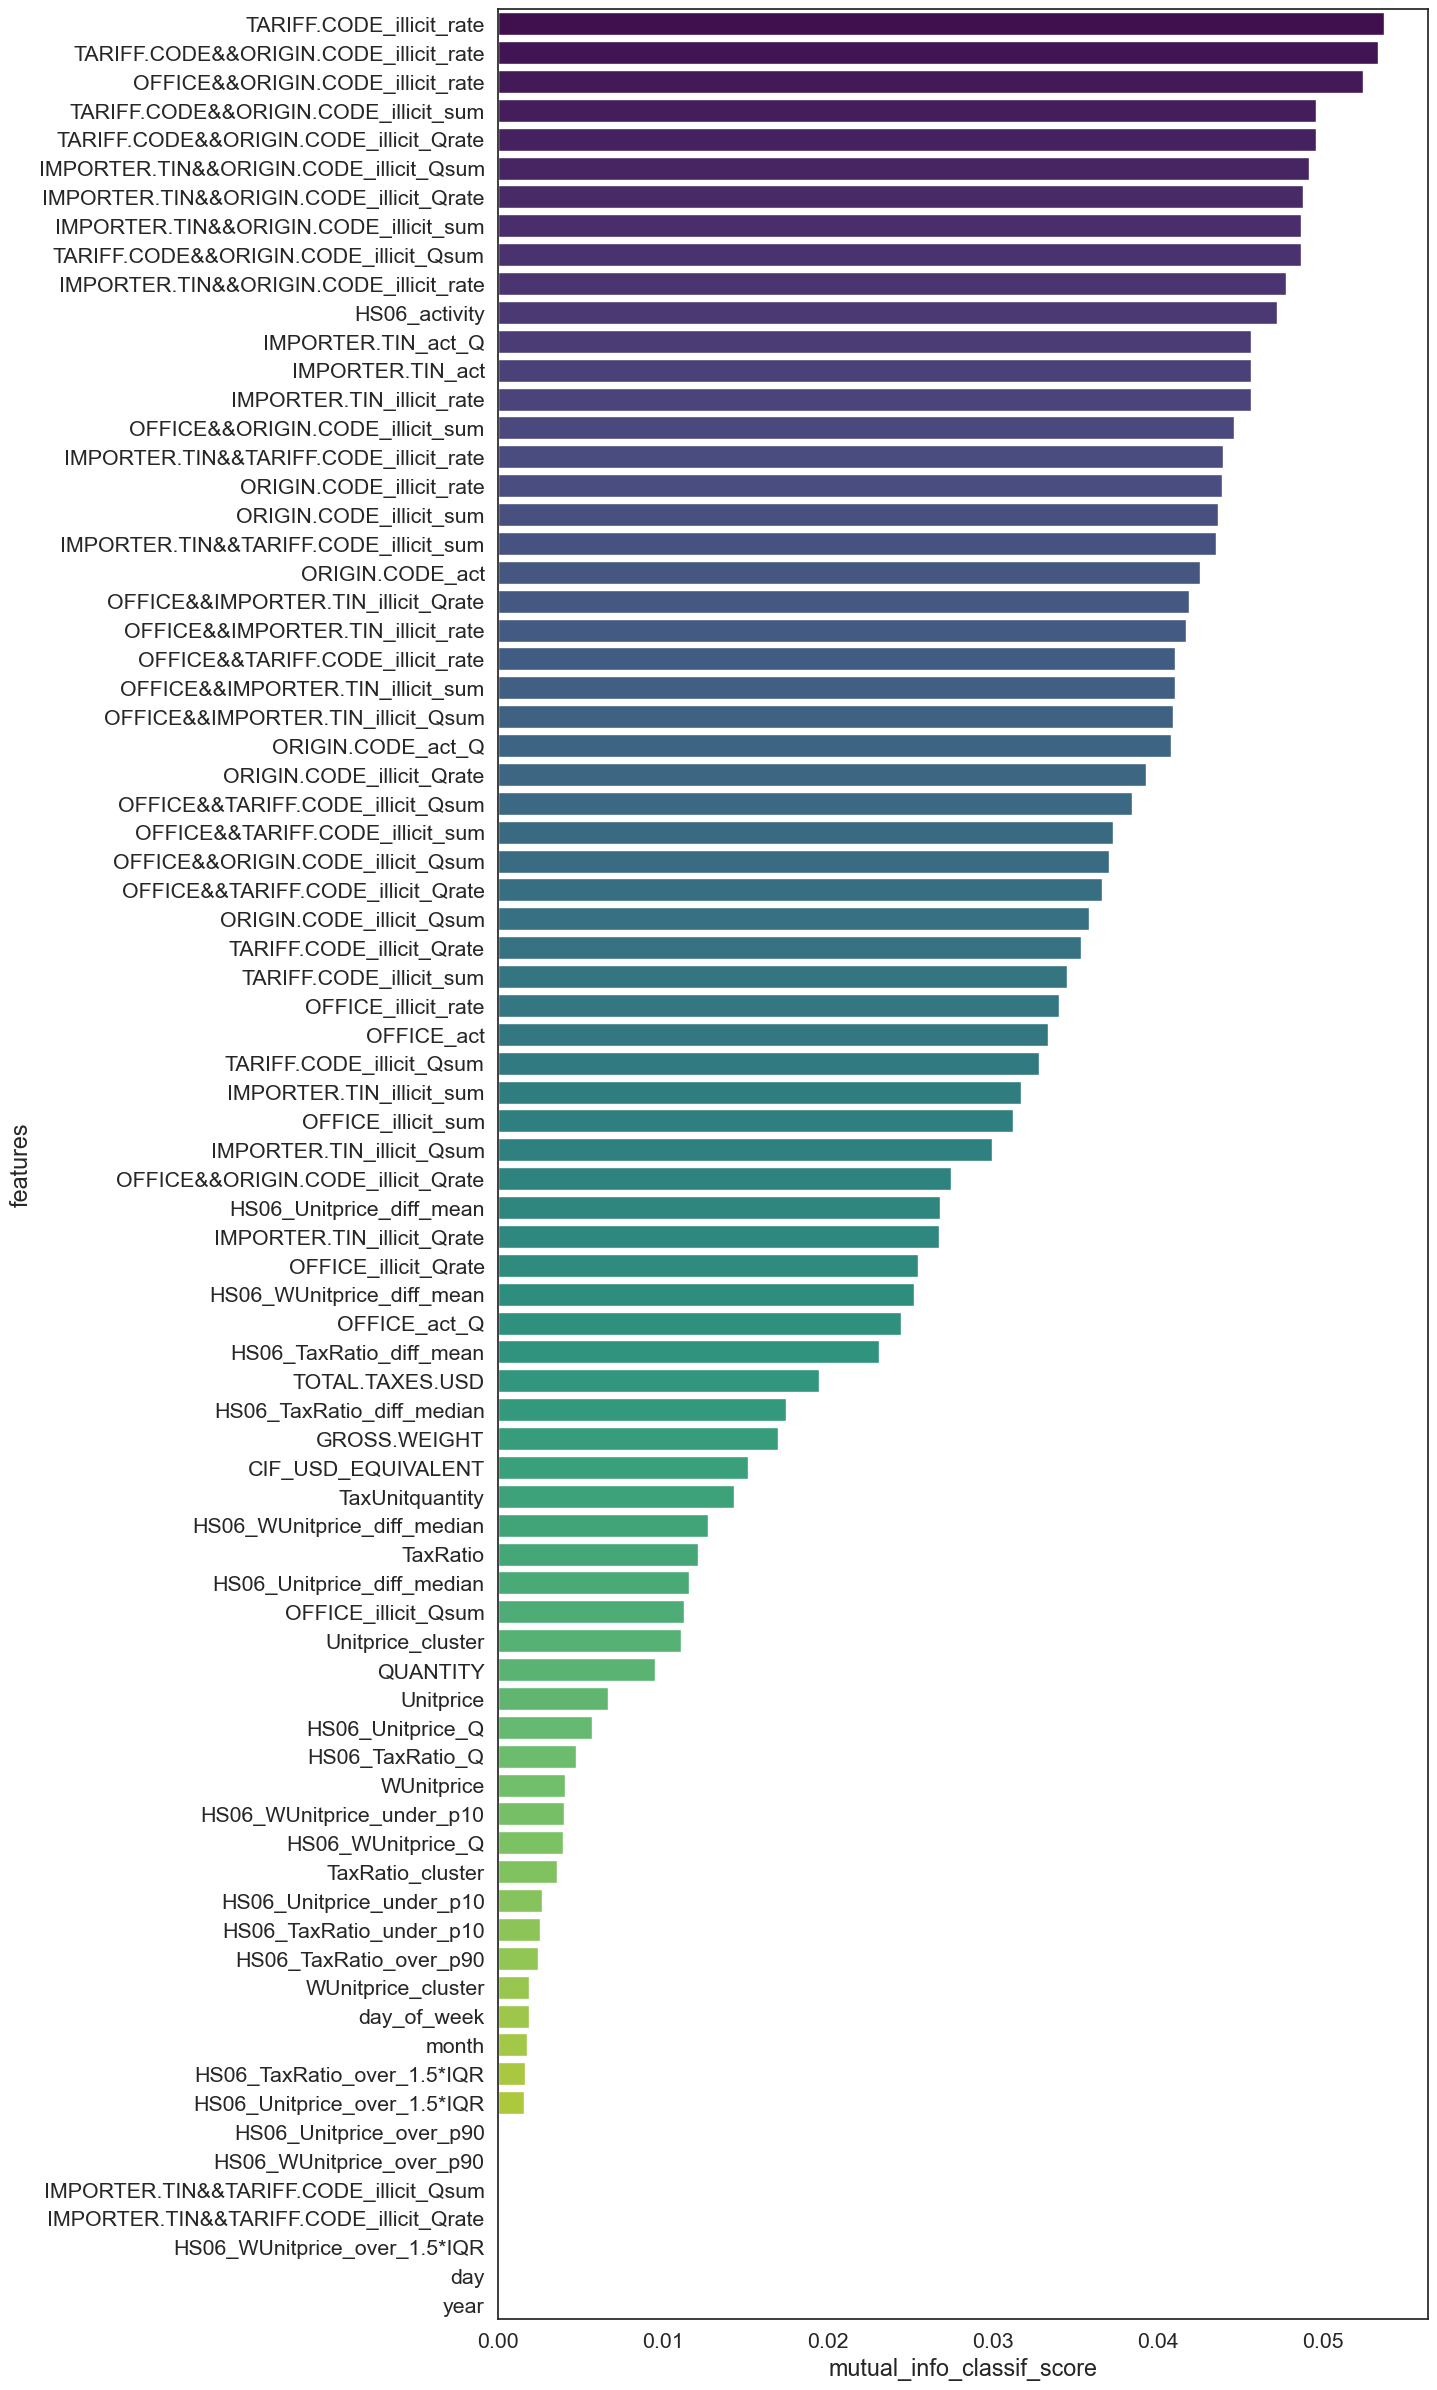

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

def get_mutual_score(df, vars, target, plot):

    df_aux = df[vars].drop([target], axis = 1)

    # mutual_info_classif checking all variables to select from
    fs_mutual_info_classif = SelectKBest(mutual_info_classif, k=len(vars)-1)
    df_mutual_info_classif = fs_mutual_info_classif.fit_transform(df_aux, df[target])
    mutual_info_classif_selected_columns = df_aux.columns[fs_mutual_info_classif.get_support()]

    # get chmutual_info_classifi2 scores
    mutual_info_classif_scores = fs_mutual_info_classif.scores_

    # create a DataFrame with feature names and their corresponding chi2 scores
    df_mutual_info_classif = pd.DataFrame({'features': df_aux.columns, 'mutual_info_classif_score': mutual_info_classif_scores})

    df_mutual_info_classif = df_mutual_info_classif.set_index('features')

    # sort the DataFrame by chi2 scores in descending order
    df_mutual_info_classif = df_mutual_info_classif.sort_values(by='mutual_info_classif_score', ascending=False)

    if plot:
        # Plot feature importances
        plt.figure(figsize=(12, 30))
        sns.barplot(x='mutual_info_classif_score', y=df_mutual_info_classif.index, data=df_mutual_info_classif, palette='viridis')
        plt.show()

    return df_mutual_info_classif

df_mutual_info_classif = get_mutual_score(df_sel, var_to_selec, 'illicit', plot=True)


## Random Forest (RF) feature importance method

Random Forest is a powerful bagging ensemble learning algorithm.

Strengths:

> Can capture complex relationships in the data

> Effective for classification tasks

> It tends to handle noisy data and irrelevant features well

Weaknesses:

> It tends to assign similar importance to correlated variables

> It might be biased towards categorical variables with many levels

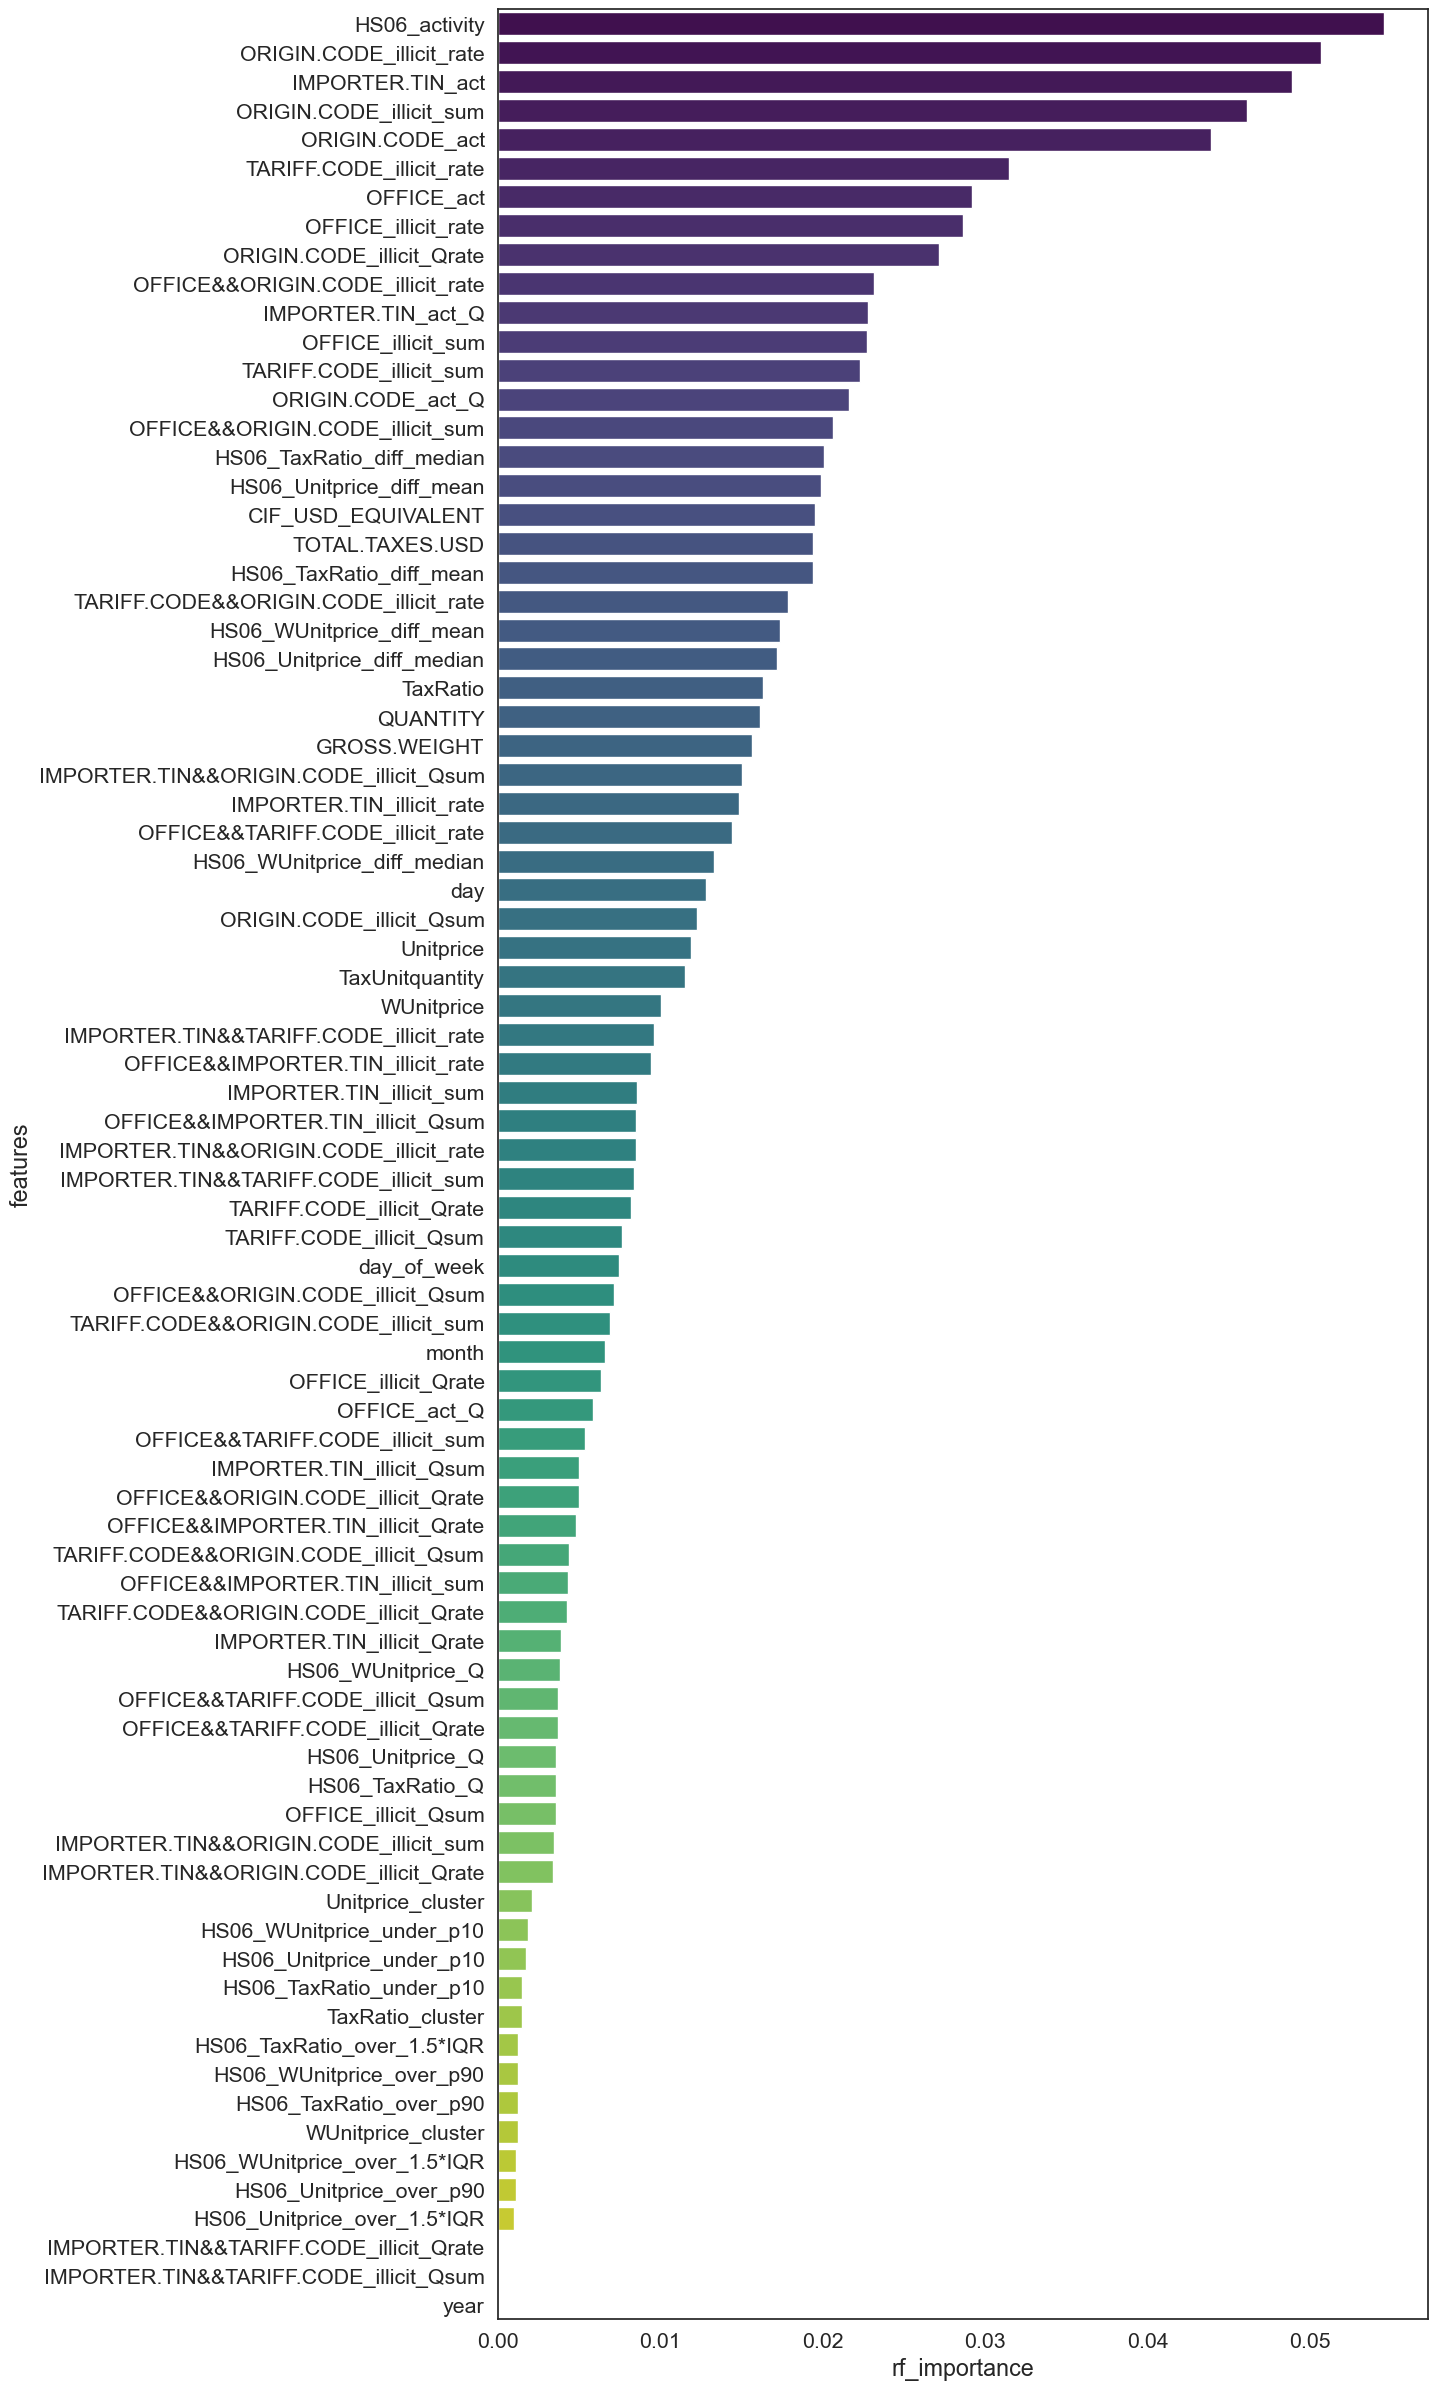

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def get_rf_importance(df, vars, target, plot):

    X = df[vars].drop([target], axis = 1)

    y = df[target]

    # Create a Random Forest model
    rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1, random_state=42)

    # Train the Random Forest model
    rf_model.fit(X, y)

    feature_importances = rf_model.feature_importances_

    # Create a DataFrame to store feature importances
    df_rf_feature_import = pd.DataFrame({'features': X.columns, 'rf_importance': feature_importances})

    df_rf_feature_import = df_rf_feature_import.set_index('features')

    # Sort features based on importance
    df_rf_feature_import = df_rf_feature_import.sort_values(by='rf_importance', ascending=False)

    if plot:
        # Plot feature importances
        plt.figure(figsize=(12, 30))
        sns.barplot(x='rf_importance', y=df_rf_feature_import.index, data=df_rf_feature_import, palette='viridis')
        # plt.title('Random Forest Feature Importance')
        plt.show()
    
    return df_rf_feature_import

df_rf_feature_import = get_rf_importance(df_sel, var_to_selec, 'illicit', plot=True)


## Feature selection comparison

Merging methods results and calculating the average importance.

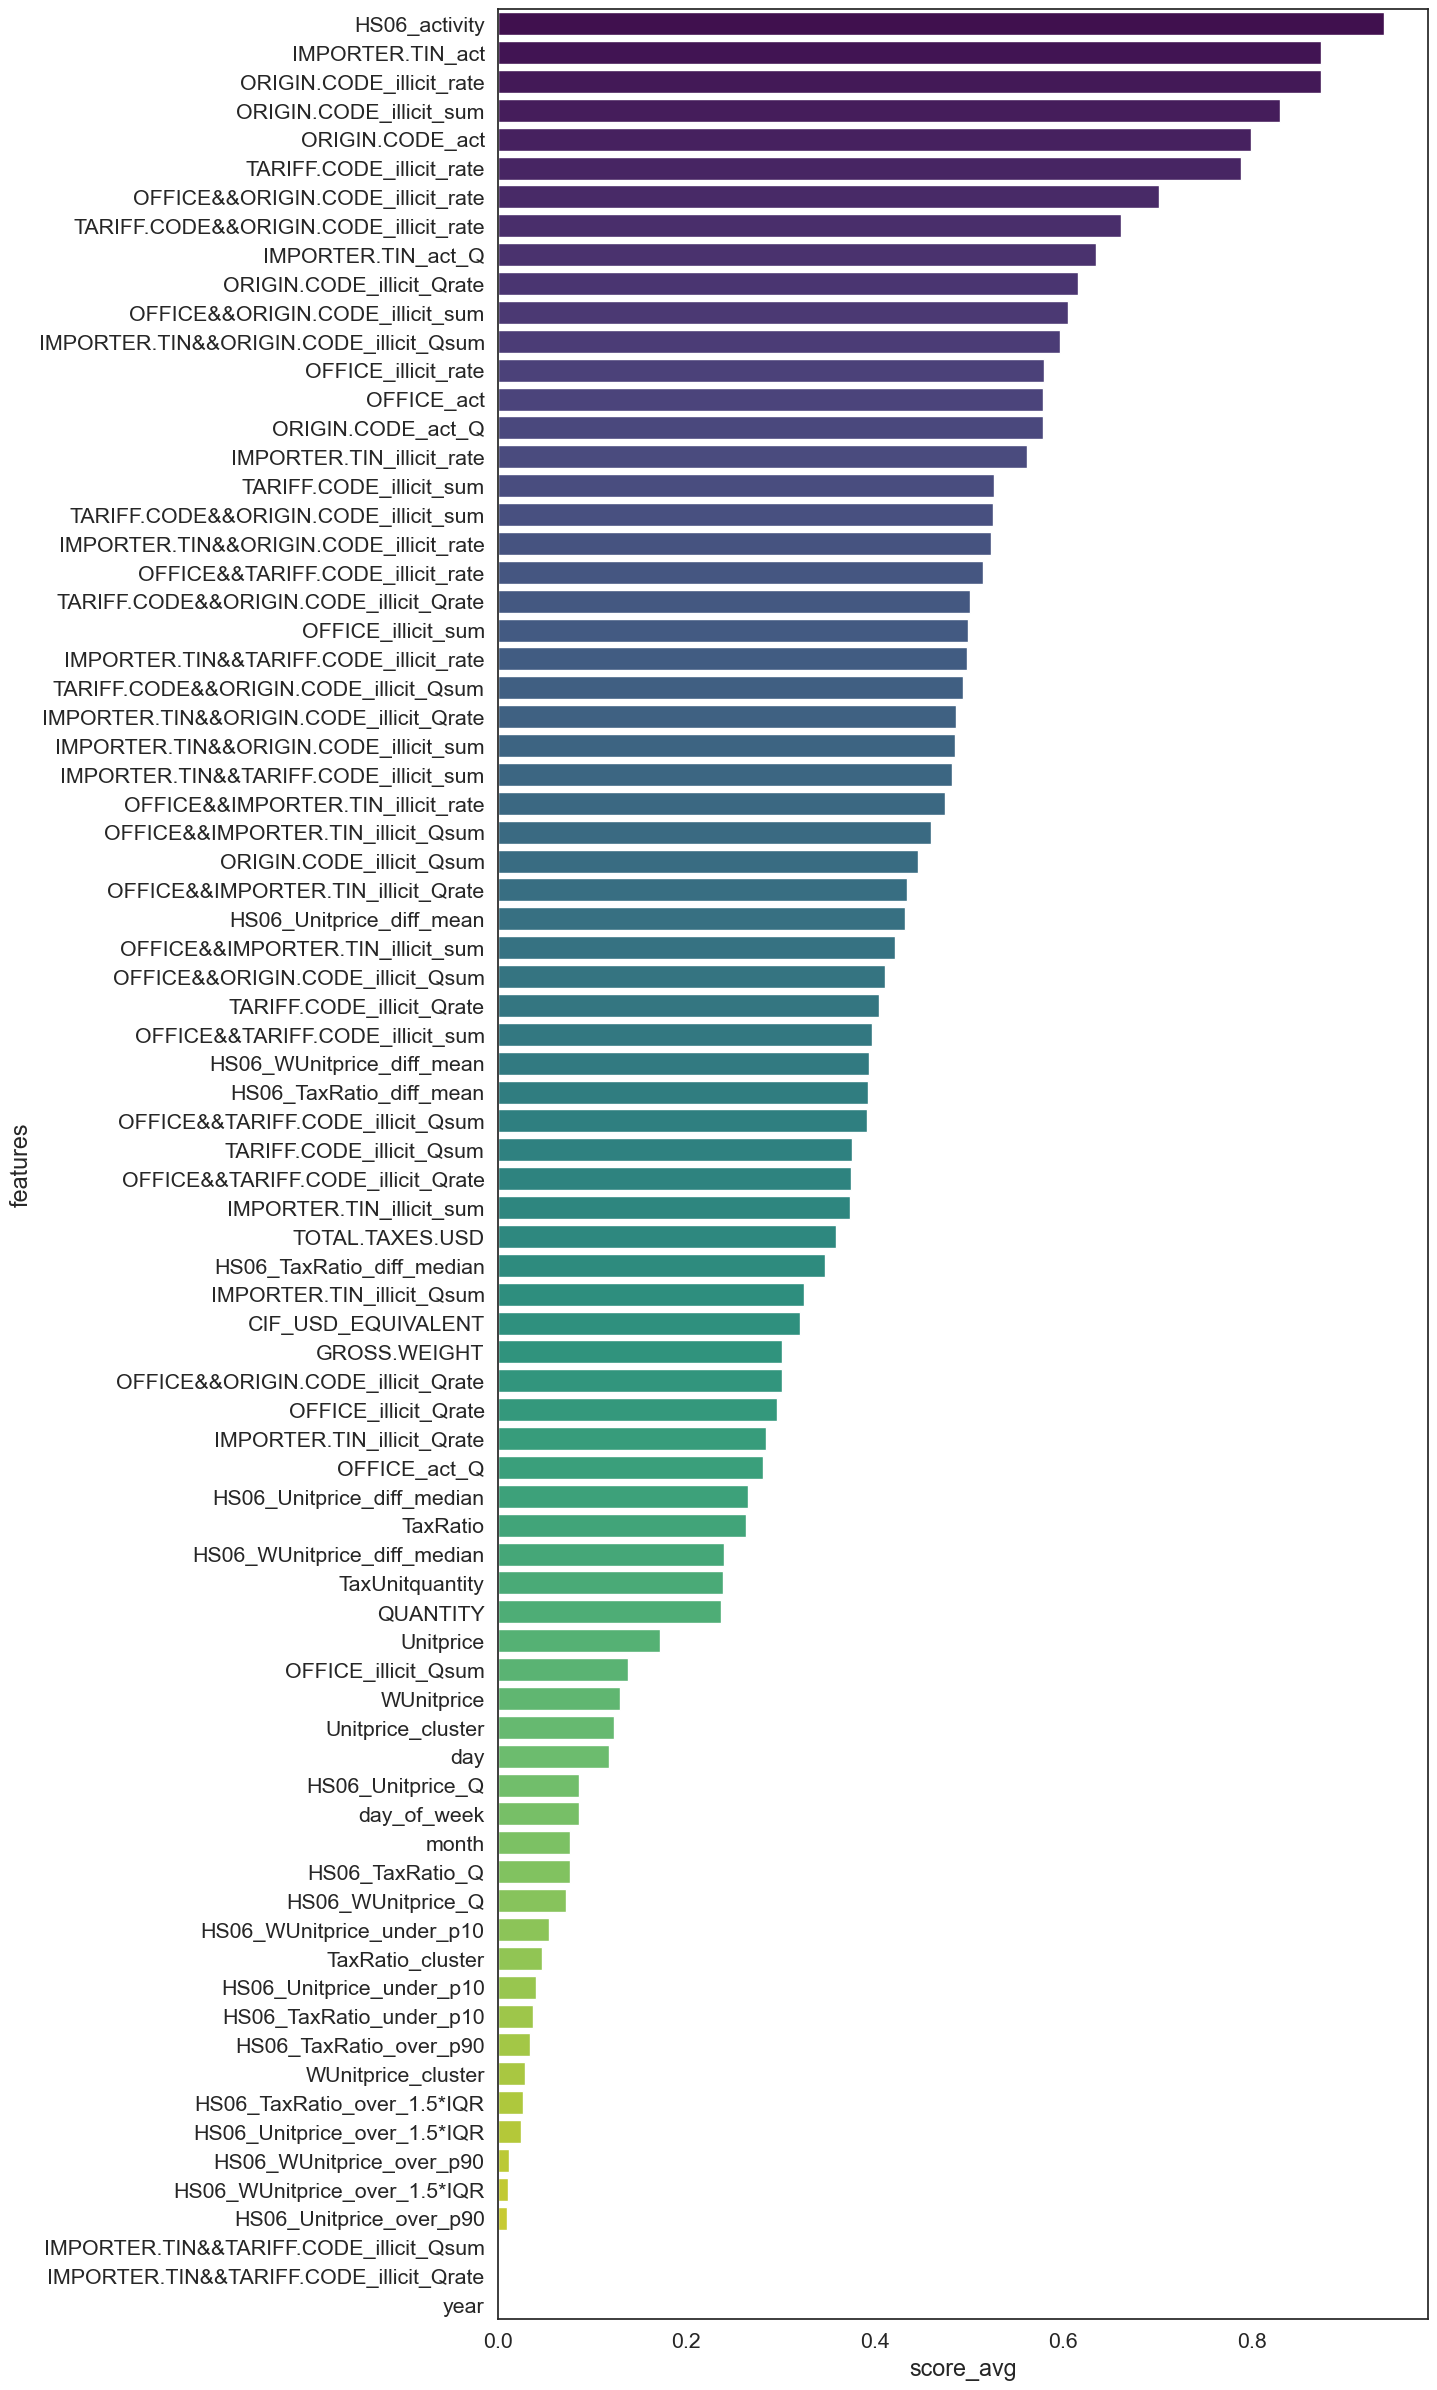

In [ ]:
# merging score dataframes in one
df_feature_selection = pd.merge(df_mutual_info_classif, df_rf_feature_import, left_index=True, right_index=True)

# minmax scalation for scores
scaler = MinMaxScaler()
df_feature_selection_std = scaler.fit_transform(df_feature_selection.values)

# scaled cataframe
df_feature_selection_std = pd.DataFrame(df_feature_selection_std, columns=df_feature_selection.columns, index=df_feature_selection.index)

# average score column
df_feature_selection_std['score_avg'] = (df_feature_selection_std.mutual_info_classif_score + df_feature_selection_std.rf_importance)/2

# sorting in descending
df_feature_selection_std.sort_values(by='score_avg', ascending=False, inplace=True)

# plot the average score
plt.figure(figsize=(12, 30))
sns.barplot(x='score_avg', y=df_feature_selection_std.index, data=df_feature_selection_std, palette='viridis')
plt.show()

## Missing values

Adding missing values into consideration.

In [ ]:
percent_missing=df_transformed[var_to_selec].isnull().sum()*100/len(df_test)

percent_missing.name = 'percent_missing'

In [ ]:
df_feature_selection_with_missing = pd.merge(df_feature_selection_std, percent_missing, left_index=True, right_index=True, how='outer')

df_feature_selection_with_missing

mutual_info_classif_score  rf_importance  \
CIF_USD_EQUIVALENT                              0.28           0.36   
GROSS.WEIGHT                                    0.32           0.29   
HS06_TaxRatio_Q                                 0.09           0.07   
HS06_TaxRatio_diff_mean                         0.43           0.36   
HS06_TaxRatio_diff_median                       0.33           0.37   
...                                              ...            ...   
day                                             0.00           0.24   
day_of_week                                     0.03           0.14   
illicit                                          NaN            NaN   
month                                           0.03           0.12   
year                                            0.00           0.00   

                           score_avg  percent_missing  
CIF_USD_EQUIVALENT              0.32             0.00  
GROSS.WEIGHT                    0.30             0.00  
HS06_TaxRatio_Q                 0.08             0.00  
HS06_TaxRatio_diff_mean         0.39             0.00  
HS06_TaxRatio_diff_median       0.35             0.00  
...                              ...              ...  
day                             0.12             0.00  
day_of_week                     0.09             0.00  
illicit                          NaN             0.00  
month                           0.08             0.00  
year                            0.00             0.00  

[81 rows x 4 columns]

## Correlations

Analysing correlations for the final selection, taking into account feature relevance scores and missing values in correlated groups.

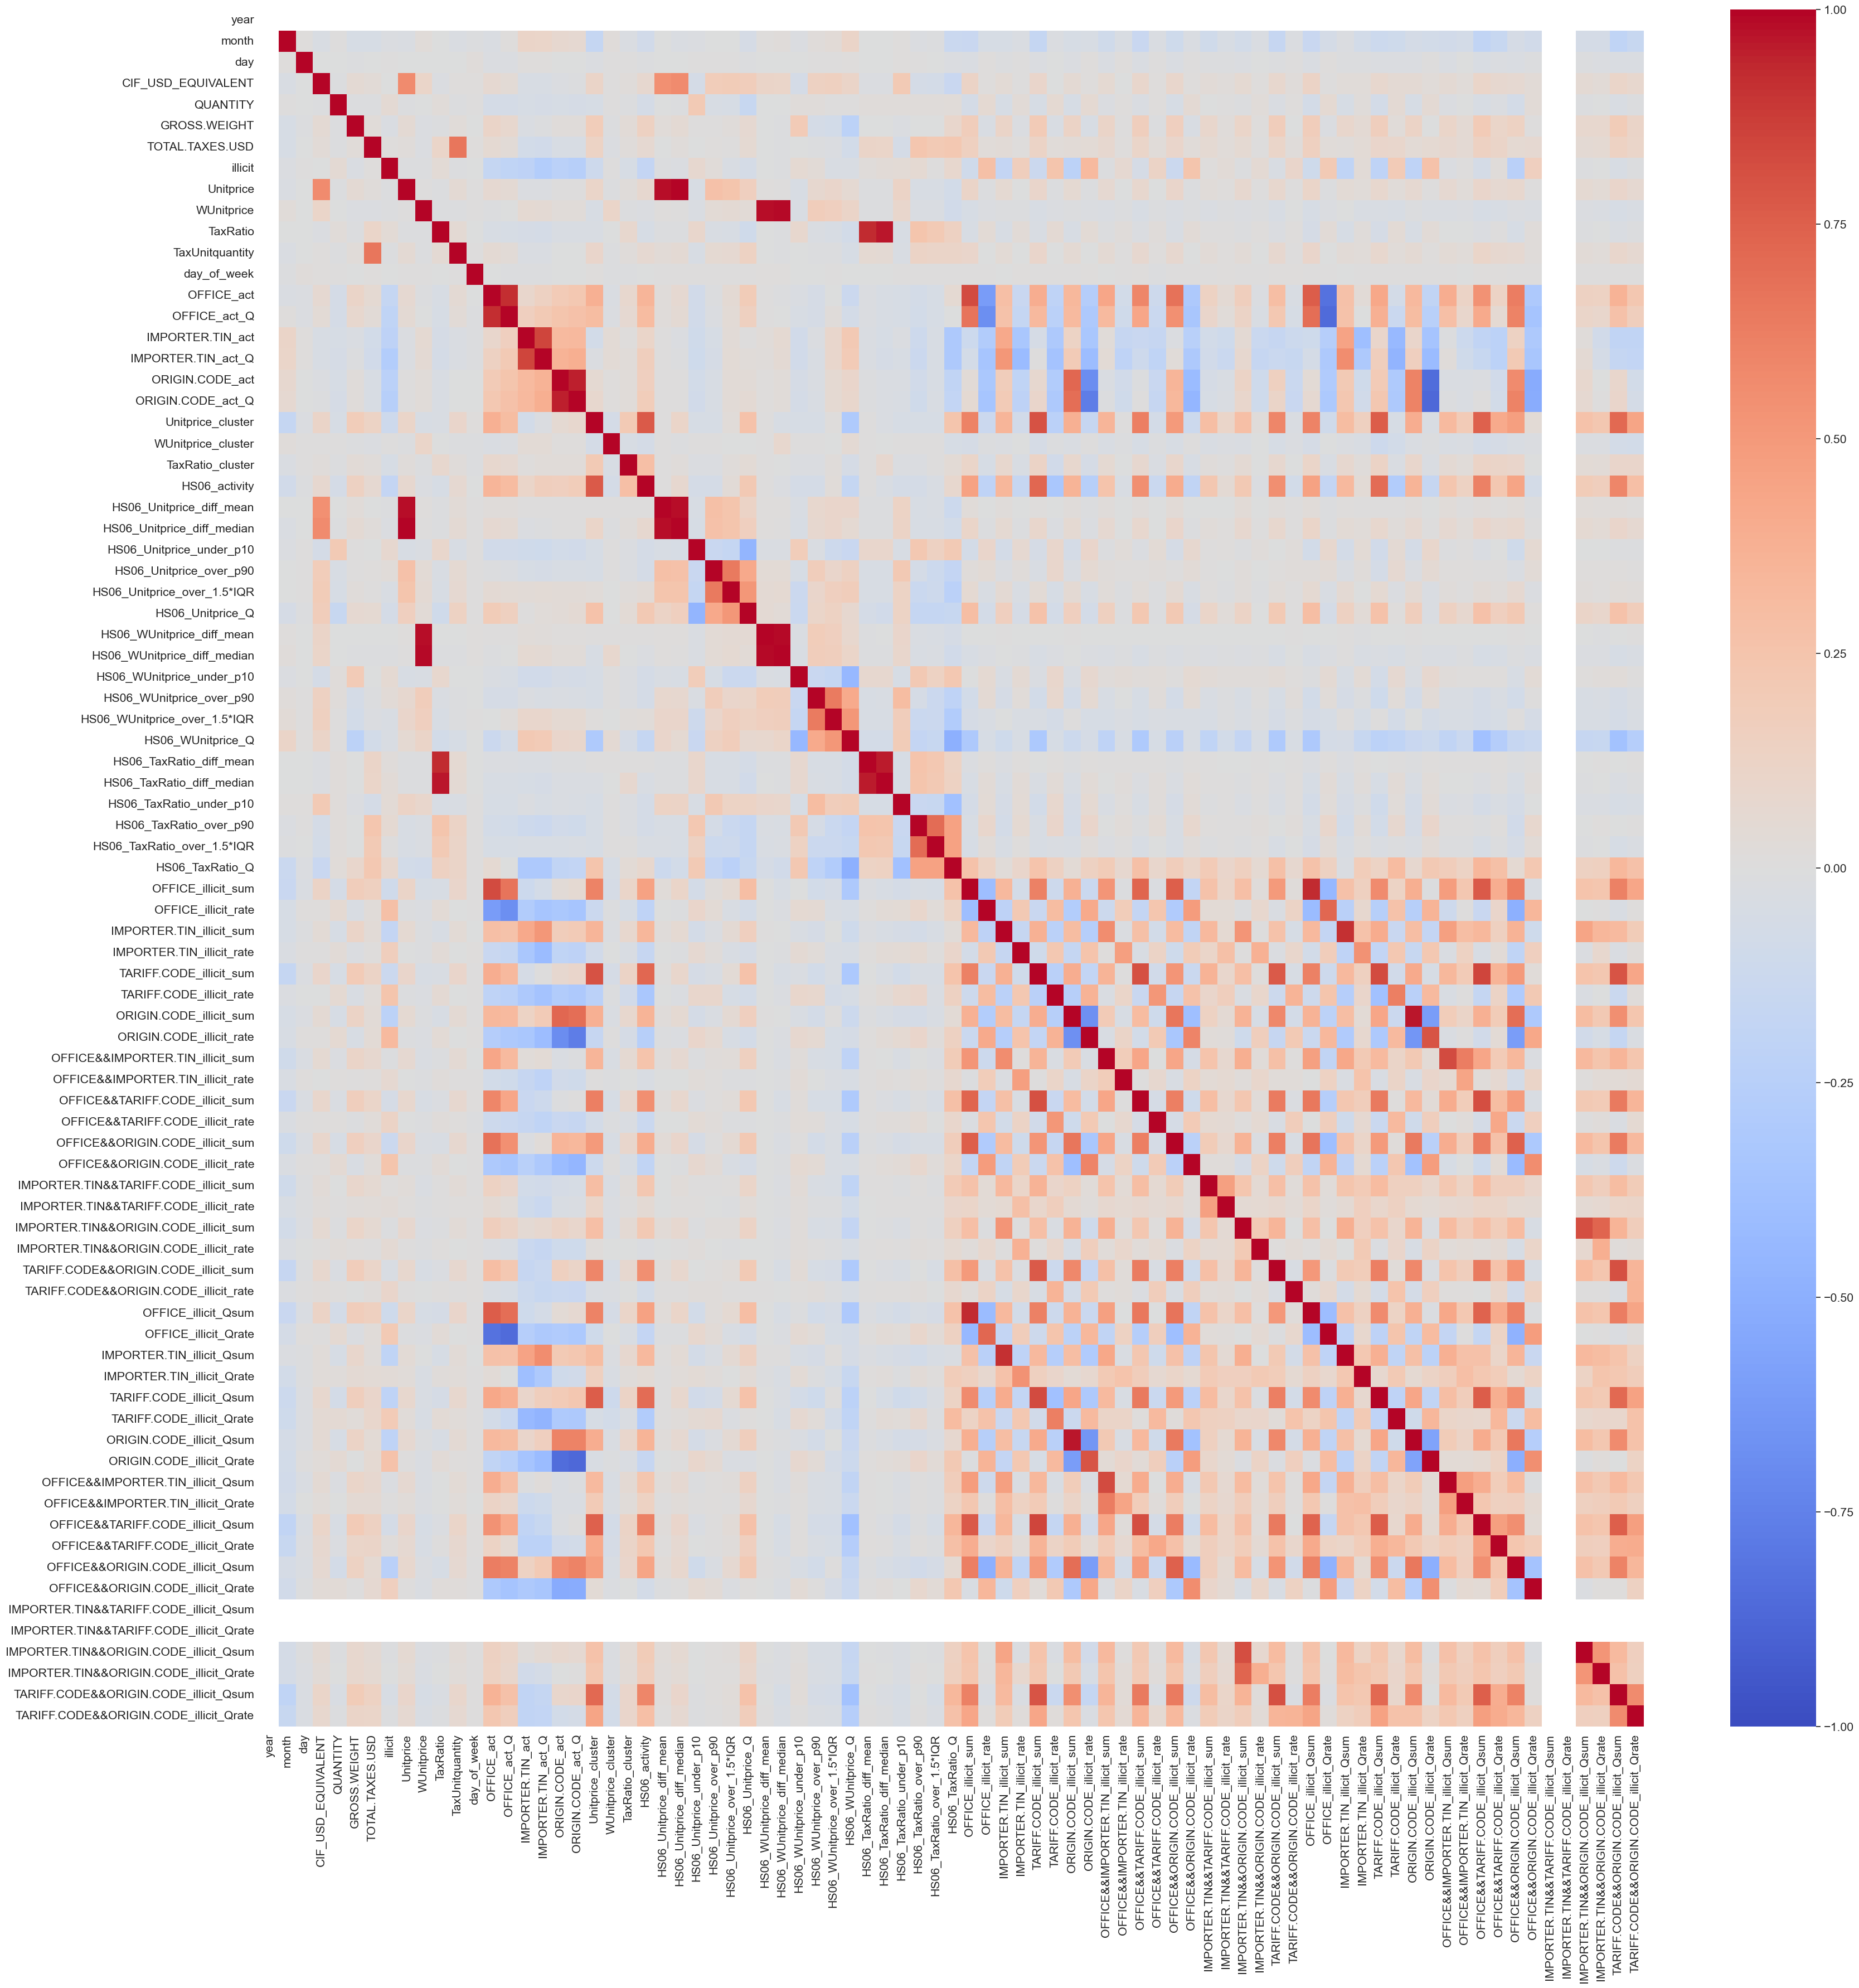

In [ ]:
corr = df_transformed[var_to_selec].corr()

# Set the size of the plot
plt.figure(figsize=(40, 40))

# Plot the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=False, vmin=-1)

# Show the plot
plt.show()

Identifying groups with high correlation

In [ ]:
high_corr_groups = []

# correlation threshold
mask = corr > 0.75

for c1 in var_to_selec:
  # grouping for c1
  group = [c1]
  for c2 in var_to_selec:
    if (c1 != c2) and (mask[c1][c2]):
      group.append(c2)

  # if c1 found correlations
  if len(group) > 1:
    # sorting the group for comparation with other groups
    group.sort()
    if len(high_corr_groups) < 1:
      high_corr_groups.append(group)
    else:
      group_not_stored = True
      for gr in high_corr_groups:
        if gr == group:
          group_not_stored = False
      if group_not_stored:
        high_corr_groups.append(group)


high_corr_groups

[['HS06_Unitprice_diff_mean', 'HS06_Unitprice_diff_median', 'Unitprice'],
 ['HS06_WUnitprice_diff_mean', 'HS06_WUnitprice_diff_median', 'WUnitprice'],
 ['HS06_TaxRatio_diff_mean', 'HS06_TaxRatio_diff_median', 'TaxRatio'],
 ['OFFICE_act', 'OFFICE_act_Q', 'OFFICE_illicit_Qsum', 'OFFICE_illicit_sum'],
 ['OFFICE_act', 'OFFICE_act_Q'],
 ['IMPORTER.TIN_act', 'IMPORTER.TIN_act_Q'],
 ['ORIGIN.CODE_act', 'ORIGIN.CODE_act_Q'],
 ['HS06_activity',
  'TARIFF.CODE_illicit_Qsum',
  'TARIFF.CODE_illicit_sum',
  'Unitprice_cluster'],
 ['HS06_activity', 'Unitprice_cluster'],
 ['OFFICE&&ORIGIN.CODE_illicit_sum',
  'OFFICE&&TARIFF.CODE_illicit_Qsum',
  'OFFICE_act',
  'OFFICE_illicit_Qsum',
  'OFFICE_illicit_sum'],
 ['IMPORTER.TIN_illicit_Qsum', 'IMPORTER.TIN_illicit_sum'],
 ['OFFICE&&TARIFF.CODE_illicit_Qsum',
  'OFFICE&&TARIFF.CODE_illicit_sum',
  'TARIFF.CODE&&ORIGIN.CODE_illicit_Qsum',
  'TARIFF.CODE&&ORIGIN.CODE_illicit_sum',
  'TARIFF.CODE_illicit_Qsum',
  'TARIFF.CODE_illicit_sum',
  'Unitprice_clu

Manual selection from the correlated groups

In [ ]:
df_feature_selection_with_missing = pd.merge(df_feature_selection_std, percent_missing, left_index=True, right_index=True)

for group in high_corr_groups:

    print(df_feature_selection_with_missing.loc[group][['score_avg','percent_missing']].sort_values(by='score_avg',ascending=False))

                            score_avg  percent_missing
HS06_Unitprice_diff_mean         0.43             0.00
HS06_Unitprice_diff_median       0.27             0.00
Unitprice                        0.17             0.00
                             score_avg  percent_missing
HS06_WUnitprice_diff_mean         0.39             0.00
HS06_WUnitprice_diff_median       0.24             0.00
WUnitprice                        0.13             0.00
                           score_avg  percent_missing
HS06_TaxRatio_diff_mean         0.39             0.00
HS06_TaxRatio_diff_median       0.35             0.00
TaxRatio                        0.26             0.00
                     score_avg  percent_missing
OFFICE_act                0.58             0.00
OFFICE_illicit_sum        0.50             0.00
OFFICE_act_Q              0.28             0.00
OFFICE_illicit_Qsum       0.14             0.00
              score_avg  percent_missing
OFFICE_act         0.58             0.00
OFFICE_act_Q      

In [ ]:
# manual selection of from correlated groups

high_corr_groups_selection = {'HS06_Unitprice_diff_mean',
                            'HS06_WUnitprice_diff_mean',
                            'HS06_TaxRatio_diff_mean',
                            'OFFICE_act',
                            'OFFICE_illicit_sum',
                            'OFFICE_act',
                            'IMPORTER.TIN_act',
                            'ORIGIN.CODE_act',
                            'HS06_activity',
                            'TARIFF.CODE_illicit_sum',
                            'Unitprice_cluster', # unreasonable correlation
                            'OFFICE&&ORIGIN.CODE_illicit_sum',
                            'IMPORTER.TIN_illicit_sum',
                            'TARIFF.CODE&&ORIGIN.CODE_illicit_sum',
                            'OFFICE&&TARIFF.CODE_illicit_sum',
                            'ORIGIN.CODE_illicit_sum',
                            'ORIGIN.CODE_illicit_rate',
                            'OFFICE&&IMPORTER.TIN_illicit_Qsum',
                            'IMPORTER.TIN&&ORIGIN.CODE_illicit_Qsum'}

Filtering variable names, to get the preselection.

In [ ]:
var_high_corr = set()

for group in high_corr_groups:
    gset = set(group)
    var_high_corr.update(gset)

preselection = set(var_to_selec)
print(len(preselection))

preselection.difference_update(var_high_corr)
print(len(preselection))

preselection.update(high_corr_groups_selection)
print(len(preselection))



81
45
63


In [ ]:
preselection.remove('illicit')

In [ ]:
df_preselected_features = df_feature_selection_with_missing.loc[list(preselection)][['score_avg','percent_missing']].sort_values(by='score_avg',ascending=False)

In [ ]:
df_preselected_features.loc[df_preselected_features['score_avg']>0.15]

score_avg  percent_missing
HS06_activity                                 0.94             0.00
IMPORTER.TIN_act                              0.87             0.00
ORIGIN.CODE_illicit_rate                      0.87             0.00
ORIGIN.CODE_illicit_sum                       0.83             0.00
ORIGIN.CODE_act                               0.80             0.00
TARIFF.CODE_illicit_rate                      0.79             0.57
OFFICE&&ORIGIN.CODE_illicit_rate              0.70             1.07
TARIFF.CODE&&ORIGIN.CODE_illicit_rate         0.66            24.90
OFFICE&&ORIGIN.CODE_illicit_sum               0.60             1.07
IMPORTER.TIN&&ORIGIN.CODE_illicit_Qsum        0.60            32.00
OFFICE_illicit_rate                           0.58             0.00
OFFICE_act                                    0.58             0.00
IMPORTER.TIN_illicit_rate                     0.56             3.00
TARIFF.CODE_illicit_sum                       0.53             0.57
TARIFF.CODE&&ORIGIN.CODE_illicit_sum          0.53            24.90
IMPORTER.TIN&&ORIGIN.CODE_illicit_rate        0.52            32.00
OFFICE&&TARIFF.CODE_illicit_rate              0.51            19.71
TARIFF.CODE&&ORIGIN.CODE_illicit_Qrate        0.50            24.90
OFFICE_illicit_sum                            0.50             0.00
IMPORTER.TIN&&TARIFF.CODE_illicit_rate        0.50            46.69
IMPORTER.TIN&&ORIGIN.CODE_illicit_Qrate       0.49            32.00
IMPORTER.TIN&&TARIFF.CODE_illicit_sum         0.48            46.69
OFFICE&&IMPORTER.TIN_illicit_rate             0.47            27.13
OFFICE&&IMPORTER.TIN_illicit_Qsum             0.46            27.13
OFFICE&&IMPORTER.TIN_illicit_Qrate            0.43            27.13
HS06_Unitprice_diff_mean                      0.43             0.00
OFFICE&&ORIGIN.CODE_illicit_Qsum              0.41             1.07
TARIFF.CODE_illicit_Qrate                     0.40             0.57
OFFICE&&TARIFF.CODE_illicit_sum               0.40            19.71
HS06_WUnitprice_diff_mean                     0.39             0.00
HS06_TaxRatio_diff_mean                       0.39             0.00
OFFICE&&TARIFF.CODE_illicit_Qrate             0.38            19.71
IMPORTER.TIN_illicit_sum                      0.37             3.00
TOTAL.TAXES.USD                               0.36             0.00
CIF_USD_EQUIVALENT                            0.32             0.00
GROSS.WEIGHT                                  0.30             0.00
OFFICE&&ORIGIN.CODE_illicit_Qrate             0.30             1.07
OFFICE_illicit_Qrate                          0.30             0.00
IMPORTER.TIN_illicit_Qrate                    0.28             3.00
TaxUnitquantity                               0.24             0.00
QUANTITY                                      0.24             0.00

Final selection, using avarage score.

In [ ]:
var_feature_selection = list(df_preselected_features.loc[df_preselected_features['score_avg']>0.15].index)

In [ ]:
var_feature_selection

['HS06_activity',
 'IMPORTER.TIN_act',
 'ORIGIN.CODE_illicit_rate',
 'ORIGIN.CODE_illicit_sum',
 'ORIGIN.CODE_act',
 'TARIFF.CODE_illicit_rate',
 'OFFICE&&ORIGIN.CODE_illicit_rate',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_rate',
 'OFFICE&&ORIGIN.CODE_illicit_sum',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_Qsum',
 'OFFICE_illicit_rate',
 'OFFICE_act',
 'IMPORTER.TIN_illicit_rate',
 'TARIFF.CODE_illicit_sum',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_sum',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_rate',
 'OFFICE&&TARIFF.CODE_illicit_rate',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_Qrate',
 'OFFICE_illicit_sum',
 'IMPORTER.TIN&&TARIFF.CODE_illicit_rate',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_Qrate',
 'IMPORTER.TIN&&TARIFF.CODE_illicit_sum',
 'OFFICE&&IMPORTER.TIN_illicit_rate',
 'OFFICE&&IMPORTER.TIN_illicit_Qsum',
 'OFFICE&&IMPORTER.TIN_illicit_Qrate',
 'HS06_Unitprice_diff_mean',
 'OFFICE&&ORIGIN.CODE_illicit_Qsum',
 'TARIFF.CODE_illicit_Qrate',
 'OFFICE&&TARIFF.CODE_illicit_sum',
 'HS06_WUnitprice_diff_mean',
 'HS06_

__________________

# Data Pipeline

The complete processing pipeline is executed from the beginning, taking care of the splits of the data and their proper treatments.

In [ ]:
# Setting TARIFF.CODE datatype as str
dtypes_dict = {
    'TARIFF.CODE':str,
    'CIF_USD_EQUIVALENT': float,
    'QUANTITY': float,
    'GROSS.WEIGHT': float,
    'TOTAL.TAXES.USD': float,
    'RAISED_TAX_AMOUNT_USD':float,
    'illicit':bool
}

df_original = pd.read_csv(PATH_INPUT_DATA, sep=",", dtype=dtypes_dict)


In [ ]:
df_original

year  month  day     OFFICE IMPORTER.TIN TARIFF.CODE ORIGIN.CODE  \
0       2013      1    1   OFFICE60    IMP545640  8703232225    CNTRY680   
1       2013      1    1   OFFICE24    IMP252323  8703321220    CNTRY376   
2       2013      1    1   OFFICE59    IMP194834  8704212025    CNTRY680   
3       2013      1    1   OFFICE60    IMP668188  3901100000    CNTRY277   
4       2013      1    1   OFFICE59    IMP395619  8517180000    CNTRY759   
...      ...    ...  ...        ...          ...         ...         ...   
199995  2014     12   31  OFFICE168    IMPO19832  3926909710    CNTRY994   
199996  2014     12   31  OFFICE296    IMPO10210  8704319941    CNTRY959   
199997  2014     12   31  OFFICE298    IMPO11255  5806200000    CNTRY994   
199998  2014     12   31  OFFICE168    IMPO16962  5807109010    CNTRY376   
199999  2014     12   31  OFFICE109    IMPO10548  3204110000    CNTRY976   

        CIF_USD_EQUIVALENT  QUANTITY  GROSS.WEIGHT  TOTAL.TAXES.USD  \
0                172710.00      1.00      28487.00          3492.00   
1                  7450.00      1.00     185994.00           503.00   
2                  2684.00      1.00     452843.00          5706.00   
3                  7412.00   2018.00      26546.00          3182.00   
4                  2786.00   7044.00       1958.00           587.00   
...                    ...       ...           ...              ...   
199995            19056.00      1.00        189.00             5.00   
199996              532.00    243.00         15.00           234.00   
199997               11.00     58.00         24.00             5.00   
199998             2826.00      3.00        822.00             5.00   
199999            86099.00 333634.00       3606.00         10166.00   

        RAISED_TAX_AMOUNT_USD  illicit  
0                        0.00    False  
1                        0.00    False  
2                        0.00    False  
3                        0.00    False  
4                        0.00    False  
...                       ...      ...  
199995                   0.00    False  
199996                 105.00     True  
199997                   0.00    False  
199998                   0.00    False  
199999                 267.00     True  

[200000 rows x 13 columns]

## Historical

In [ ]:
# split historical vs. new
df_model = df_original.copy()

target_info = ['illicit','RAISED_TAX_AMOUNT_USD']
ori_categorical = df_model.drop(target_info, axis = 1).select_dtypes('object').columns.tolist()
ori_numeric = df_model.drop(['year','month','day']+target_info, axis = 1).select_dtypes('number').columns.tolist()

#Seeking for the historic information
last_year=df_model.year.max()
last_year

#Historic data is taken from the data from before the last year and the first semester of the last year
df_historic = df_model[(df_model.year < last_year) | (df_model.month <= 6)]
df_historic

#New data, take only the last semester
df_new = df_model[(df_model.year == last_year) & (df_model.month > 6)]

# risk profiling

from risk_profiling import risk_profiling

df_historic, risk_tables = risk_profiling(df_historic, categorical, target='illicit', save=True, output_path=OUTPUT_PROFILES)

# output risk tables
risk_tables

['OFFICE_hist_sum&rate.csv',
 'IMPORTER.TIN_hist_sum&rate.csv',
 'TARIFF.CODE_hist_sum&rate.csv',
 'ORIGIN.CODE_hist_sum&rate.csv',
 'OFFICE&&IMPORTER.TIN_hist_sum&rate.csv',
 'OFFICE&&TARIFF.CODE_hist_sum&rate.csv',
 'OFFICE&&ORIGIN.CODE_hist_sum&rate.csv',
 'IMPORTER.TIN&&TARIFF.CODE_hist_sum&rate.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_hist_sum&rate.csv',
 'TARIFF.CODE&&ORIGIN.CODE_hist_sum&rate.csv',
 'OFFICE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN_hist_Qsum&Qrate.csv',
 'TARIFF.CODE_hist_Qsum&Qrate.csv',
 'ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'OFFICE&&IMPORTER.TIN_hist_Qsum&Qrate.csv',
 'OFFICE&&TARIFF.CODE_hist_Qsum&Qrate.csv',
 'OFFICE&&ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN&&TARIFF.CODE_hist_Qsum&Qrate.csv',
 'IMPORTER.TIN&&ORIGIN.CODE_hist_Qsum&Qrate.csv',
 'TARIFF.CODE&&ORIGIN.CODE_hist_Qsum&Qrate.csv']

## Development and test

In [ ]:
# split train - validation - test

X = df_new.drop(target_info, axis=1)
y = df_new.illicit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1337)

print('Traning dataset size:', X_train.shape)
# print('Validation dataset size:', X_val.shape)
print('Test dataset size:', X_test.shape)

Traning dataset size: (32343, 11)
Test dataset size: (8086, 11)


### Train processing

**Feature engineering**

> fit  (activity and stats info)

> transform (new features, merge with risk profiles, log transformations)

**Feature Encoding**

> one hot encoding (applied for the real dataset as mentioned above)

**Feature selection and imputation**

> column filtering (with variables selected)

> imputation of missing values

**Feature engineering**

In [ ]:
from feature_engine import Feature_engine

f_engine = Feature_engine(to_comb=categorical, risk_tables=risk_tables, save_stats=True, risk_tables_path=OUTPUT_PROFILES)

f_engine.fit(X_train)
X_train = f_engine.transform(X_train)


# Fitting started

## Calculating basic numeric feature to fit

## Processing activity information
Variables: ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']

## Processing tariff codes stats information
Codes: HS06
Variables: ['Unitprice', 'WUnitprice', 'TaxRatio']

Extracting stats info from Unitprice


  1%|          | 23/2493 [00:00<00:10, 225.39it/s]100%|██████████| 2493/2493 [00:09<00:00, 265.88it/s]


Extracting stats info from WUnitprice


100%|██████████| 2493/2493 [00:08<00:00, 277.06it/s]


Extracting stats info from TaxRatio


100%|██████████| 2493/2493 [00:09<00:00, 264.99it/s]



Creating clusters from HS06 stats info
Getting clusters for Unitprice
Getting clusters for WUnitprice
Getting clusters for TaxRatio

Fitting finished succesfully
# Transformation started

## Creating new basic numerical features

## Creating date related features

## Creating activity features
Variables: ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']

## Creating tariff codes stats features
Codes: HS06
Variables: ['Unitprice', 'WUnitprice', 'TaxRatio']

Creating new features from stats info
Working on Unitprice stats
Working on WUnitprice stats
Working on TaxRatio stats

## Creating new caterical features combining the existing ones
Variables to combine: ['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE']

## Matching new training codes with hisrical risk profiles

Transformation finished


**Transformation, feature selection and imputation**

In [ ]:
# column filtering
## done with the selection in the feature selection part

## excluded columns
non_numeric_bool = X_train.select_dtypes(exclude=['number','bool']).columns.to_list()
ori_date = ['year','month','day']

## dropping excluded columns
X_train.drop(ori_date + non_numeric_bool, axis = 1, inplace=True)

# ## columns preselected
# var_preselected = X_train.select_dtypes(['number','bool']).columns.tolist()

var_preselected = var_feature_selection

# log transformation
##

def num_to_log(df, num_col):
    log_numeric = []
    for var in num_col:
        # checking 0 values before log transformation
        if df[var].min() == 0:
            df.loc[df[var] == 0.0, var] = 0.001

        df['log_'+var]=np.log(df[var])
        log_numeric.append('log_'+var)

    return df, log_numeric

## applying log transformation to original numeric
X_train, log_vars = num_to_log(X_train, ori_numeric)

## adding log vars to preselection
var_preselected += log_vars

X_train = X_train[var_preselected]

# imputations fit and transform
##

## simple imputation handle missing values
X_train.fillna(0,inplace=True)

## scale features to the range [0, 1]
scaler = MinMaxScaler()
X_train[var_preselected] = scaler.fit_transform(X_train[var_preselected])

## dropping original numeric and date
X_train.drop(ori_numeric, axis = 1, inplace=True)

# final selection after transformation
var_selected = X_train.select_dtypes(['number','bool']).columns.tolist()


In [ ]:
var_selected

['HS06_activity',
 'IMPORTER.TIN_act',
 'ORIGIN.CODE_illicit_rate',
 'ORIGIN.CODE_illicit_sum',
 'ORIGIN.CODE_act',
 'TARIFF.CODE_illicit_rate',
 'OFFICE&&ORIGIN.CODE_illicit_rate',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_rate',
 'OFFICE&&ORIGIN.CODE_illicit_sum',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_Qsum',
 'OFFICE_illicit_rate',
 'OFFICE_act',
 'IMPORTER.TIN_illicit_rate',
 'TARIFF.CODE_illicit_sum',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_sum',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_rate',
 'OFFICE&&TARIFF.CODE_illicit_rate',
 'TARIFF.CODE&&ORIGIN.CODE_illicit_Qrate',
 'OFFICE_illicit_sum',
 'IMPORTER.TIN&&TARIFF.CODE_illicit_rate',
 'IMPORTER.TIN&&ORIGIN.CODE_illicit_Qrate',
 'IMPORTER.TIN&&TARIFF.CODE_illicit_sum',
 'OFFICE&&IMPORTER.TIN_illicit_rate',
 'OFFICE&&IMPORTER.TIN_illicit_Qsum',
 'OFFICE&&IMPORTER.TIN_illicit_Qrate',
 'HS06_Unitprice_diff_mean',
 'OFFICE&&ORIGIN.CODE_illicit_Qsum',
 'TARIFF.CODE_illicit_Qrate',
 'OFFICE&&TARIFF.CODE_illicit_sum',
 'HS06_WUnitprice_diff_mean',
 'HS06_

In [ ]:
X_train

HS06_activity  IMPORTER.TIN_act  ORIGIN.CODE_illicit_rate  \
0               0.06              0.41                      0.02   
1               0.00              0.20                      0.06   
2               0.00              0.00                      0.69   
3               0.00              0.01                      0.06   
4               0.03              0.60                      0.00   
...              ...               ...                       ...   
32338           0.01              0.22                      0.24   
32339           0.90              0.19                      0.12   
32340           0.03              0.27                      0.02   
32341           0.00              0.01                      0.68   
32342           0.00              0.10                      0.66   

       ORIGIN.CODE_illicit_sum  ORIGIN.CODE_act  TARIFF.CODE_illicit_rate  \
0                         0.61             0.54                      0.01   
1                         0.23             0.18                      0.00   
2                         0.10             0.01                      0.13   
3                         0.29             0.25                      0.00   
4                         0.48             1.00                      0.02   
...                        ...              ...                       ...   
32338                     0.20             0.05                      0.10   
32339                     0.36             0.12                      0.01   
32340                     0.61             0.54                      0.05   
32341                     0.07             0.01                      0.04   
32342                     0.07             0.01                      0.05   

       OFFICE&&ORIGIN.CODE_illicit_rate  \
0                                  0.01   
1                                  0.23   
2                                  0.12   
3                                  0.01   
4                                  0.01   
...                                 ...   
32338                              0.15   
32339                              0.04   
32340                              0.02   
32341                              0.33   
32342                              0.00   

       TARIFF.CODE&&ORIGIN.CODE_illicit_rate  OFFICE&&ORIGIN.CODE_illicit_sum  \
0                                       0.00                             0.06   
1                                       0.00                             0.02   
2                                       0.00                             0.01   
3                                       0.00                             0.05   
4                                       0.00                             0.12   
...                                      ...                              ...   
32338                                   0.00                             0.02   
32339                                   0.02                             0.28   
32340                                   0.00                             0.04   
32341                                   0.00                             0.01   
32342                                   0.00                             0.00   

       IMPORTER.TIN&&ORIGIN.CODE_illicit_Qsum  OFFICE_illicit_rate  \
0                                        0.00                 0.00   
1                                        0.00                 0.76   
2                                        0.00                 0.05   
3                                        0.00                 0.00   
4                                        0.00                 0.00   
...                                       ...                  ...   
32338                                    0.00                 0.17   
32339                                    0.00                 0.02   
32340                                    0.00                 0.13   
32341                                    0.00                 0.62   
32342

### Validation and test processing

> transform (new features, merge with risk profiles, log transformations)

> column filtering (with variables selected)

> imputation of missing values

In [ ]:
# feature engine transform
##

# X_val = f_engine.transform(X_val)
X_test = f_engine.transform(X_test)

# log transformation
##

# X_val, _ = num_to_log(X_val, ori_numeric)
X_test, _ = num_to_log(X_test, ori_numeric)

# imputations transform
##

## simple imputation handle missing values

X_test.fillna(0, inplace=True)

## scale features to the range [0, 1]
# X_val[var_preselected] = scaler.transform(X_val[var_preselected])
X_test[var_preselected] = scaler.transform(X_test[var_preselected])

## dropping original numeric
# X_val.drop(ori_numeric, axis = 1, inplace=True)
X_test.drop(ori_numeric, axis = 1, inplace=True)


# X_val = X_val[var_selected]
X_test = X_test[var_selected]

# Transformation started

## Creating new basic numerical features

## Creating date related features

## Creating activity features
Variables: ['OFFICE', 'IMPORTER.TIN', 'ORIGIN.CODE']

## Creating tariff codes stats features
Codes: HS06
Variables: ['Unitprice', 'WUnitprice', 'TaxRatio']

Creating new features from stats info
Working on Unitprice stats
Working on WUnitprice stats
Working on TaxRatio stats

## Creating new caterical features combining the existing ones
Variables to combine: ['OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE', 'ORIGIN.CODE']

## Matching new training codes with hisrical risk profiles

Transformation finished


In [ ]:
print(X_train.shape)
# print(X_val.shape)
print(X_test.shape)


(32343, 41)
(8086, 41)


In [ ]:
# X_train.columns == X_val.columns 

In [ ]:
X_train.columns == X_test.columns 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

____________________________________________________________________

# Modelling

Training, test and validation Sets

## Sampling

Not used because of the solution provided by the models and their hyperparameters.

In [ ]:
###

## Training function

In [ ]:
from sklearn.metrics import precision_recall_curve

#from numpy import sqrt
from numpy import argmax
 
def training(model_base, X_train, X_test, y_train, y_test, tuning = True, paramgrid = {}):
    
    if tuning:
        # Models build on a GridSearchCV class
        model = RandomizedSearchCV(model_base, param_distributions=paramgrid, 
                                cv=5, scoring = 'f1', n_jobs=-1,  
                                verbose=3, refit=True, n_iter=50)


    print('# Training the model')
    model.fit(X_train, y_train)
    print('------------------------')
    print('------------------------')

    print(f'Best estimator: {model.best_estimator_}')
    print(f'Best score: {model.best_score_}')
    print('------------------------')
    print('------------------------')

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('# Classification report (default threshold)')

    scores = {'Metric': ['Accuracy',
                         'Precision',
                         'Recall',
                         'F1'],
              'Train': [round(accuracy_score(y_train, y_train_pred),3), 
                        round(precision_score(y_train, y_train_pred),3),
                        round(recall_score(y_train, y_train_pred),3),
                        round(f1_score(y_train, y_train_pred),3)],
                'Test': [round(accuracy_score(y_test, y_test_pred),3), 
                        round(precision_score(y_test, y_test_pred),3),
                        round(recall_score(y_test, y_test_pred),3),
                        round(f1_score(y_test, y_test_pred),3)]}

    print(pd.DataFrame(scores).to_markdown(index=False))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    
    print('------------------------')
    print('------------------------')
    print('# Threshold based analysis')

    class_probabilities = model.predict_proba(X_test)
    preds = class_probabilities[:, 1]

    #-----------------------
    # ROC curve
    print('ROC curve analysis')
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('Model AUC: {:.4f}'.format(roc_auc))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', label='No Skill')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()

    # Optimal threshold with Youden’s J statistic
    optimal_idx = np.argmax(tpr - fpr) #calculating the maximum or J index
    optimal_threshold = threshold[optimal_idx]
    
    print("Best ROC Threshold value = %.4f"% optimal_threshold)
    
    # Locate de best threshold in the plot
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best')
    plt.show()

    # Metrics with optimal threshold of the ROC curve
    print('# Metrics with optimal threshold')
    y_train_pred = np.where(model.predict_proba(X_train)[:, 1] >= optimal_threshold, 1, 0)
    y_test_pred = np.where(model.predict_proba(X_test)[:, 1] >= optimal_threshold, 1, 0)
    
    scores = {'Metric': ['Accuracy',
                         'Precision',
                         'Recall',
                         'F1'],
              'Train': [round(accuracy_score(y_train, y_train_pred),3), 
                        round(precision_score(y_train, y_train_pred),3),
                        round(recall_score(y_train, y_train_pred),3),
                        round(f1_score(y_train, y_train_pred),3)],
                'Test': [round(accuracy_score(y_test, y_test_pred),3), 
                        round(precision_score(y_test, y_test_pred),3),
                        round(recall_score(y_test, y_test_pred),3),
                        round(f1_score(y_test, y_test_pred),3)]}

    print(pd.DataFrame(scores).to_markdown(index=False))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    print('------------------------')
    print('------------------------')

    #-----------------------
    # Precision-Recall curve
    print('Precision-Recall curve analysis (P-R)')
    # Calculate PR-curve
    precision, recall, threshold = precision_recall_curve(y_test, preds)

    # Convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # Locate the index of the largest f score
    optimal_idx = argmax(fscore) #rewriting variables
    optimal_threshold = threshold[optimal_idx] #rewriting variables
    
    # Plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision)
    # Axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    print('Best P-R Threshold = %.4f, F-Score = %.4f'% (threshold[optimal_idx], fscore[optimal_idx]))
    
    # Locate de best threshold in the plot
    plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='black', label='Best')
    plt.show()
    
    print('------------------------')
    print('------------------------')

    return model

## Validation function

In [ ]:
def model_validation(pipe, X, y, model_name = ''):
    
    print(f'{model_name} - 5 folds validation metrics (default threshold)')

    fold = KFold(n_splits=5, random_state=1, shuffle=True)

    scores = cross_validate(pipe,
                            X,
                            y,
                            scoring=['accuracy', 'recall', 'precision', 'f1'],
                            cv=fold,
                            n_jobs=-1)
    
    val_scores = pd.DataFrame(scores)[['test_recall', 'test_precision', 'test_f1']]

    names = {'test_recall': f'{model_name}_recall',
             'test_precision': f'{model_name}_precision', 
             'test_f1': f'{model_name}_f1'}
  
    val_scores.rename(columns=names, inplace=True)

    # Calculate mean values
    means = val_scores.mean()
    means.rename('mean scores', inplace=True)

    print(means.to_markdown())

    # Plotting boxplots for each column in a single figure
    plt.figure(figsize=(7, 6))
    bp = val_scores.boxplot()
    bp.set_ylim(0, 1)  # Setting the minimum value of the y-axis to 0

    # Adding mean values as horizontal lines
    for i, mean_val in enumerate(means):
        plt.axhline(mean_val, color='gray', linestyle='dashed', linewidth=1)

    plt.ylabel('Values')
    plt.show()

    return val_scores



## Inspection rate function

In [ ]:
def inspection_rate_analysis(model, X_, y_, model_name = ''):

    y_proba = model.predict_proba(X_)

    df_result = pd.DataFrame({'illicit': y_,
                'proba':y_proba[:, 1]})

    df_result.sort_values(by='proba', ascending=False, inplace=True)

    total_frauds = df_result['illicit'].sum()

    inspection_rate = []
    detection_rate = []

    for i in range(1, 101):
        rows = int(i*len(df_result)/100)

        detection_rate_i = df_result.head(rows)['illicit'].sum()/total_frauds
        
        inspection_rate.append(i)
        detection_rate.append(detection_rate_i)

    del df_result

    df_insp_rate =pd.DataFrame({'inspection_rate': inspection_rate,
                                f'detection_rate_{model_name}': detection_rate})

    return df_insp_rate

## Model testing

1- Logistic Regression

# Training the model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
------------------------
------------------------
Best estimator: LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')
Best score: 0.3665001775899469
------------------------
------------------------
# Classification report (default threshold)
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.774 |  0.767 |
| Precision |   0.235 |  0.237 |
| Recall    |   0.827 |  0.839 |
| F1        |   0.366 |  0.37  |


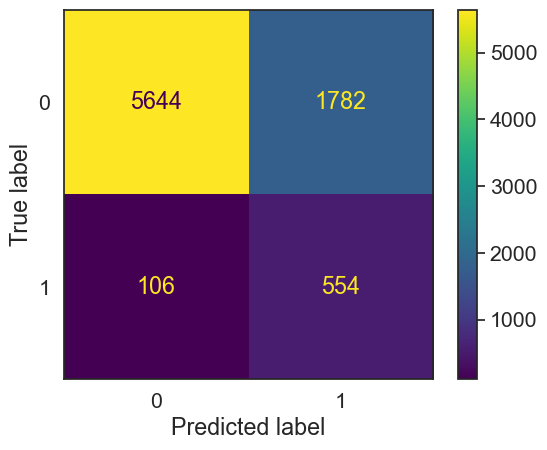

------------------------
------------------------
# Threshold based analysis
ROC curve analysis
Model AUC: 0.8682
Best ROC Threshold value = 0.6020


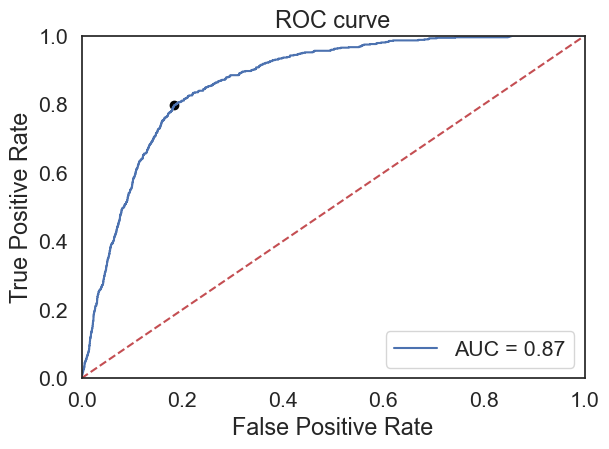

# Metrics with optimal threshold
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.818 |  0.815 |
| Precision |   0.268 |  0.278 |
| Recall    |   0.755 |  0.797 |
| F1        |   0.396 |  0.413 |


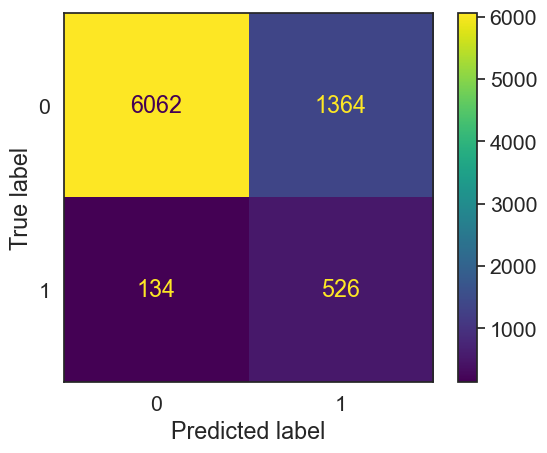

------------------------
------------------------
Precision-Recall curve analysis (P-R)
Best P-R Threshold = 0.9616, F-Score = nan


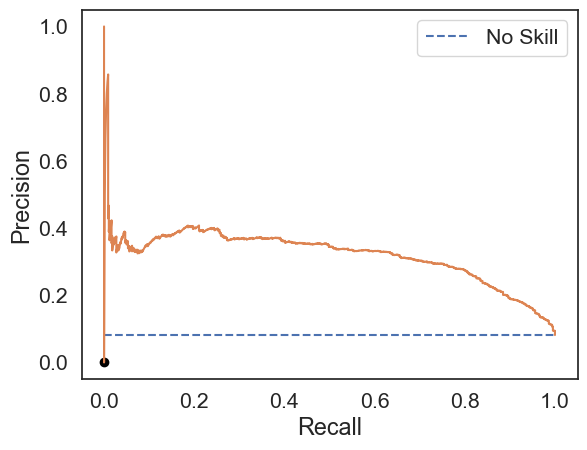

------------------------
------------------------
LogReg - 5 folds validation metrics (default threshold)
|                  |   mean scores |
|:-----------------|--------------:|
| LogReg_recall    |      0.818714 |
| LogReg_precision |      0.252405 |
| LogReg_f1        |      0.38542  |


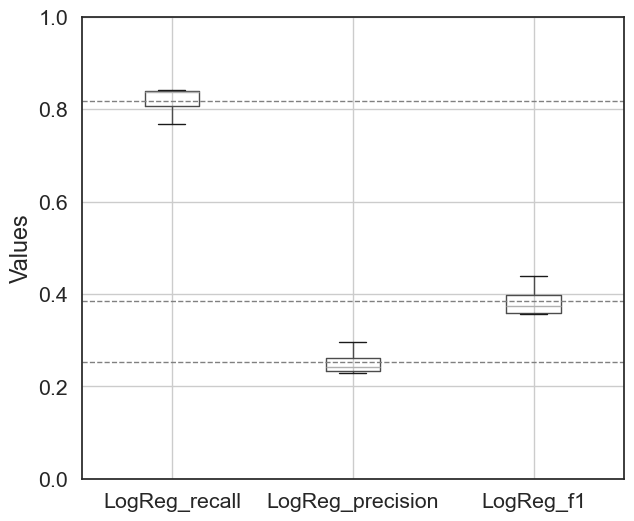

In [ ]:
from sklearn.linear_model import LogisticRegression

## tested with 50 random iterations
# param_grid = {
#     'penalty': ['l1', 'l2'],       # Regularization penalty ('l1' or 'l2')
#     'C': [0.01, 0.1, 1, 10],   # Inverse of regularization strength
#     'solver': ['liblinear', 'saga'],  # Algorithm to use for optimization
#     'max_iter': [100, 200, 300],    # Maximum number of iterations for optimization
#     'class_weight': ['balanced'], # controls the balance
#     'random_state': [42],
# }

param_grid_best = {
    'penalty': ['l1'],       # Regularization penalty ('l1' or 'l2')
    'C': [0.1],   # Inverse of regularization strength
    'solver': ['saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300],    # Maximum number of iterations for optimization
    'class_weight': ['balanced'], # controls the balance
    'random_state': [42],
}

model = training(LogisticRegression(), X_train, X_test, y_train, y_test, paramgrid=param_grid_best)

model_name = 'LogReg'

df_validation_LogReg = model_validation(model, X_test, y_test, model_name)

df_insp_rate_LogReg = inspection_rate_analysis(model, X_test, y_test, model_name)

2 - LightGBM testing

# Training the model
Fitting 5 folds for each of 2 candidates, totalling 10 fits
------------------------
------------------------
Best estimator: LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=7,
               metric='binary_logloss', min_child_samples=30,
               objective='binary', reg_alpha=0.5, reg_lambda=1,
               scale_pos_weight=12, subsample=0.8, verbose=-1)
Best score: 0.4062780388064827
------------------------
------------------------
# Classification report (default threshold)
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.859 |  0.85  |
| Precision |   0.315 |  0.309 |
| Recall    |   0.669 |  0.679 |
| F1        |   0.428 |  0.424 |


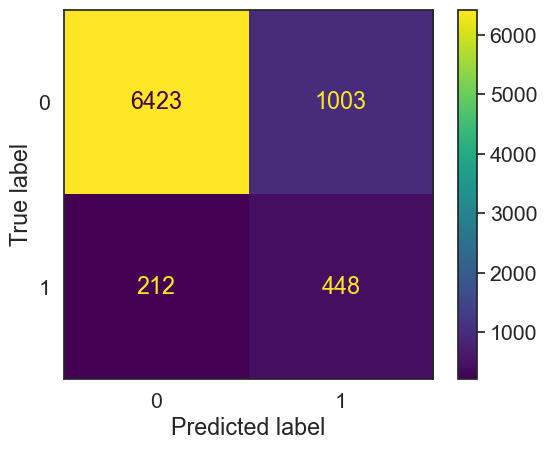

------------------------
------------------------
# Threshold based analysis
ROC curve analysis
Model AUC: 0.8734
Best ROC Threshold value = 0.3848


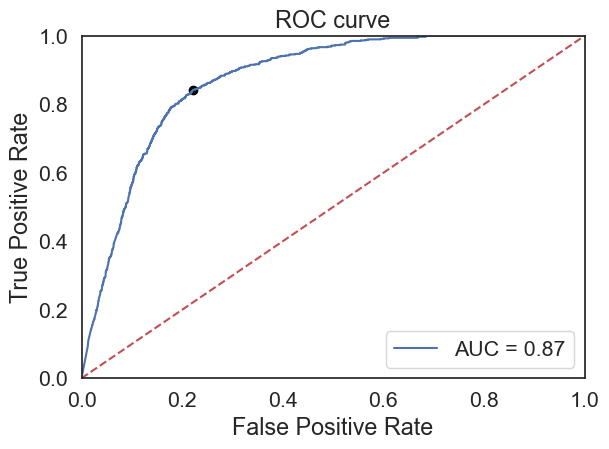

# Metrics with optimal threshold
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.801 |  0.784 |
| Precision |   0.264 |  0.253 |
| Recall    |   0.855 |  0.842 |
| F1        |   0.404 |  0.389 |


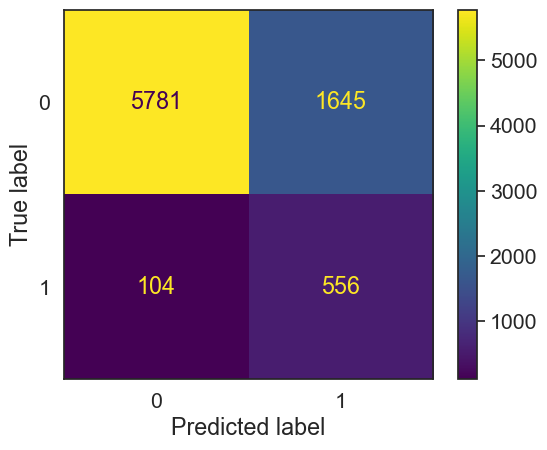

------------------------
------------------------
Precision-Recall curve analysis (P-R)
Best P-R Threshold = 0.5255, F-Score = 0.4329


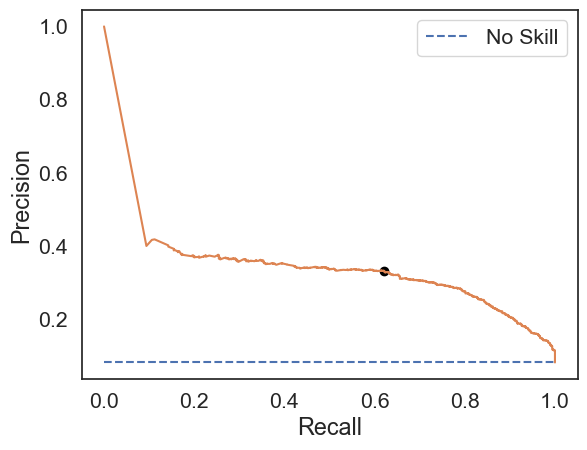

------------------------
------------------------
LGBM - 5 folds validation metrics (default threshold)
|                |   mean scores |
|:---------------|--------------:|
| LGBM_recall    |      0.622192 |
| LGBM_precision |      0.321976 |
| LGBM_f1        |      0.423574 |


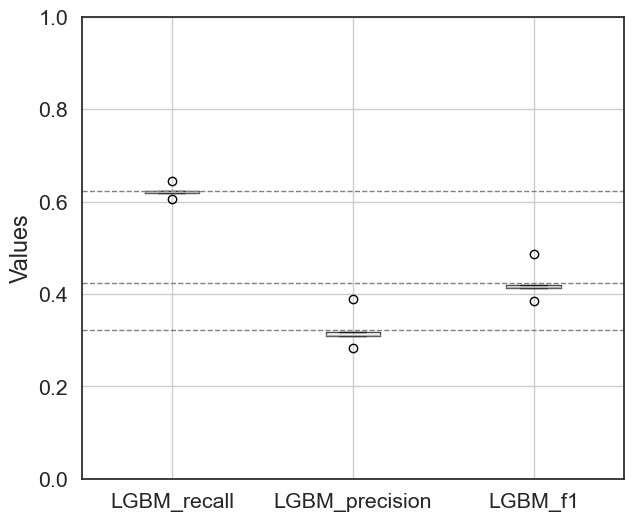

In [ ]:
from lightgbm import LGBMClassifier

## tested with 50 random iterations
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1], # step size
#     'n_estimators': [100, 200, 300], # number of boosting rounds or trees to build
#     'max_depth': [5, 7, 9], # max depth of a tree
#     'min_child_samples': [10, 20, 30], # min number of data points in a leaf
#     'subsample': [0.8, 1], # fraction of samples used for training each tree
#     'colsample_bytree': [0.8, 1], # fraction of features to train each tree
#     'reg_alpha': [0.1, 0.5, 1], # L1 reg
#     'reg_lambda': [0.1, 0.5, 1], # L2 reg
#     'scale_pos_weight': [int(len(y_train)/y_train.sum())], # controls the balance
#     'objective': ['binary'], # learning task
#     'metric': ['binary_logloss'], # metric used for early stopping
#     'verbose':[-1] # to avoid warnings
# }

param_grid_best = {
    'learning_rate': [0.01], # step size
    'n_estimators': [100], # number of boosting rounds or trees to build
    'max_depth': [7], # max depth of a tree
    'min_child_samples': [30], # min number of data points in a leaf
    'subsample': [0.8], # fraction of samples used for training each tree
    'colsample_bytree': [0.8, 1], # fraction of features to train each tree
    'reg_alpha': [0.5], # L1 reg
    'reg_lambda': [1], # L2 reg
    'scale_pos_weight': [int(len(y_train)/y_train.sum())], # controls the balance
    'objective': ['binary'], # learning task
    'metric': ['binary_logloss'], # metric used for early stopping
    'verbose':[-1] # to avoid warnings
}

model = training(LGBMClassifier(), X_train, X_test, y_train, y_test, paramgrid=param_grid_best)

model_name = 'LGBM'

df_validation_LGBM = model_validation(model, X_test, y_test, model_name)

df_insp_rate_LGBM = inspection_rate_analysis(model, X_test, y_test, model_name)

3 - XGBoost testing

# Training the model
Fitting 5 folds for each of 1 candidates, totalling 5 fits
------------------------
------------------------
Best estimator: XGBClassifier(alpha=7, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=3, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None, ...)
Best score: 0.3869103561235836
------------------------
------------------------
# Classification report (default threshold)
| Metric    |   Tra

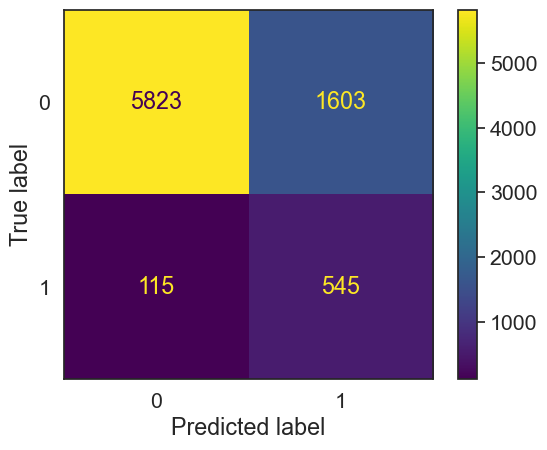

------------------------
------------------------
# Threshold based analysis
ROC curve analysis
Model AUC: 0.8756
Best ROC Threshold value = 0.4407


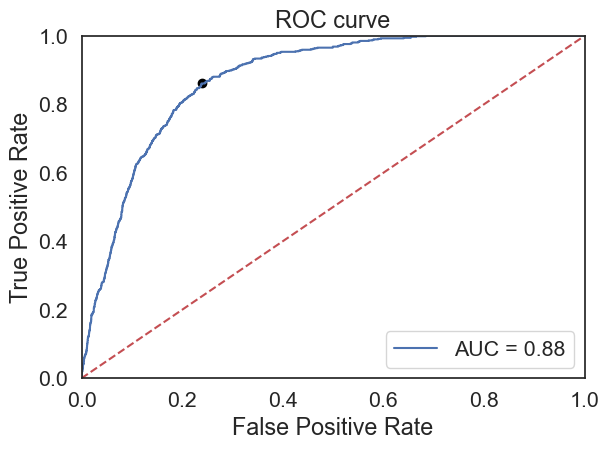

# Metrics with optimal threshold
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.794 |  0.77  |
| Precision |   0.271 |  0.243 |
| Recall    |   0.953 |  0.861 |
| F1        |   0.422 |  0.379 |


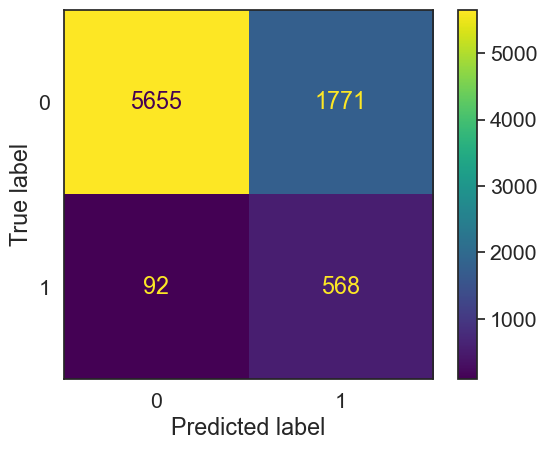

------------------------
------------------------
Precision-Recall curve analysis (P-R)
Best P-R Threshold = 0.7472, F-Score = 0.4390


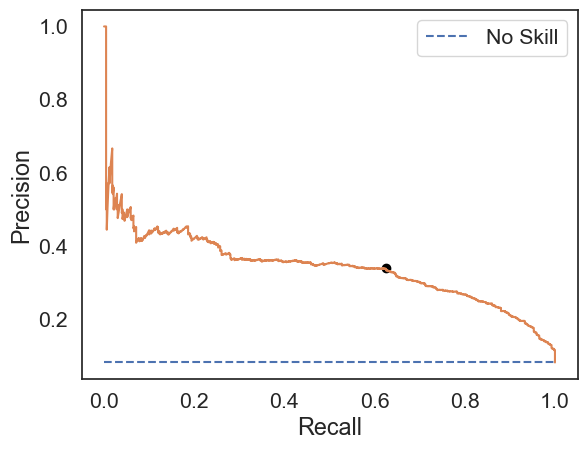

------------------------
------------------------
XGB - 5 folds validation metrics (default threshold)
|               |   mean scores |
|:--------------|--------------:|
| XGB_recall    |      0.697779 |
| XGB_precision |      0.296038 |
| XGB_f1        |      0.415305 |


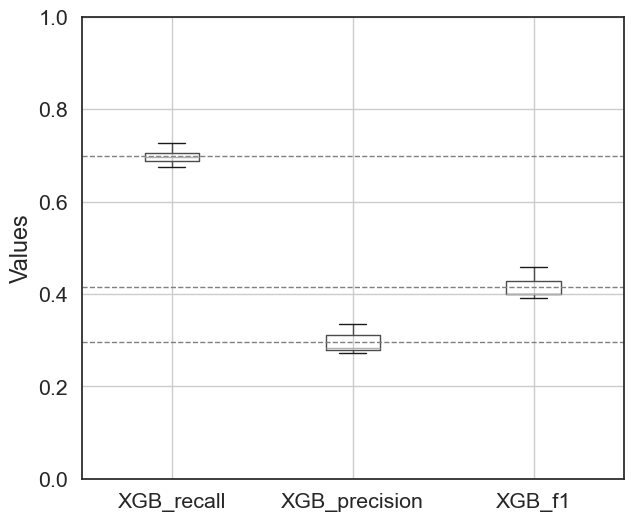

In [ ]:
# XGBoost paramenters to test

# # tested with 50 random iterations
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.3], # step size
#     'n_estimators': [50, 100], # number of trees
#     'max_depth': [3, 5, 7], # max depth of a tree
#     'min_child_weight': [3, 5], # min sum of instance weight needed in a child
#     'subsample': [0.8], # fraction of samples used for training each tree
#     'olsample_bytree': [0.8], # fraction of features to train each tree
#     'gamma': [1, 2], # min loss reduction to make a further partitions
#     'lambda': [2, 3], # L2 reg
#     'alpha': [5, 7], # L1 reg
#     'scale_pos_weight': [int(len(y_train)/y_train.sum())], # controls the balance
#     'verbosity':[0], # to avoid warnings
#     }

# best params adapted regarding overfitting issue
param_grid_best = {
    'learning_rate': [0.1], # step size
    'n_estimators': [100], # number of trees
    'max_depth': [5], # max depth of a tree
    'min_child_weight': [5], # min sum of instance weight needed in a child
    'subsample': [0.8], # fraction of samples used for training each tree
    'olsample_bytree': [0.8], # fraction of features to train each tree
    'gamma': [2], # min loss reduction to make a further partitions
    'lambda': [3], # L2 reg
    'alpha': [7], # L1 reg
    'scale_pos_weight': [int(len(y_train)/y_train.sum())], # controls the balance
    'verbosity':[0], # to avoid warnings
    'n_jobs': [-1],
    # 'device': ['cuda']
}

# binary classification objective
param_grid_best['objective'] = ['binary:logistic']

model = training(XGBClassifier(), X_train, X_test, y_train, y_test, paramgrid=param_grid_best)

model_name = 'XGB'

df_validation_XGB = model_validation(model, X_test, y_test, model_name)

df_insp_rate_XGB = inspection_rate_analysis(model, X_test, y_test, model_name)

## Model selection

### Validation metrics

|               |   mean recall |
|:--------------|--------------:|
| LogReg_recall |      0.818714 |
| LGBM_recall   |      0.622192 |
| XGB_recall    |      0.697779 |


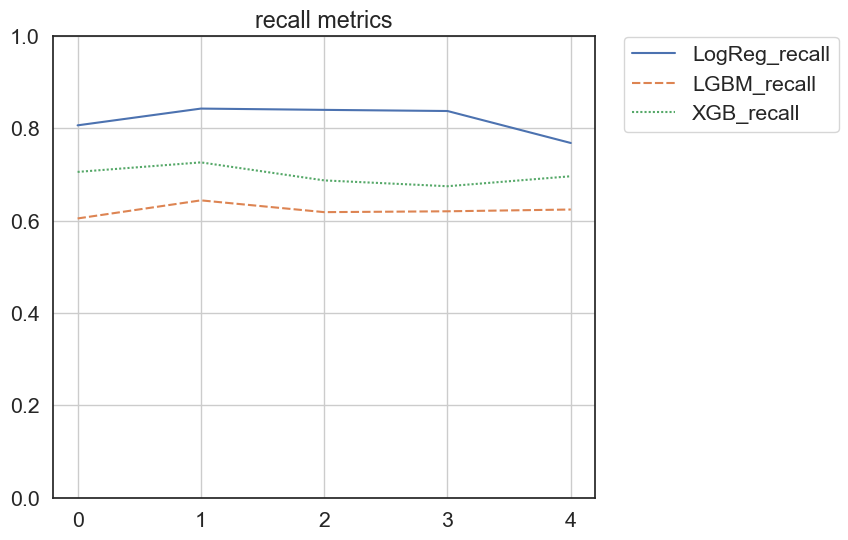

|                  |   mean precision |
|:-----------------|-----------------:|
| LogReg_precision |         0.252405 |
| LGBM_precision   |         0.321976 |
| XGB_precision    |         0.296038 |


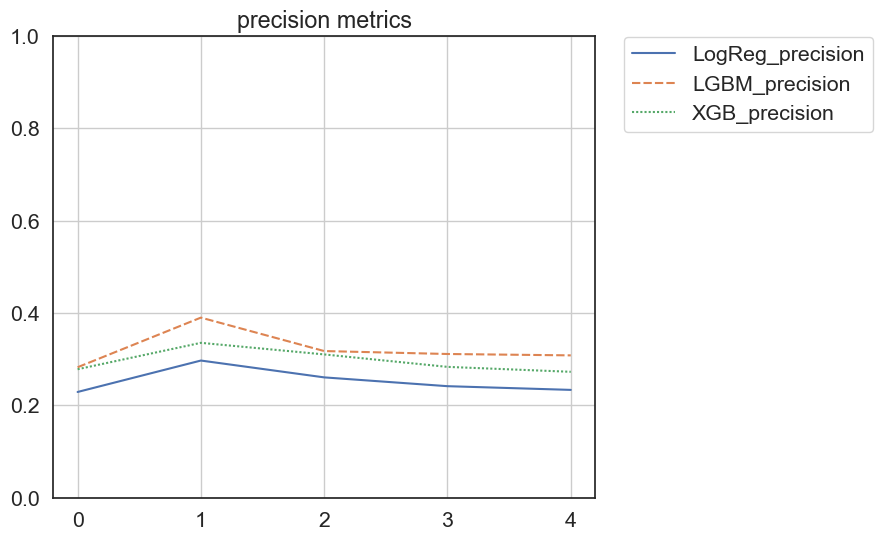

|           |   mean f1 |
|:----------|----------:|
| LogReg_f1 |  0.38542  |
| LGBM_f1   |  0.423574 |
| XGB_f1    |  0.415305 |


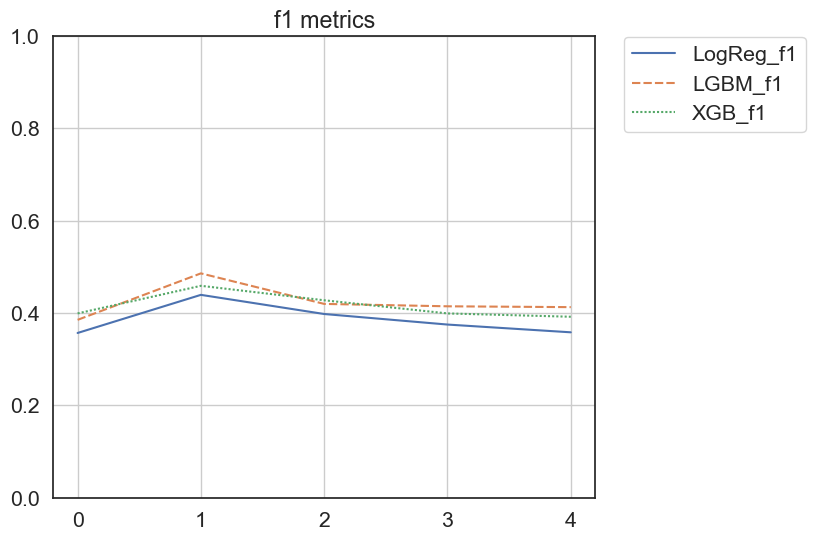

In [ ]:
for i in range(len(df_validation_LogReg.columns)):

    df = pd.DataFrame({df_validation_LogReg.iloc[:,i].name: df_validation_LogReg.iloc[:,i],
                       df_validation_LGBM.iloc[:,i].name:df_validation_LGBM.iloc[:,i],
                       df_validation_XGB.iloc[:,i].name:df_validation_XGB.iloc[:,i]})
    
    metric_name = df.columns[0].split('_')[-1]
    
    means = df.mean()
    means.rename(f'mean {metric_name}', inplace=True)

    print(means.to_markdown())

    plt.figure(figsize=(7,6))
    g = sns.lineplot(data = df)
    
    g.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.05)
    for lab in g.legend_.texts:
        lab.set_text(lab.get_text())
    
    g.set_xticks([0, 1, 2, 3, 4])
    
    g.set_ylim(0, 1)
    
    g.grid(True)
    
    g.set_title(metric_name + ' metrics')

    plt.show()

### Fraud detection vs. Inspection rate

In [ ]:
df_insp_rate = pd.merge(df_insp_rate_LogReg, df_insp_rate_LGBM, on='inspection_rate')\
                .merge(df_insp_rate_XGB, on='inspection_rate')

In [ ]:
df_insp_rate_summary = df_insp_rate.loc[df_insp_rate['inspection_rate'].isin([1, 3, 10, 20, 30, 40, 50])]\
    .set_index('inspection_rate').T

df_insp_rate_summary

inspection_rate         1    3    10   20   30   40   50
detection_rate_LogReg 0.05 0.14 0.43 0.73 0.85 0.91 0.95
detection_rate_LGBM   0.05 0.14 0.42 0.73 0.86 0.92 0.96
detection_rate_XGB    0.06 0.16 0.44 0.71 0.87 0.93 0.96

|                       |         1 |        3 |       10 |       20 |       30 |       40 |       50 |
|:----------------------|----------:|---------:|---------:|---------:|---------:|---------:|---------:|
| detection_rate_LogReg | 0.0469697 | 0.137879 | 0.434848 | 0.727273 | 0.85     | 0.912121 | 0.95303  |
| detection_rate_LGBM   | 0.0515152 | 0.143939 | 0.422727 | 0.733333 | 0.862121 | 0.919697 | 0.963636 |
| detection_rate_XGB    | 0.0590909 | 0.162121 | 0.437879 | 0.713636 | 0.868182 | 0.933333 | 0.960606 |


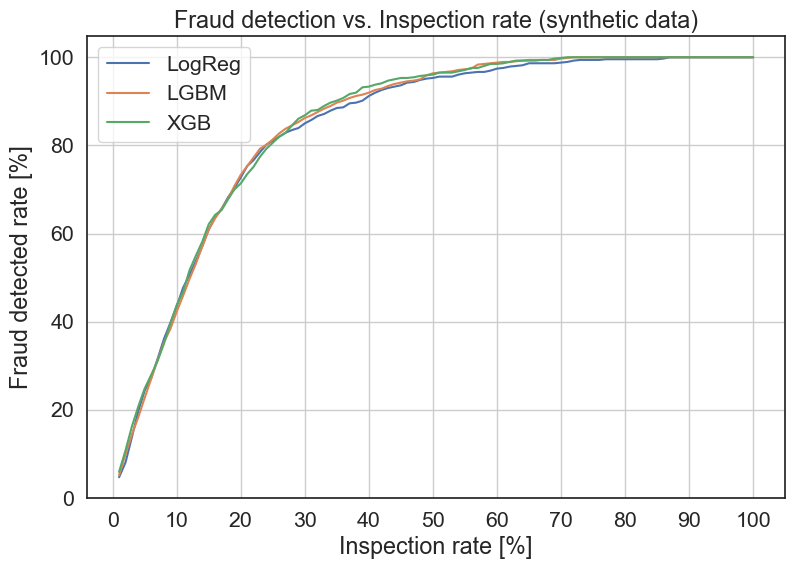

In [ ]:
print(df_insp_rate_summary.to_markdown())

# Plotting
plt.figure(figsize=(9, 6))

plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_LogReg'], label='LogReg')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_LGBM'], label='LGBM')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_XGB'], label='XGB')

# Adding labels and title
plt.xlabel('Inspection rate [%]')
plt.ylabel('Fraud detected rate [%]')
plt.title('Fraud detection vs. Inspection rate (synthetic data)')
plt.legend()
plt.xticks(range(0, 101, 10))

plt.grid(True)
# Show the plot
plt.show()

**Observations:**

> This result shows that synthetic data is not useful for performing model comparison and selection.

> CTGAN seems to produce synthetic data without preserving relations between variables.

### Results using real data


**Detection rate**

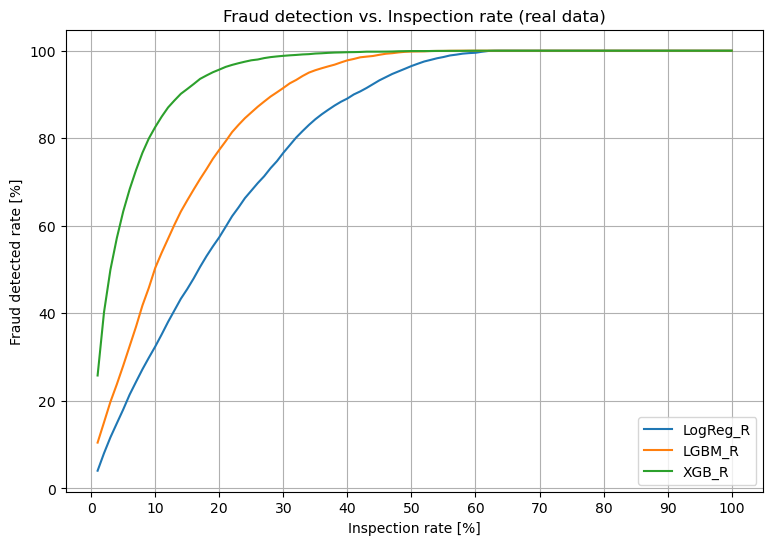

**Revenue rate increase**

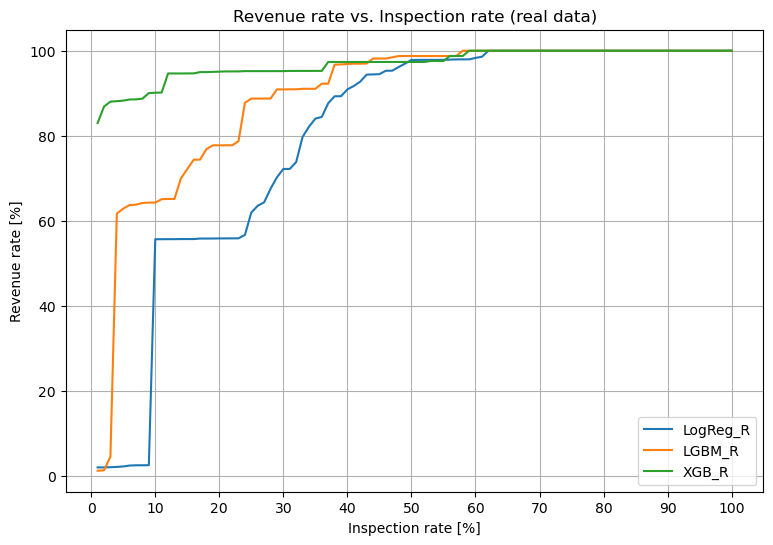

## Deep Learning model

4- Full Connected Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# defining the FCN architecture

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

class BinaryClassifier:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        self.model = SimpleNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)

    def fit(self, X_train, y_train, X_test, y_test, batch_size=1200, epochs=100):
            y_train = y_train.view(-1, 1)
            y_test = y_test.view(-1, 1)

            dataset_train = TensorDataset(X_train, y_train)
            dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

            dataset_test = TensorDataset(X_test, y_test)
            dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

            train_losses = []
            test_losses = []

            for epoch in range(epochs):
                # Training
                self.model.train()
                for inputs, labels in dataloader_train:
                    # Forward pass
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    # Backward and optimize
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                train_losses.append(loss.item())

                # Testing
                self.model.eval()
                with torch.no_grad():
                    test_loss = 0.0
                    for inputs, labels in dataloader_test:
                        outputs = self.model(inputs)
                        test_loss += self.criterion(outputs, labels).item()

                test_loss /= len(dataloader_test)
                test_losses.append(test_loss)
                
                
                print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

            # Plotting
            plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
            plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(X)
            return outputs.numpy()

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Defining the FCN architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

class BinaryClassifier:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        self.model = SimpleNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        
    def fit(self, X_train, y_train, X_test, y_test, batch_size=1200, epochs=100):
        y_train = y_train.view(-1, 1)
        y_test = y_test.view(-1, 1)

        dataset_train = TensorDataset(X_train, y_train)
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

        dataset_test = TensorDataset(X_test, y_test)
        dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # Training
            self.model.train()
            epoch_train_loss = 0.0
            for inputs, labels in dataloader_train:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            # Calculate mean training loss for the epoch
            epoch_train_loss /= len(dataloader_train)
            train_losses.append(epoch_train_loss)

            # Testing
            self.model.eval()
            with torch.no_grad():
                epoch_test_loss = 0.0
                for inputs, labels in dataloader_test:
                    outputs = self.model(inputs)
                    epoch_test_loss += self.criterion(outputs, labels).item()

            # Calculate mean test loss for the epoch
            epoch_test_loss /= len(dataloader_test)
            test_losses.append(epoch_test_loss)

            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

        # Plotting
        plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(X)
            return outputs.numpy()

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


In [ ]:
len(X_train.columns)

41

In [ ]:
# FCN structure parameters
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 128
hidden_size3 = 32
output_size = 1

# instance of the classifier
model = BinaryClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

Epoch [1/300], Training Loss: 0.6958, Test Loss: 0.6364
Epoch [2/300], Training Loss: 0.6954, Test Loss: 0.6395
Epoch [3/300], Training Loss: 0.6950, Test Loss: 0.6424
Epoch [4/300], Training Loss: 0.6946, Test Loss: 0.6452
Epoch [5/300], Training Loss: 0.6942, Test Loss: 0.6479
Epoch [6/300], Training Loss: 0.6938, Test Loss: 0.6504
Epoch [7/300], Training Loss: 0.6934, Test Loss: 0.6528
Epoch [8/300], Training Loss: 0.6931, Test Loss: 0.6551
Epoch [9/300], Training Loss: 0.6928, Test Loss: 0.6573
Epoch [10/300], Training Loss: 0.6925, Test Loss: 0.6594
Epoch [11/300], Training Loss: 0.6921, Test Loss: 0.6613
Epoch [12/300], Training Loss: 0.6919, Test Loss: 0.6631
Epoch [13/300], Training Loss: 0.6915, Test Loss: 0.6649
Epoch [14/300], Training Loss: 0.6912, Test Loss: 0.6666
Epoch [15/300], Training Loss: 0.6910, Test Loss: 0.6682
Epoch [16/300], Training Loss: 0.6907, Test Loss: 0.6696
Epoch [17/300], Training Loss: 0.6904, Test Loss: 0.6710
Epoch [18/300], Training Loss: 0.6900, T

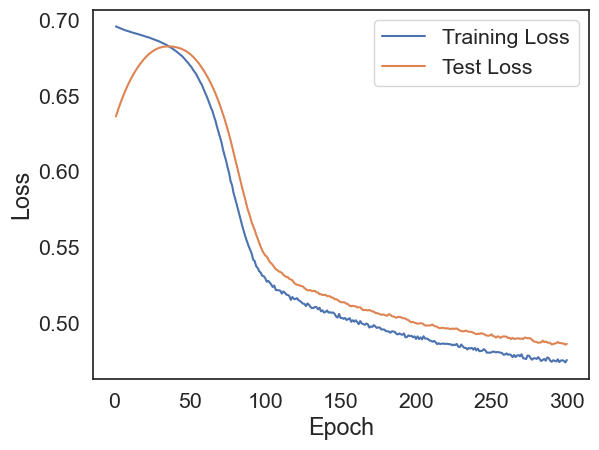

In [ ]:
# sampling train dataset to fix unbalace 

over = RandomOverSampler(random_state=0)
X_over_train, y_over_train = over.fit_resample(X_train, y_train)

# tensors
Xtensor_train = torch.tensor(X_over_train.values, dtype=torch.float32)
ytensor_train = torch.tensor(y_over_train.values, dtype=torch.float32)

Xtensor_test = torch.tensor(X_test.values, dtype=torch.float32)
ytensor_test = torch.tensor(y_test.values, dtype=torch.float32)

# fitting
model.fit(Xtensor_train, ytensor_train, Xtensor_test, ytensor_test, batch_size=3000, epochs=300)

In [ ]:
# extracting results to compare
model_name = 'FCN'

# redefining tensors for train without sampling
Xtensor_train = torch.tensor(X_train.values, dtype=torch.float32)
ytensor_train = torch.tensor(y_train.values, dtype=torch.float32)

y_proba = model.predict_proba(Xtensor_test)

df_result = pd.DataFrame({'illicit': ytensor_test.flatten(),
            'proba':y_proba.flatten()})

df_result.sort_values(by='proba', ascending=False, inplace=True)

total_frauds = df_result['illicit'].sum()

inspection_rate = []
detection_rate = []

for i in range(1, 101):
    rows = int(i*len(df_result)/100)

    detection_rate_i = df_result.head(rows)['illicit'].sum()/total_frauds
    
    inspection_rate.append(i)
    detection_rate.append(detection_rate_i)

del df_result

df_insp_rate_FCN = pd.DataFrame({'inspection_rate': inspection_rate,
                            f'detection_rate_{model_name}': detection_rate})

### DL model comparison

In [ ]:
df_insp_rate = pd.merge(df_insp_rate_XGB, df_insp_rate_FCN, on='inspection_rate')

In [ ]:
df_insp_rate_summary = df_insp_rate.loc[df_insp_rate['inspection_rate'].isin([1, 3, 10, 20, 30, 40, 50])]\
    .set_index('inspection_rate').T

df_insp_rate_summary

inspection_rate      1    3    10   20   30   40   50
detection_rate_XGB 0.06 0.16 0.44 0.71 0.87 0.93 0.96
detection_rate_FCN 0.04 0.13 0.43 0.71 0.84 0.92 0.95

|                    |         1 |        3 |       10 |       20 |       30 |       40 |       50 |
|:-------------------|----------:|---------:|---------:|---------:|---------:|---------:|---------:|
| detection_rate_XGB | 0.0590909 | 0.162121 | 0.437879 | 0.713636 | 0.868182 | 0.933333 | 0.960606 |
| detection_rate_FCN | 0.0378788 | 0.130303 | 0.434848 | 0.707576 | 0.843939 | 0.915152 | 0.95303  |


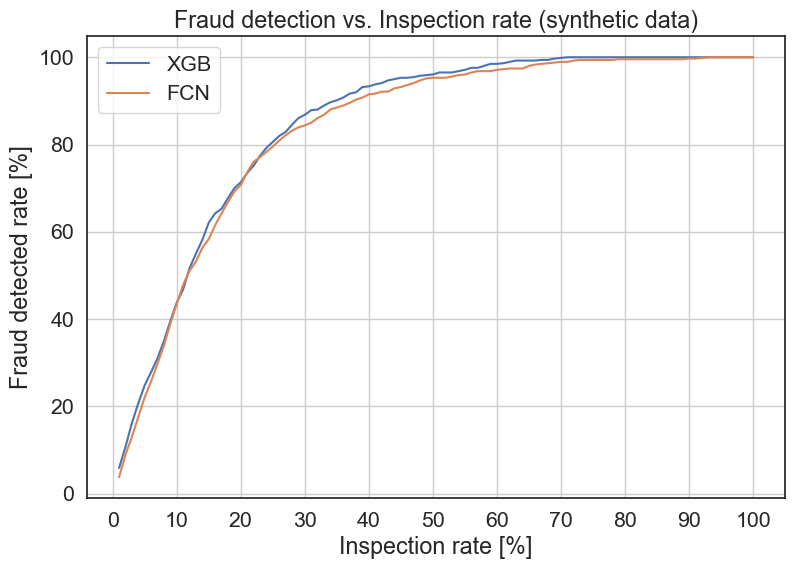

In [ ]:
print(df_insp_rate_summary.to_markdown())

# Plotting
plt.figure(figsize=(9, 6))

plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_XGB'], label='XGB')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_FCN'], label='FCN')


# Adding labels and title
plt.xlabel('Inspection rate [%]')
plt.ylabel('Fraud detected rate [%]')
plt.title('Fraud detection vs. Inspection rate (synthetic data)')
plt.legend()
plt.xticks(range(0, 101, 10))

plt.grid(True)
# Show the plot
plt.show()

### DATE model
Real data results

DATE model was used by replacing the relevant Importer ID feature by Country of Origin ID.

**Detection rate**

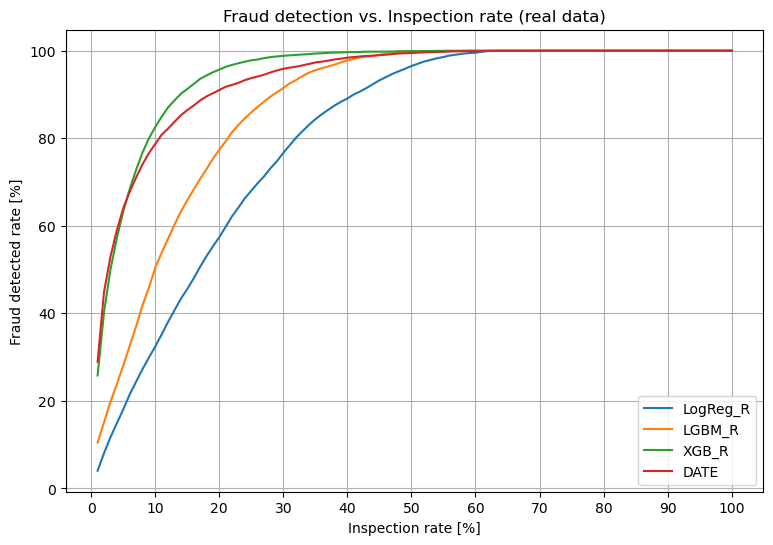

**Revenue rate increase**

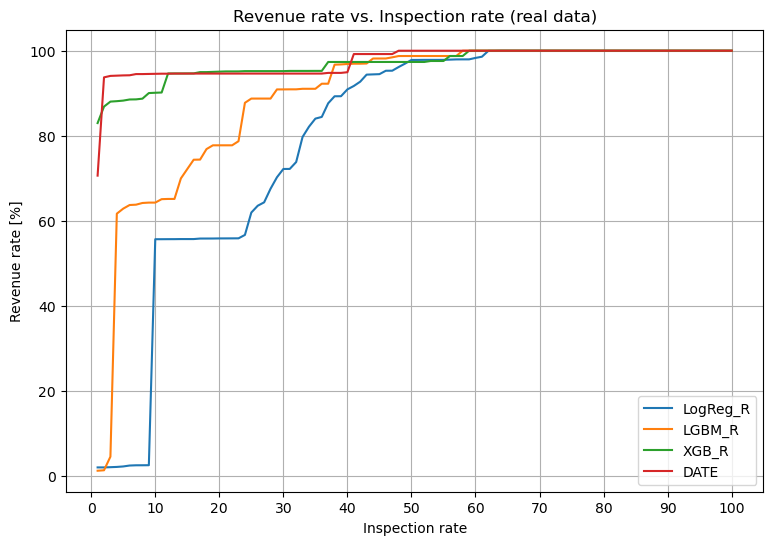

**Observations (from real data results):** 

> XGBoost has shown a validated superior F1 and also a better expected performance in Fraud detection and revenue increase vs. Inspection rate.

> XGBoost was therefore selected from the classic ML models, on the basis of a superior mean F1 in validation stage.

> DATE model, using Country of Origin IDs instead of Importer IDs, is not superior compared with XGBoost.

### Splitted problem by transport means

XGBoost with real data results

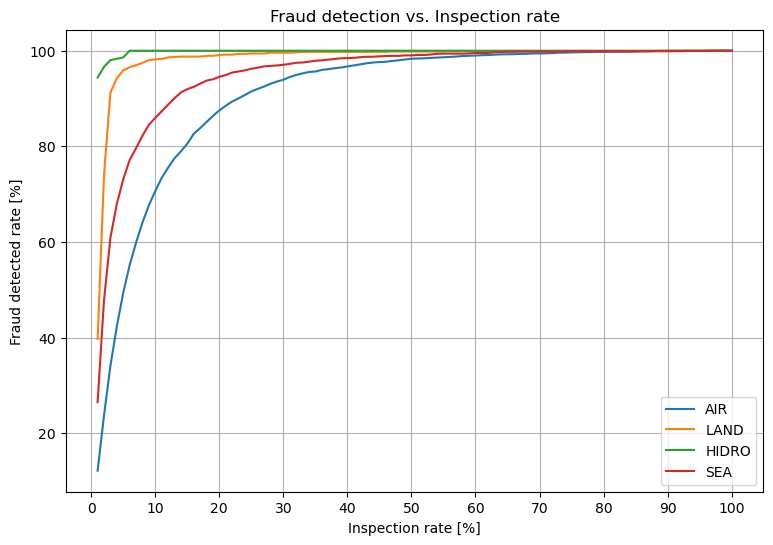

**Observations:**

Splitting the problem by means of transport is relevant for improving the performance of the model in the fraud detection.

Concatenated results from different models by transport (default threshold)
| Metric    |   Test |
|:----------|-------:|
| Accuracy  |  0.95  |
| Precision |  0.369 |
| Recall    |  0.879 |
| **F1**        |  **0.52**  | + 25 % of increase

Comparable against Global XGBoots model with default threshold:

Classification report (default threshold)
| Metric    |   Train |   Test |
|:----------|--------:|-------:|
| Accuracy  |   0.852 |  0.849 |
| Precision |   0.17  |  0.162 |
| Recall    |   0.972 |  0.941 |
| F1        |   0.289 |  0.277 |


## Model validation

XGBoost was retrained with 20 different random training and testing splits, and the results were processed to analyse the variance in the results. 

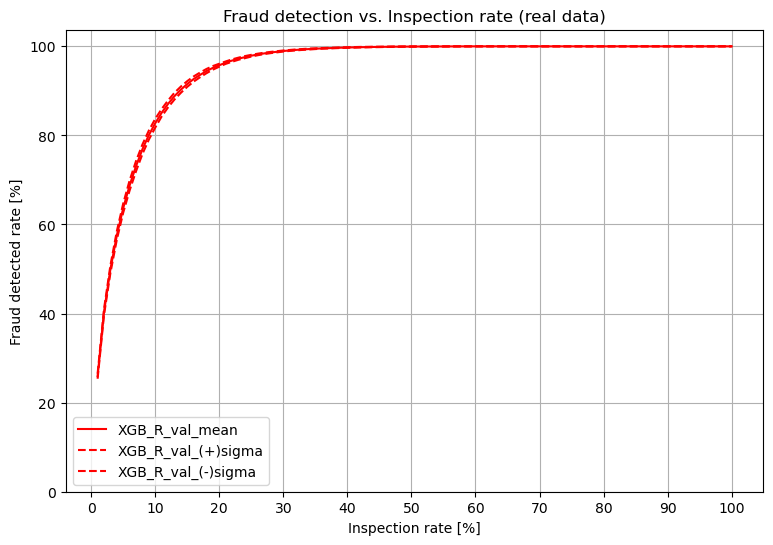

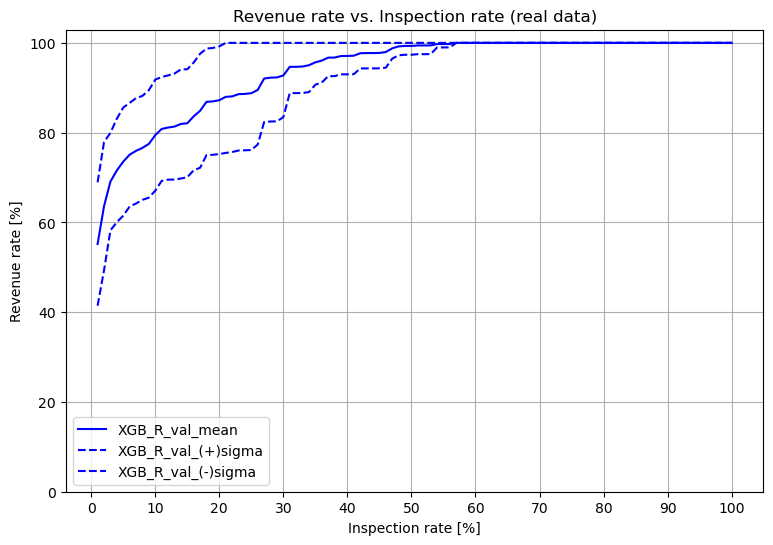

**Observations:**

> Fraud detection rate is stable and quite good over the 20 models.

> Revenue increase rate shows more variance, coming from the randomness split and the variance of the penalties amount. 

________________________________________________________

# Conclusions

**Data**

> Synthetic data shown not to be useful for performing model comparison and selection

> CTGAN seems to produce synthetic data without preserving relations between variables

> It was possible to obtain promising fraud detection results ignoring importer and broker IDs

**Models**

> Ensemble models (XGBoost and LightGBM) found to be able to learn from real data

> XGBoost was selected from the classic ML models, based on the superior mean F1 obtained in validation stage

> XGBoost selection was confirmed with Fraud detection and Revenue increase vs. Inspection rate

> DATE model, using country IDs instead of importer IDs, shown similar results to XGBoost

> Splitting the problem by means of transport showed significant improvement (+ 25% in F1 score)

**Results and outcomes**

> 20 % of inspection rate would come with 96 % of the fraud detected

> 30 % of inspection rate can would come with 99 % of the fraud detected

> Intensive validation over XGboost shows stable prediction with regards to fraud detected rate

> Revenue increase depends on the data and its split

**Development and Deployment**

> It is expected that the development of this project takes around 22 months

> Its deployment will be around 3-6 months and a continuous effort is required in its maintenance



________

# Next steps

## Deployment

> Seek support and approval from authorities, risk management managers, legal and software development areas.

> Run the shadow stage, for further analysis and validation, and canary stage to define the AI-RMS integration.

> Assess generalization and degradation of the model's performance, defining maintenance procedures.

## Continuous improvement

**0. Multiclass target evaluation**

> Define the classes of fraud in the dataset

> Train and evaluate multiclass models

**1. Error analysis to prevent impact**

**2. More Features and enginering**

> Dense representation of HS code descriptions and commercial descriptions.

> Dense representation of Operators (Name + Activities + Countries + Others features available)

> Seek external data for add as usefull information

> Measure activity regarding the date or period of the year

> More information Customs OFFICES and OPERATION SITES (staff, equipment, and others)

> Information about workload of OFFICES and OPERATION SITES

> Date information holidays

